Code for the paper "Understanding Filter Bubbles and Polarization in Social Networks" by Uthsav Chitra and Chris Musco.

Link: https://arxiv.org/pdf/1906.08772.pdf

Dependencies: Numpy, Matplotlib, Scipy, Networkx, Gurobi [Gurobi typically needs a license, which is free for academics]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from scipy.linalg import solve
from gurobipy import *

import networkx as nx

from time import time
from pprint import pprint
import pickle
import csv # reading network files

# Alternating Minimization/SBM Code

Below: code for generating a Stochastic Block Model (SBM) graph with two groups (Section 4.1)

In [2]:
# q0: edge probability in group 0
# q1: edge probability in group 1
# p: edge probability in between groups

# intrinsic opinions in group i are drawn iid from N(si_mean, s_std)
# group 0 has n nodes, group 1 has m nodes
def create_A_s(q0,q1,p, s0_mean=0.25, s1_mean=0.75, s_std=0.1,n=32,m=32,lb=0,ub=1):
    tot = n+m

    A = np.zeros([tot,tot])
    for i in range(tot):
        for j in range(i+1,tot):
            if i > n and j > n: #q1
                A[i,j]=np.random.binomial(1,q1)
            elif j > n: # then i <=n-1 and j > n, so p
                A[i,j]=np.random.binomial(1,p)
            elif j <=n: # then i <= n-1 and j <= n-1, so q0
                A[i,j]=np.random.binomial(1,q0)
    A=A+A.T
    s = np.concatenate((np.random.normal(loc=s0_mean,scale=s_std,size=n),np.random.normal(loc=s1_mean,scale=s_std,size=m)))
    s=np.maximum(s,lb)
    s=np.minimum(s,ub)
    return A,s

Next, we create our "alternating minimization" function, which simulates the Network Administrator Dynamics (Section 3)

In [97]:
################################################
# HELPER FUNCTIONS FOR ALTERNATING MINIMIZATION
################################################

# find z that minimizes z^T L z + |z-s|^2
# W = weight matrix for graph
# s = innate opinions
def min_z(W,s):
    D = np.diag(np.sum(W,0))
    L = D - W
    n=L.shape[0]
    return solve(L+np.eye(n),s)

# find weight matrix W that minimizes z^T L z, 
# where L is graph Laplacian corresponding to W
# constrained to {W : ||W-W0|| < lam * ||W0||} where W0 is the original graph
# (lam is what proportio of edges in the original graph you are allowed to change)
# we also impose the restriction that sum(W[:,i]) = sum(W0[:,i]), 
# i.e. the degree of each vertex is conserved

# IF reduce_pls = True, then we add the term gam*||W||^2 to the objective
# as this empirically reduces polarization (encourages more connections to every vertex)
def min_w_gurobi(z, lam, W0, reduce_pls, gam, existing):
    n = z.shape[0]
    m = Model("qcp")

    if existing:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]
    else:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j]
    x=m.addVars(inds, lb=0.0, name="x")

    # obj is min \sum_{i,j} wij (zi-zj)^2
    if existing:
        w={(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j and W0[i,j]>0}
    else:
        w = {(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j}

    obj_exp = x.prod(w)
    if reduce_pls:
        obj_exp += gam*x.prod(x)
    m.setObjective(obj_exp, GRB.MINIMIZE)
    print('added variables')
    
    # add constraints sum_j x[i,j] = di
    d = np.sum(W0,0)
    for i in range(n):
        if existing:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n) if W0[i,j] > 0] + [x[(i,j)] for j in range(i) if W0[i,j] > 0]) == d[i])
        else:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n)] + [x[(i,j)] for j in range(i)]) == d[i])
    print('added first constraint')
    
    # add constraint \sum_{i,j} (wij - w0ij) < lam*norm(w0)**2
    rhs = (lam*np.linalg.norm(A))**2
    
    if existing:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]) <= rhs)
    else:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j]) <= rhs)
    print('added second constraint')
    print('starting to optimize')
    m.optimize()
    
    W = np.zeros([n,n])
    for u in range(n):
        for v in range(n):
            if u>v:
                if (existing and W0[u,v] > 0) or (not existing):
                    W[u,v]=x[(u,v)].X
                    W[v,u] = W[u,v]
    return W

# given opinion vectors z, compute 
# polarization = variance(z)
def compute_pls(z):
    z_centered = z - np.mean(z)
    return z_centered.dot(z_centered)

In [20]:
# Alternating Minimization function for network admin game
# Parameters:
# 1) A: initial graph (adjacency matrix) 

# 2) s: intrinsic opinions

# 3) lam: constraint parameter

# 4) reduce_pls: if true, implement additional L2 regularization to 
# reduce polarization (and disagreement!)
# 5) gam: regularization coefficient for reduce_pls
# 6) max_iters: max number of iterations of network admin game

# 7) existing: only change weights of edges already existing in the graph 

# RETURNS:
# pls: list of polarizations at each iteration
# z: opinions at final iteration of game
# W: adjacency matrix at final iteration of game
def am(A,s,lam,reduce_pls=False,gam=0,max_iters=100, existing=False):
    # alternating minimization
    W = np.copy(A)
    z = min_z(W,s) # minimize z first

    # polarization
    pls = [compute_pls(z)]
    
    # disagreement
    L = np.diag(np.sum(W,0))-W
    disaggs = [z.T.dot(L).dot(z)]

    # LOOP: first minimize W, then minimize z
    # then decide if we should exit
    i = 0
    flag = True
    while flag:
        print('iteration: {}'.format(i))
        # minimize W
        Wnew = min_w_gurobi(z,lam,A,reduce_pls=reduce_pls,gam=gam,existing=existing)
        
        # minimize z
        znew = min_z(Wnew,s)

        # exit condition
        if np.maximum(np.linalg.norm(z-znew), np.linalg.norm(Wnew-W)) < 5e-1 or i > max_iters - 1:
            flag = False

        # update z,W,i,pls
        z = znew
        W = Wnew
        i=i+1
        pls.append(compute_pls(z))
        L = np.diag(np.sum(W,0))-W
        disaggs.append(z.T.dot(L).dot(z))
    return pls, disaggs, z, W

# Creating Teaser Image (Figure 1)

In this section, we create the images used in Figure 1.
Note: If you re-run this code, you will likely create different images, because of the randomness in the SBM graph, and how graphs can be visualized in different ways.

## Create SBM network and run NA dynamics

In [246]:
q0=0.25
q1=0.25
p=0.1
n=20
m=20

# create SBM network
A,s=create_A_s(q0,q1,p, s0_mean=-0.7, s1_mean=0.7, s_std=0.1,n=n,m=m,lb=-1.0,ub=1.0)

# run the network administrator (NA) dynamics on A, 
# with varying amounts of constraints on NA
pls1,objs1,z1,W1=am(A,s,0.14)
pls2,objs2,z2,W2=am(A,s,0.2)
pls3,objs3,z3,W3=am(A,s,0.3) # ended up not using this one

W1=np.round(W1,decimals=3)
W2=np.round(W2,decimals=3)
W3=np.round(W3,decimals=3)

LA = np.diag(np.sum(A,0))-A
z_before=solve(LA+np.eye(n+m),s)

iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 40 rows, 780 columns and 1560 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [8e-10, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.02s
Presolved: 822 rows, 782 columns, 2478 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.338e+03
 Factor NZ  : 4.161e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.929e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.32307379e+00  7.32304854e+00  1.57e+01 2.37e+00  1.58e+01     0s
   1   3.59561064


Barrier solved model in 12 iterations and 0.11 seconds
Optimal objective 4.59830871e+00

iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 40 rows, 780 columns and 1560 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [8e-10, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.02s
Presolved: 822 rows, 782 columns, 2478 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.338e+03
 Factor NZ  : 4.161e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.929e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 

## Functions for graph visualization

A bunch of scripts for visualizing our graphs so that:

1) edges are lighter/darker depending on their weight

2) nodes are colored depending on their expressed opinion

In [253]:
def vis_params(W,z,layout='spring'):
    G = nx.Graph(W)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors, emin, emax, vmin, vmax,width=0.5,node_size=150):
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, cmap=plt.cm.coolwarm, vmin=vmin,vmax=vmax, width=width, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)

Ga, posa, edge_colors_a, node_colors_a = vis_params(A, z_before)
G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1)
G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W3, z3)

# set scale for edges
# we want weight emax to be the darkest edge, and 0.0 to be the lightest edge
emin=0.2
emax=1.0

# set scale for vertices
# we want 1.0 to be reddest vertex, 0.0 to be bluest vertex
vmin1=-1.0
vmax1=1.0

vmin2=np.min(z2)
vmax2=np.max(z2)

## Check how much NA changed graphs

Check what % of edge weight in W1 and W2 is changed by the NA

In [266]:
np.linalg.norm(W1-A,1) /np.linalg.norm(A,1) # about 20% is changed

0.2020833333333333

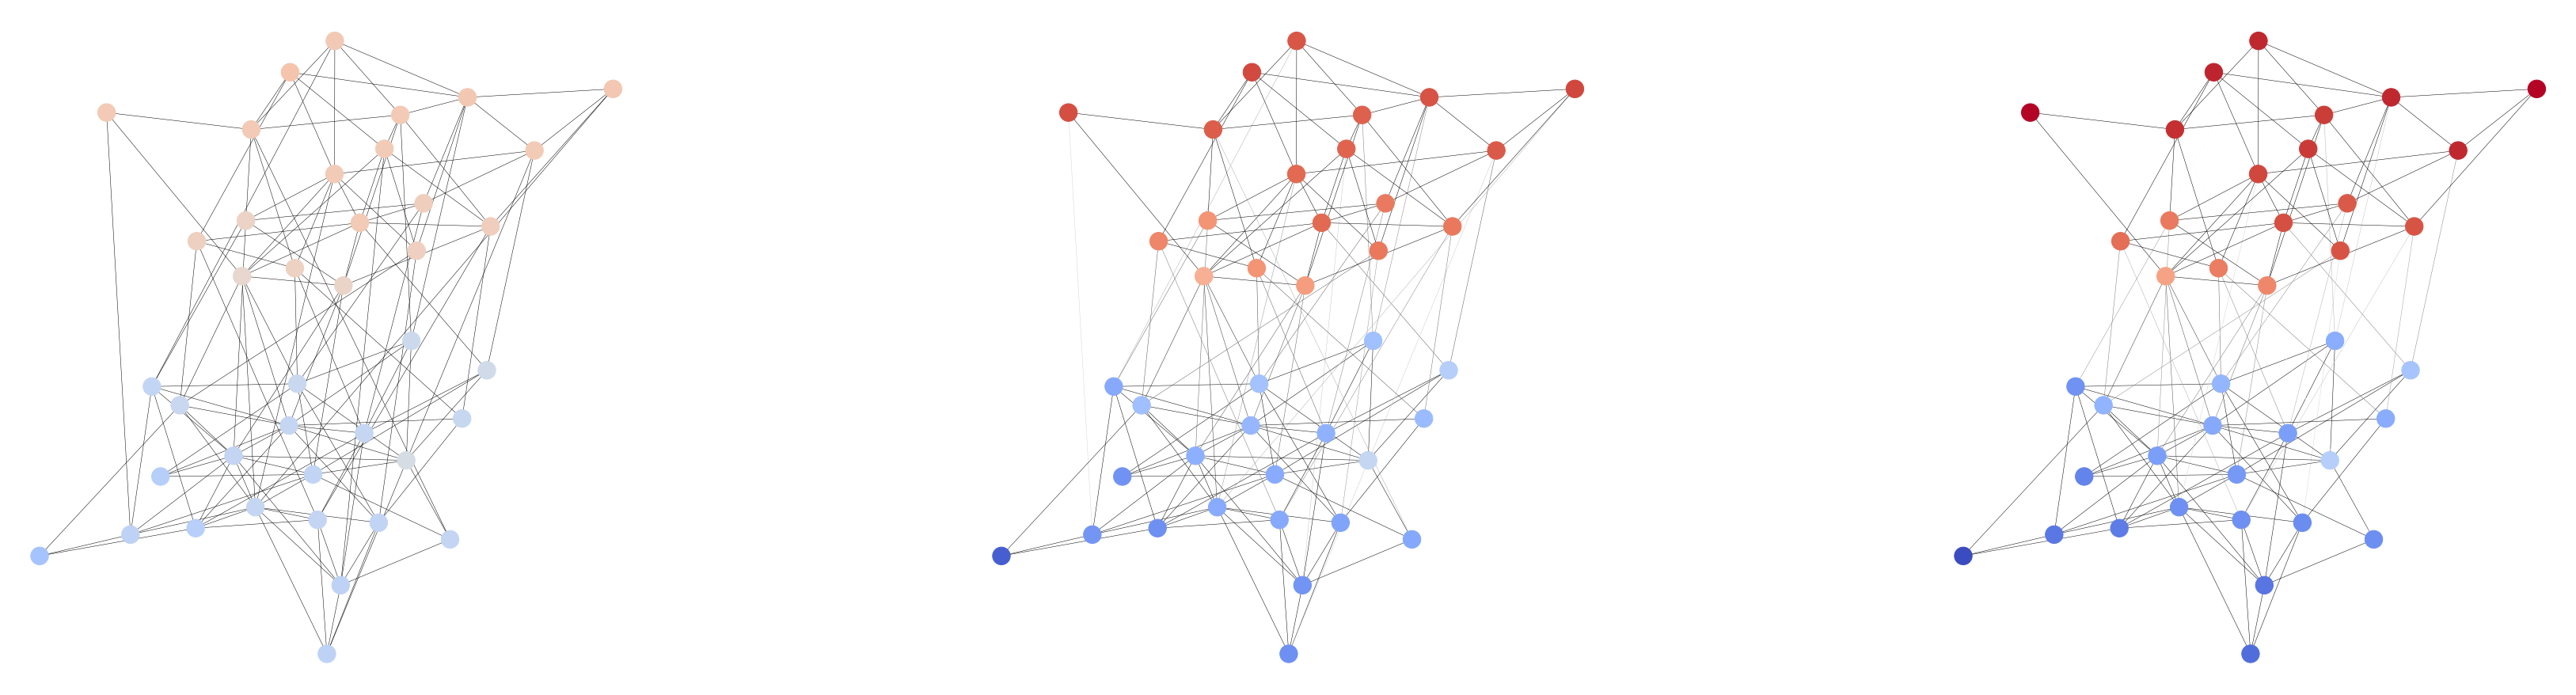

In [254]:
f, axs = plt.subplots(1,3,figsize=(50,15))

pos = pos2 #same node positions

plt.subplot(131)
im=plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin1, vmax1,node_size=500)
#plt.title('Original graph')

# plt.subplot(132)
# plot_graph(G1, pos, node_colors_1, edge_colors_1, emin, emax, vmin, vmax)
# #plt.title('lambda=0.05')

plt.subplot(132)
plot_graph(G1, pos, node_colors_1, edge_colors_1, emin, emax, vmin2, vmax2,node_size=500)
#plt.title('lambda=0.10')

plt.subplot(133)
plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin2, vmax2,node_size=500)
#plt.title('lambda=0.15')

# sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin = vmin1, vmax=vmax1))
# sm._A = []
# plt.colorbar(sm, ax=axs.ravel().tolist(),shrink=0.9,anchor=(1.8,0.5))

plt.subplots_adjust(left=0,right=0.9,bottom=0.1,top=0.9,wspace=0.5)

#plt.savefig('potential_teaser3.png')

In [267]:
np.linalg.norm(W2-A,1) /np.linalg.norm(A,1) # about 30% is changed

0.29091666666666666

## Create plots used in teaser figure 

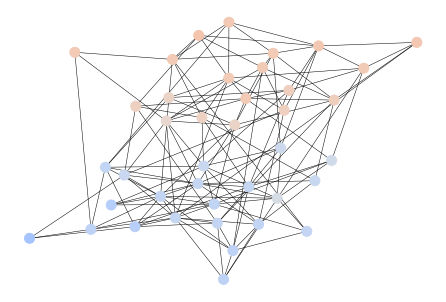

In [263]:
plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin1, vmax1,node_size=100)
plt.savefig('potential_teaser4a_2.pdf')

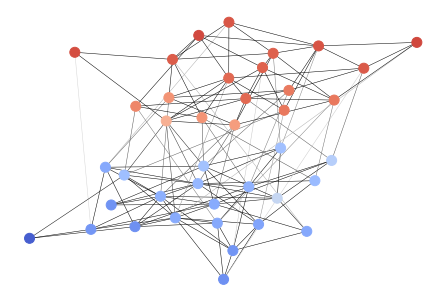

In [260]:
plot_graph(G1, pos, node_colors_1, edge_colors_1, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig('potential_teaser4b_2.pdf')

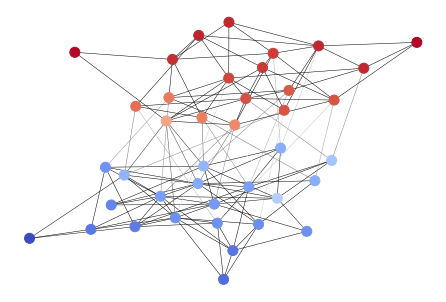

In [261]:
plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig('potential_teaser4c_2.pdf')

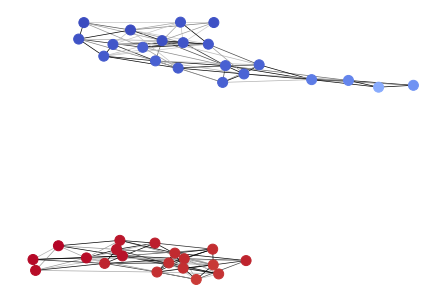

In [80]:
# does not look very good??
plot_graph(G3, pos, node_colors_3, edge_colors_3, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig('potential_teaser4c_2.pdf')

# Plot polarization,disagg vs epsilon for SBM

In [722]:
# with degree constraint

q0=0.25
q1=0.25
p=0.1
n=40
m=40

num_eps=11
num_trials = 3 # 4 trials per prop

eps_list=np.linspace(0,1,num_eps)
pls_ratio_list=np.zeros([num_trials, num_eps])
pls_ratio_fix_list=np.zeros([num_trials, num_eps])

dis_ratio_list=np.zeros([num_trials, num_eps])
dis_ratio_fix_list=np.zeros([num_trials, num_eps])

for t in range(num_trials):
    for i in range(num_eps):
        print("t: {}, i:{}".format(t,i))
        lam = eps_list[i]

        A,s=create_A_s(q0,q1,p,s0_mean=-0.75, s1_mean=0.75, s_std=0.2,n=n,m=m)
        pls, dis, z, W = am(A,s,lam,max_iters=5)
        pls2, dis2, z2, W2 = am(A,s,lam,max_iters=5,reduce_pls=True,gam=0.2)
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_ratio_fix_list[t,i] = pls2[-1] * 1.0 / pls2[0]
        
        dis_ratio_list[t,i] = dis[-1] * 1.0 / dis[0]
        dis_ratio_fix_list[t,i] = dis2[-1] * 1.0 / dis2[0]

t: 0, i:0
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [6e-12, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [6e+02, 6e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10048 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.337e+04
 Factor NZ  : 1.661e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.428e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.54204704e+00  1.54204795e+00  3.27e+01 2.36e-01  3.26e+00     0s
  

  32   1.14067052e+02  1.14026317e+02  2.30e-04 2.46e-05  4.66e-06     1s
  33   1.14073198e+02  1.14031769e+02  1.17e-04 8.65e-05  4.61e-06     1s
  34   1.14077817e+02  1.14032074e+02  3.71e-05 4.09e-05  4.98e-06     1s
  35   1.14078291e+02  1.14032186e+02  1.96e-04 4.03e-05  5.00e-06     1s
  36   1.14081232e+02  1.14032360e+02  1.11e-04 6.32e-05  5.22e-06     1s
  37   1.14082363e+02  1.14032703e+02  1.08e-04 4.45e-05  5.30e-06     1s
  38   1.14084116e+02  1.14032839e+02  6.22e-05 4.87e-05  5.44e-06     1s
  39   1.14084190e+02  1.14032864e+02  1.21e-04 4.46e-05  5.44e-06     1s
  40   1.14084273e+02  1.14032896e+02  3.31e-04 4.47e-05  5.44e-06     1s
  41   1.14084413e+02  1.14033118e+02  6.86e-04 4.43e-05  5.41e-06     2s
  42   1.14084702e+02  1.14033128e+02  1.41e-03 4.46e-05  5.41e-06     2s
  43   1.14083767e+02  1.14033212e+02  8.73e-04 8.30e-05  5.40e-06     2s
  44   1.14083348e+02  1.14033353e+02  1.91e-03 1.73e-04  5.39e-06     2s
  45   1.14082398e+02  1.14033351e+02 


Barrier solved model in 17 iterations and 0.45 seconds
Optimal objective 8.69657972e+01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-11, 2e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16364 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.972e+04
 Factor NZ  : 3.937e+04 (roughly 5 MBytes of memory)
 Factor Ops : 4.002e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Res

   2   6.33181280e+00 -4.67466251e+02  1.32e+00 1.26e-07  6.39e-01     0s
   3   3.71580564e+00 -4.01391756e+02  1.46e-01 5.47e-08  1.23e-01     0s
   4   5.55442362e+00 -1.39946745e+02  2.28e-04 1.63e-13  2.30e-02     0s
   5   4.48670182e+00 -3.75859481e+00  9.17e-06 4.09e-14  1.30e-03     0s
   6   3.33333611e+00  8.66595771e-01  2.70e-08 5.33e-15  3.90e-04     0s
   7   2.23477599e+00  1.82849091e+00  9.41e-12 6.20e-13  6.43e-05     0s
   8   2.18065991e+00  2.12710471e+00  2.27e-13 5.26e-12  8.47e-06     0s
   9   2.17252967e+00  2.16113520e+00  3.08e-09 7.11e-14  1.80e-06     0s
  10   2.16779726e+00  2.16519135e+00  5.11e-09 2.40e-11  4.12e-07     0s
  11   2.16628330e+00  2.16595711e+00  1.47e-09 6.51e-12  5.16e-08     0s
  12   2.16601998e+00  2.16600714e+00  6.62e-11 3.48e-12  2.03e-09     0s
  13   2.16601533e+00  2.16601331e+00  5.34e-12 1.92e-10  3.20e-10     0s

Barrier solved model in 13 iterations and 0.19 seconds
Optimal objective 2.16601533e+00

iteration: 0
added var

   6   1.02912806e+00  1.12748438e-02  4.29e-07 9.28e-13  1.61e-04     0s
   7   7.51452274e-01  2.05802992e-01  4.26e-08 5.07e-13  8.63e-05     0s
   8   6.47212067e-01  2.84718123e-01  2.01e-08 1.84e-12  5.73e-05     0s
   9   4.98388013e-01  3.51729830e-01  1.38e-09 2.28e-12  2.32e-05     0s
  10   4.55158249e-01  3.59510117e-01  1.03e-10 2.08e-11  1.51e-05     0s
  11   4.50508267e-01  3.73570293e-01  6.44e-11 1.69e-11  1.22e-05     0s
  12   4.31487755e-01  3.95199571e-01  1.48e-11 7.06e-12  5.74e-06     0s
  13   4.27529497e-01  4.15857999e-01  7.96e-13 1.32e-12  1.85e-06     0s
  14   4.26233539e-01  4.24997583e-01  1.14e-13 1.60e-13  1.96e-07     0s
  15   4.25882822e-01  4.25833739e-01  1.71e-13 4.00e-15  7.76e-09     0s
  16   4.25872081e-01  4.25870254e-01  3.41e-13 2.83e-12  2.89e-10     0s
  17   4.25870995e-01  4.25870804e-01  2.00e-11 3.01e-12  3.02e-11     0s

Barrier solved model in 17 iterations and 0.22 seconds
Optimal objective 4.25870995e-01

iteration: 1
added var

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.967e+04
 Factor NZ  : 3.932e+04 (roughly 5 MBytes of memory)
 Factor Ops : 3.996e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.34528763e+00  2.34528708e+00  2.86e+01 3.36e-01  2.70e+00     0s
   1   2.50419968e+00 -1.40031954e+02  7.38e+00 3.27e-02  7.02e-01     0s
   2   6.90360506e+00 -1.42265245e+02  3.86e+00 1.16e-02  3.69e-01     0s
   3   1.26343528e+01 -1.31368845e+02  1.89e+00 4.67e-03  1.84e-01     0s
   4   1.64157435e+01 -9.36397104e+01  1.24e+00 5.14e-09  9.98e-02     0s
   5   2.02016546e+01 -7.00954818e+01  1.07e+00 3.15e-09  8.33e-02     0s
   6   2.80889902e+01 -5.93512554e+01  4.26e-01 2.04e-09  3.76e-02     0s
   7   3.35057942e+01 -1.38447602e+01  2.40e-01 1.19e-13  1.63e-02     0s
   8   4.17335458e+01  6.22568029e+00  1.08e-01 4.51e-13  8.59e-03     

Optimal objective 1.96155742e+00

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-13, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+01]
  QRHS range       [4e+02, 4e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10039 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.336e+04
 Factor NZ  : 1.660e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.427e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.52716822e+01  6.52716819e+01  2.72e+01 8.66

   9   3.14933113e+01  2.31754687e+01  1.05e-01 2.61e-12  2.21e-03     0s
  10   3.67064570e+01  2.96114133e+01  5.95e-05 5.40e-13  7.48e-04     0s
  11   3.58183752e+01  3.51473689e+01  5.59e-06 2.06e-13  7.07e-05     0s
  12   3.58060343e+01  3.57316194e+01  5.17e-07 5.36e-13  7.85e-06     0s
  13   3.57890360e+01  3.57834615e+01  4.54e-08 6.04e-14  5.88e-07     0s
  14   3.57879381e+01  3.57875469e+01  1.63e-09 4.58e-13  4.12e-08     0s
  15   3.57878845e+01  3.57878392e+01  1.34e-10 3.17e-12  4.78e-09     0s
  16   3.57878754e+01  3.57878670e+01  1.08e-11 7.15e-12  8.92e-10     0s

Barrier solved model in 16 iterations and 0.43 seconds
Optimal objective 3.57878754e+01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 

   1   8.87644576e+01 -6.88026075e+03  2.98e+00 1.91e+00  2.20e+01     0s
   2   1.22777024e+02 -7.14447531e+03  3.61e-01 2.10e-06  3.48e+00     0s
   3   9.85282847e+01 -4.78631030e+03  7.69e-04 3.61e-07  7.73e-01     0s
   4   8.99208978e+01 -7.31745764e+01  5.61e-05 7.13e-09  2.58e-02     0s
   5   8.83951450e+00 -2.61440897e+01  6.18e-11 2.12e-09  5.53e-03     0s
   6   8.06561909e-01 -3.03123522e+00  1.42e-13 2.72e-10  6.07e-04     0s
   7   4.21031784e-01 -1.41038985e+00  3.13e-13 1.43e-10  2.90e-04     0s
   8   3.80245088e-01 -7.40629754e-02  8.53e-14 3.57e-11  7.19e-05     0s
   9   3.27709356e-01  2.72142790e-01  8.53e-14 4.83e-12  8.79e-06     0s
  10   3.17906179e-01  3.03957778e-01  2.66e-09 8.21e-13  2.21e-06     0s
  11   3.16376142e-01  3.13049072e-01  3.13e-10 1.61e-13  5.26e-07     0s
  12   3.15756779e-01  3.13898497e-01  5.68e-14 2.67e-11  2.94e-07     0s
  13   3.15266006e-01  3.15117623e-01  5.33e-14 4.40e-14  2.35e-08     0s
  14   3.15240866e-01  3.15211792e-01 

Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.968e+04
 Factor NZ  : 3.932e+04 (roughly 5 MBytes of memory)
 Factor Ops : 3.997e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.94410831e+00  1.94410852e+00  2.50e+01 2.25e-01  1.60e+00     0s
   1   2.01495904e+00 -9.33740282e+01  6.60e+00 2.42e-02  4.26e-01     0s
   2   8.35306405e+00 -9.19100132e+01  2.16e+00 6.63e-03  1.44e-01     0s
   3   1.10969702e+01 -8.56665595e+01  1.34e+00 1.01e-03  8.74e-02     0s
   4   1.38022457e+01 -7.06368403e+01  1.09e+00 4.26e-04  6.80e-02     0s
   5   1.53715437e+01 -5.02936071e+01  7.76e-01 4.91e-05  4.26e-02     0s
   6   1.77710649e+01 -4.70313917e+01  4.66e-01 3.93e-05  2.75e-02     0s
   7   2.17677144e+01 -1.63603034e+01  1.96e-01 4.32e-11  9.52e-03     0s
   8   2.31898142e+

  14   8.10352402e-02  8.08016231e-02  9.95e-14 2.66e-09  3.73e-08     0s
  15   8.09432417e-02  8.09245243e-02  5.68e-14 2.24e-10  2.99e-09     0s
  16   8.09390576e-02  8.09381500e-02  1.71e-13 1.03e-11  1.45e-10     0s

Barrier solved model in 16 iterations and 0.19 seconds
Optimal objective 8.09390576e-02

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [7e-31, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+01]
  QRHS range       [2e+02, 2e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10053 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.337e+04
 Factor NZ  : 1.662e+04 (roug

   3   1.60113923e+02 -5.49368085e+02  1.94e-03 8.16e-03  1.14e-01     0s
   4   9.51504092e+01 -5.21452293e+02  2.77e-04 7.82e-03  9.85e-02     0s
   5   5.18921858e+01 -9.02298258e+01  2.33e-06 1.87e-03  2.27e-02     0s
   6   1.36640077e+01 -2.11471064e+01  4.19e-06 4.72e-04  5.56e-03     0s
   7   1.39395084e+00 -2.77935932e+00  2.26e-06 5.27e-05  6.66e-04     0s
   8   5.32283973e-01 -1.08033021e+00  5.05e-06 2.48e-05  2.58e-04     0s
   9   2.56486927e-01 -1.99794334e-01  8.92e-07 6.40e-06  7.30e-05     0s
  10   1.27000843e-01  3.97451001e-02  2.48e-07 9.21e-07  1.39e-05     0s
  11   9.67644878e-02  7.28840508e-02  7.73e-08 1.69e-07  3.80e-06     0s
  12   9.24733465e-02  8.67439540e-02  1.77e-07 1.10e-08  9.08e-07     0s
  13   8.89726838e-02  8.85340550e-02  1.71e-13 7.47e-10  6.95e-08     0s
  14   8.88101161e-02  8.87737558e-02  2.56e-13 4.10e-11  5.76e-09     0s
  15   8.88011608e-02  8.87925344e-02  5.68e-14 4.25e-12  1.37e-09     0s
  16   8.87991473e-02  8.87967790e-02 

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.335e+04
 Factor NZ  : 1.659e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.427e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.61682430e+02  1.61682446e+02  2.69e+01 1.82e+01  2.10e+02     0s
   1   1.12355108e+02 -7.54324374e+03  2.94e+00 2.36e+00  2.39e+01     0s
   2   1.46718088e+02 -7.72299106e+03  2.67e-05 1.38e+00  1.37e+00     0s
   3   1.39803457e+02 -4.75289093e+01  3.91e-06 2.02e-02  3.15e-02     0s
   4   2.00792416e+01 -7.57503829e+00  1.03e-04 2.50e-03  4.61e-03     0s
   5   1.60711548e+00 -1.45221305e+00  6.06e-08 6.58e-04  5.48e-04     0s
   6   5.65276454e-01 -5.83493075e-01  4.72e-08 3.48e-04  2.17e-04     0s
   7   3.05710539e-01 -3.34492315e-01  5.71e-07 2.52e-04  1.28e-04     0s
   8   1.75931949e-01  4.00578896e-02  2.27e-06 3.91e-05  2.60e-05     

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [4e-38, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+01]
  QRHS range       [1e+01, 1e+01]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10030 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.335e+04
 Factor NZ  : 1.659e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.427e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.79116711e+02  1.79116674e+02  2.69e+01 2.02e+01  2.34e+02     0s
   1   1.24297912e+02 -8.40196280e+03  2.94e+00 2.63e+00  2.67e+01     0s
   2   1.62900561e+02 -8.60176007e+03  3.01e-05 1.54e+00  1.53e+00     0s
   3   1.55265167e+02 -

  QRHS range       [1e+02, 1e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10017 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.334e+04
 Factor NZ  : 1.658e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.425e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.90181954e+00  2.90181859e+00  3.14e+01 3.24e-01  4.38e+00     0s
   1   1.86479919e+00 -1.29928913e+02  3.43e+00 4.40e-02  4.96e-01     0s
   2   2.52332088e+00 -1.31462000e+02  1.76e-02 2.99e-02  2.64e-02     0s
   3   2.42770818e+00 -3.30933222e+00  1.75e-06 8.69e-04  9.91e-04     0s
   4   8.43797288e-01 -5.39162899e-01  4.17e-04 1.68e-04  2.35e-04     0s
   5   3.21696443e-01 -1.94549189e-01  6.39e-05 7.60e-05  8.93e-05     0s
   6   1.11044117e-01 -8.45401515e-02  1.12e-06 4.86e-05  3.64

  14   1.02613655e-01  1.02479125e-01  2.09e-08 2.64e-10  2.13e-08     0s
  15   1.02582039e-01  1.02573106e-01  6.72e-11 2.29e-11  1.42e-09     0s
  16   1.02580070e-01  1.02578640e-01  1.78e-12 1.26e-10  2.26e-10     0s
  17   1.02579461e-01  1.02579058e-01  1.22e-12 2.81e-12  6.38e-11     0s

Barrier solved model in 17 iterations and 0.20 seconds
Optimal objective 1.02579461e-01

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [6e-36, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10017 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statist

  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-09, 1e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16339 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.967e+04
 Factor NZ  : 3.932e+04 (roughly 5 MBytes of memory)
 Factor Ops : 3.996e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10879613e+00  1.10879623e+00  3.13e+01 1.11e-01  1.00e+00     0s
   1   1.12853589e+00 -4.44585885e+01  8.44e+00 1.47e-02  2.72e-01     0s
   2   4.16922032e+00 -4.45853639e+01  3.51e+00 9.75e-03  1.16e-01     0s
   3   1.69191530e+01 -3.91677758e+01  3.41e-01 2.38e-03  1.64e-02     0s
   4 

  19   4.29830611e-02  4.29829048e-02  2.56e-13 1.09e-13  2.48e-11     0s

Barrier solved model in 19 iterations and 0.21 seconds
Optimal objective 4.29830611e-02

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-37, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10015 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.334e+04
 Factor NZ  : 1.658e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.425e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Resid

 Factor NZ  : 1.658e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.425e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.93745144e+02  1.93745056e+02  3.88e+01 2.02e+01  3.37e+02     0s
   1   1.14212942e+02 -7.98446223e+03  4.33e+00 2.81e+00  3.87e+01     0s
   2   1.62994008e+02 -8.01472161e+03  9.29e-02 1.99e+00  2.29e+00     0s
   3   1.55328489e+02 -1.27511813e+03  1.99e-05 1.03e-03  2.26e-01     0s
   4   1.28421058e+02 -1.22794659e+02  1.28e-05 1.08e-04  3.97e-02     0s
   5   3.30488057e+01 -2.13651426e+01  4.93e-05 2.52e-05  8.61e-03     0s
   6   4.55291071e+00 -2.76612776e+00  2.29e-06 3.59e-06  1.16e-03     0s
   7   2.96161932e+00 -1.41862281e+00  1.80e-06 1.89e-06  6.93e-04     0s
   8   9.93955799e-01 -9.29159569e-01  1.27e-06 1.33e-06  3.04e-04     0s
   9   2.31421873e-01 -4.65913225e-01  3.72e-06 7.56e-07  1.10e-04     0s
  10 

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-10, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+01]
  QRHS range       [6e+02, 6e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10065 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.338e+04
 Factor NZ  : 1.663e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.430e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.02600426e+00  3.02600276e+00  5.30e+01 2.72e-01  6.16e+00     0s
   1   1.58093201e+00 -1.16104864e+02  6.18e+00 3.82e-02  7.35e-01     0s
   2   1.98721351e+00 -1.15516279e+02  3.13e-01 2.76e-02  5.75e-02     0s
   3   2.09114669e+00 -

   4   1.45649762e+02 -1.67015887e+02  4.68e-06 1.93e-07  4.95e-02     0s
   5   3.21222334e+01 -3.06815860e+01  5.74e-12 4.35e-08  9.93e-03     0s
   6   5.45912586e+00 -1.09636061e+01  1.85e-07 1.64e-08  2.60e-03     0s
   7   1.71640174e+00 -3.85103936e+00  1.47e-08 6.35e-09  8.81e-04     0s
   8   7.69459551e-01 -1.64821079e+00  3.60e-09 2.88e-09  3.82e-04     0s
   9   2.47132111e-01 -9.95366715e-01  7.96e-13 1.89e-09  1.97e-04     0s
  10   1.21249528e-01 -2.22324724e-01  1.48e-12 5.07e-10  5.43e-05     0s
  11   5.93896415e-02 -4.58975504e-02  9.66e-13 1.62e-10  1.67e-05     0s
  12   4.57414348e-02  1.04077654e-02  3.41e-13 4.92e-11  5.59e-06     0s
  13   4.07901051e-02  2.00406575e-02  6.82e-13 1.87e-11  3.28e-06     0s
  14   3.64210758e-02  2.78226390e-02  2.27e-13 7.92e-12  1.36e-06     0s
  15   3.52335696e-02  3.06634329e-02  5.68e-13 2.95e-12  7.23e-07     0s
  16   3.42247671e-02  3.07964900e-02  1.71e-13 9.94e-13  5.42e-07     0s
  17   3.36447331e-02  3.28668058e-02 

  11   2.62849115e+01  2.62842161e+01  8.01e-11 2.13e-13  7.33e-08     0s
  12   2.62848746e+01  2.62848600e+01  1.97e-09 1.43e-12  1.54e-09     0s

Barrier solved model in 12 iterations and 0.38 seconds
Optimal objective 2.62848746e+01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [7e-11, 1e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+01]
  QRHS range       [6e+02, 6e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16387 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.977e+04
 Factor NZ  : 3.942e+04 (ro

   3   1.45948170e+01 -1.01754111e+02  2.06e+00 6.44e-09  1.55e-01     0s
   4   1.81022402e+01 -6.86572226e+01  1.74e+00 2.04e-09  1.25e-01     0s
   5   2.50893174e+01 -5.81437177e+01  9.10e-01 1.26e-09  6.79e-02     0s
   6   2.94304870e+01 -2.25154572e+01  6.92e-01 5.33e-15  3.92e-02     0s
   7   4.67912322e+01 -6.16472814e+00  3.74e-01 3.06e-13  2.40e-02     0s
   8   5.85449241e+01  2.63640941e+01  1.34e-01 1.14e-13  9.20e-03     0s
   9   7.33199370e+01  6.16932296e+01  5.69e-02 1.08e-12  3.82e-03     0s
  10   7.77850069e+01  7.49149354e+01  3.77e-02 4.04e-12  1.96e-03     0s
  11   7.95234681e+01  7.99448403e+01  2.85e-02 1.42e-11  1.21e-03     0s
  12   8.54216192e+01  8.77029090e+01  1.98e-02 1.54e-10  9.28e-04     0s
  13   8.82990248e+01  9.11100458e+01  1.22e-02 7.61e-11  5.19e-04     0s
  14   9.23727795e+01  9.49653167e+01  6.65e-03 1.27e-10  2.83e-04     0s
  15   9.63010767e+01  9.76070870e+01  1.21e-02 2.64e-10  2.37e-04     0s
  16   9.75873698e+01  9.97137541e+01 

  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-10, 3e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16358 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.971e+04
 Factor NZ  : 3.936e+04 (roughly 5 MBytes of memory)
 Factor Ops : 4.001e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.00275381e+00  2.00275316e+00  3.19e+01 2.64e-01  2.35e+00     0s
   1   2.14486118e+00 -1.14004673e+02  8.59e+00 2.46e-02  6.37e-01     0s
   2   6.17756458e+00 -1.14839556e+02  4.90e+00 6.35e-03  3.64e-01     0s
   3   1.23564656e+01 -9.68717387e+01  2.51e+00 6.98e-09  1.76e-01     0s
   4   1.66890146e+01 -7.78879588e+01  

  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-08, 7e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10047 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.337e+04
 Factor NZ  : 1.661e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.428e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.49865117e+00  5.49865256e+00  3.11e+01 8.40e-01  1.10e+01     0s
   1   3.14305930e+00 -3.69420119e+02  4.21e+00 8.97e-02  1.53e+00     0s
   2   5.14640964e+00 -3.76334147e+02  1.32e+00 9.87e-08  4.96e-01     0s
   3   3.04436061e+00 -3.21764886e+02  1.34e-01 4.17e-08  9.30e-02     0s
   4   4.38685580e+00 -1.06500791e+02  1

  13   6.57033872e+01  6.57033562e+01  3.86e-06 1.16e-10  3.72e-09     0s

Barrier solved model in 13 iterations and 0.34 seconds
Optimal objective 6.57033872e+01

t: 1, i:3
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-11, 3e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10036 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.336e+04
 Factor NZ  : 1.660e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.427e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective           

  12   2.86638138e+00  2.86632374e+00  5.40e-13 4.03e-11  9.12e-09     0s
  13   2.86636612e+00  2.86635562e+00  8.53e-14 7.16e-12  1.66e-09     0s
  14   2.86636327e+00  2.86636275e+00  1.71e-13 1.29e-11  8.18e-11     0s

Barrier solved model in 14 iterations and 0.18 seconds
Optimal objective 2.86636327e+00

iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-11, 3e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16358 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier stati

   5   8.58620781e+00 -1.59224394e+01  3.62e-08 2.03e-09  3.88e-03     0s
   6   4.50279091e+00 -4.90432214e+00  4.45e-11 8.51e-10  1.49e-03     0s
   7   2.96061479e+00  7.62282746e-01  1.83e-11 1.13e-10  3.48e-04     0s
   8   2.32052465e+00  1.57085170e+00  2.22e-12 4.44e-11  1.19e-04     0s
   9   2.16180051e+00  1.94845164e+00  5.12e-13 1.06e-11  3.37e-05     0s
  10   2.11323831e+00  2.03490781e+00  3.98e-13 4.28e-12  1.24e-05     0s
  11   2.09600718e+00  2.06110362e+00  6.82e-13 1.03e-11  5.52e-06     0s
  12   2.08899137e+00  2.08534078e+00  4.83e-13 3.15e-10  5.77e-07     0s
  13   2.08680831e+00  2.08663212e+00  1.99e-13 1.14e-11  2.79e-08     0s
  14   2.08672828e+00  2.08672302e+00  1.78e-14 1.63e-11  8.32e-10     0s
  15   2.08672585e+00  2.08672576e+00  2.27e-12 8.98e-10  1.31e-11     0s

Barrier solved model in 15 iterations and 0.20 seconds
Optimal objective 2.08672585e+00

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize

  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-11, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 2e+01]
  QRHS range       [4e+02, 4e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10092 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.341e+04
 Factor NZ  : 1.666e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.432e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.20411561e+01  9.20411214e+01  2.90e+01 1.10e+01  1.35e+02     0s
   1   6.23591937e+01 -5.18178493e+03  3.70e+00 1.24e+00  1.78e+01     0s
   2   8.66149124e+01 -5.38067966e+03  7.33e-01 1.36e-06  3.99e+00     0s
   3   6.04946844e+01 -4.23506624e+03  6.06e-04 3.89e-07  6.79e-01     0s
   4   5.57982388e+01 -6.19525251e+01  4.79e-05 7.04e-09  1.86e-02     0s


  12   8.12306927e-02  8.12304961e-02  1.14e-13 2.12e-13  3.11e-11     0s

Barrier solved model in 12 iterations and 0.16 seconds
Optimal objective 8.12306927e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-14, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10047 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.337e+04
 Factor NZ  : 1.661e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.428e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Resid

  11   1.86222870e-01  1.85966457e-01  1.71e-13 1.33e-12  4.06e-08     0s
  12   1.86168492e-01  1.86152536e-01  1.14e-13 2.51e-12  2.52e-09     0s
  13   1.86162027e-01  1.86161606e-01  1.99e-13 3.77e-14  6.66e-11     0s

Barrier solved model in 13 iterations and 0.18 seconds
Optimal objective 1.86162027e-01

iteration: 5
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-33, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10047 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.337e+04
 Factor NZ  : 1.661e+04 (roug

   5   6.66405460e-01 -9.98999683e-02  2.38e-05 1.50e-05  1.23e-04     0s
   6   3.88770624e-01 -6.22123317e-02  1.21e-05 1.18e-05  7.26e-05     0s
   7   9.41159081e-02  2.17691570e-02  6.46e-07 3.60e-06  1.19e-05     0s
   8   7.43157932e-02  5.99477070e-02  6.12e-07 7.20e-07  2.36e-06     0s
   9   6.86743286e-02  6.62556928e-02  8.51e-07 1.02e-07  3.96e-07     0s
  10   6.79240584e-02  6.76500271e-02  1.78e-07 1.53e-08  4.53e-08     0s
  11   6.78290672e-02  6.78083022e-02  2.98e-13 5.75e-10  3.36e-09     0s
  12   6.78186346e-02  6.78169753e-02  2.56e-13 1.03e-11  2.64e-10     0s
  13   6.78174476e-02  6.78173529e-02  5.83e-13 2.62e-13  1.50e-11     0s

Barrier solved model in 13 iterations and 0.15 seconds
Optimal objective 6.78174476e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1

   0   1.79133610e+02  1.79133755e+02  2.59e+01 2.08e+01  2.31e+02     0s
   1   1.26442656e+02 -9.06104580e+03  2.96e+00 2.54e+00  2.76e+01     0s
   2   1.72155189e+02 -9.42647669e+03  1.49e-05 5.52e-01  1.57e+00     0s
   3   1.65267571e+02 -7.55038286e+01  4.96e-06 6.32e-03  3.87e-02     0s
   4   9.24325710e+00 -2.49351451e+01  8.69e-06 2.01e-03  5.61e-03     0s
   5   2.03502048e+00 -5.03472749e+00  3.08e-06 5.03e-04  1.17e-03     0s
   6   9.11260629e-01 -1.00821598e+00  1.78e-06 1.02e-04  3.15e-04     0s
   7   4.58138836e-01 -2.65723553e-01  7.49e-07 3.22e-05  1.18e-04     0s
   8   2.96436620e-01 -1.41577567e-01  6.08e-07 1.08e-05  7.05e-05     0s
   9   1.98289250e-01  6.31865935e-02  4.91e-07 2.61e-06  2.17e-05     0s
  10   1.51511091e-01  1.02629340e-01  3.80e-07 1.44e-07  7.75e-06     0s
  11   1.39249474e-01  1.17361644e-01  2.21e-07 1.38e-08  3.46e-06     0s
  12   1.21158501e-01  1.19110993e-01  5.13e-09 1.44e-09  3.24e-07     0s
  13   1.20388790e-01  1.20117538e-01 

 Factor NZ  : 1.663e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.430e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.66355764e+00  2.66355698e+00  2.88e+01 2.88e-01  3.56e+00     0s
   1   1.82898911e+00 -1.26846661e+02  3.21e+00 3.75e-02  4.13e-01     0s
   2   2.21081677e+00 -1.29725638e+02  3.47e-06 2.35e-02  2.31e-02     0s
   3   2.10120902e+00 -2.07266695e+00  7.29e-08 5.58e-04  7.13e-04     0s
   4   8.27664218e-01 -4.31712639e-01  3.72e-06 1.96e-04  2.18e-04     0s
   5   2.03051017e-01 -1.82640970e-01  4.69e-07 1.26e-04  7.44e-05     0s
   6   8.94135913e-02 -2.71187473e-02  2.11e-05 3.81e-05  2.28e-05     0s
   7   4.85306511e-02 -9.46039434e-03  1.42e-06 2.72e-05  1.25e-05     0s
   8   4.07274078e-02  1.93786498e-02  1.55e-05 8.09e-06  4.48e-06     0s
   9   3.40850580e-02  2.61743900e-02  9.20e-06 2.81e-06  1.64e-06     0s
  10 

  17   1.85163564e-01  1.85163419e-01  4.25e-13 5.03e-12  2.28e-11     0s

Barrier solved model in 17 iterations and 0.16 seconds
Optimal objective 1.85163564e-01

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-38, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [1e+01, 1e+01]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10064 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.338e+04
 Factor NZ  : 1.663e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.430e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Resid

   9   2.42449273e+01  2.38296931e+01  6.41e-08 6.83e-09  4.38e-05     0s
  10   2.42397841e+01  2.42283310e+01  4.24e-10 1.87e-10  1.21e-06     0s
  11   2.42397169e+01  2.42394846e+01  8.19e-11 3.87e-12  2.45e-08     0s
  12   2.42397100e+01  2.42396914e+01  5.49e-10 6.46e-12  1.97e-09     0s

Barrier solved model in 12 iterations and 0.34 seconds
Optimal objective 2.42397100e+01

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-15, 1e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [1e+01, 1e+01]
Presolve time: 0.01s
Presolved: 6403 rows, 6324 columns, 16386 nonzeros
Presolved mod

   6   3.55710967e+00 -8.10351889e+00  3.30e-06 1.35e-03  2.00e-03     0s
   7   1.08953267e+00 -2.31168438e+00  3.81e-07 4.48e-04  5.91e-04     0s
   8   6.50750735e-01 -1.12307283e+00  8.15e-07 2.53e-04  3.12e-04     0s
   9   3.32475826e-01 -6.50417218e-01  1.35e-06 1.69e-04  1.78e-04     0s
  10   2.70178531e-01 -2.40361109e-01  1.52e-06 8.82e-05  9.25e-05     0s
  11   2.27318579e-01 -8.07792547e-02  7.75e-07 5.47e-05  5.62e-05     0s
  12   1.97779374e-01  3.22823251e-02  4.35e-05 2.33e-05  2.94e-05     0s
  13   1.73600440e-01  1.15613103e-01  3.27e-07 4.90e-06  9.88e-06     0s
  14   1.64166686e-01  1.52974662e-01  2.52e-06 6.84e-07  1.87e-06     0s
  15   1.61893598e-01  1.60050135e-01  9.48e-07 1.06e-07  3.08e-07     0s
  16   1.61720000e-01  1.61384135e-01  5.25e-08 2.09e-08  5.63e-08     0s
  17   1.61652436e-01  1.61621688e-01  4.42e-09 9.89e-10  5.01e-09     0s
  18   1.61643833e-01  1.61642661e-01  1.46e-10 3.93e-11  1.91e-10     0s
  19   1.61643568e-01  1.61643486e-01 

  14   4.01842364e-02 -1.95855956e-02  2.63e-05 8.71e-06  1.07e-05     0s
  15   3.58711183e-02 -6.05464382e-03  2.08e-05 6.24e-06  7.51e-06     0s
  16   3.27263245e-02  1.80669549e-02  7.60e-06 2.30e-06  2.65e-06     0s
  17   3.14481550e-02  2.79642820e-02  3.08e-06 4.62e-07  6.19e-07     0s
  18   3.13577259e-02  3.06125872e-02  3.79e-12 1.81e-08  1.21e-07     0s
  19   3.09225199e-02  3.08038964e-02  2.42e-13 1.38e-09  1.90e-08     0s
  20   3.08919284e-02  3.08736900e-02  1.28e-13 1.71e-10  2.91e-09     0s
  21   3.08877164e-02  3.08816830e-02  7.25e-13 2.19e-11  9.58e-10     0s
  22   3.08856164e-02  3.08849167e-02  2.13e-13 2.68e-12  1.11e-10     0s

Barrier solved model in 22 iterations and 0.20 seconds
Optimal objective 3.08856164e-02

iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient

   0   2.53640773e+00  2.53640851e+00  4.06e+01 2.65e-01  4.62e+00     0s
   1   1.45359175e+00 -1.09821380e+02  4.59e+00 3.66e-02  5.37e-01     0s
   2   2.16504389e+00 -1.10291475e+02  1.35e-01 2.59e-02  3.56e-02     0s
   3   2.05316054e+00 -2.38742285e+01  2.44e-05 2.85e-08  4.10e-03     0s
   4   1.76224482e+00 -1.06820114e+00  3.12e-07 1.59e-09  4.48e-04     0s
   5   4.02880771e-01 -2.13807200e-01  2.84e-13 4.49e-10  9.75e-05     0s
   6   1.36625734e-01 -4.40559690e-02  1.42e-13 1.12e-10  2.86e-05     0s
   7   6.80739895e-02 -2.91420344e-02  1.14e-13 9.20e-11  1.54e-05     0s
   8   4.01607725e-02 -9.78803372e-04  2.56e-13 3.19e-11  6.51e-06     0s
   9   2.28762880e-02  5.03855938e-03  2.56e-13 2.16e-11  2.82e-06     0s
  10   1.72075593e-02  1.05170383e-02  7.11e-13 1.10e-11  1.06e-06     0s
  11   1.61490624e-02  1.39624586e-02  9.38e-13 3.27e-12  3.46e-07     0s
  12   1.56101720e-02  1.53024703e-02  4.55e-13 3.09e-13  4.87e-08     0s
  13   1.54965514e-02  1.54593704e-02 

  17   8.92867375e-02  8.92565478e-02  3.69e-13 1.56e-12  4.78e-09     0s
  18   8.92809291e-02  8.92781151e-02  1.05e-12 1.21e-12  4.45e-10     0s
  19   8.92799522e-02  8.92796455e-02  3.98e-13 1.16e-11  4.85e-11     0s

Barrier solved model in 19 iterations and 0.20 seconds
Optimal objective 8.92799522e-02

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-36, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10040 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.336e+04
 Factor NZ  : 1.660e+04 (roug

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.07474098e+00  1.07474097e+00  4.05e+01 1.09e-01  1.28e+00     0s
   1   1.10729012e+00 -4.54940138e+01  1.09e+01 1.45e-02  3.48e-01     0s
   2   3.78571953e+00 -4.54027714e+01  4.10e+00 1.00e-02  1.34e-01     0s
   3   1.13312070e+01 -4.06295646e+01  1.33e+00 2.44e-03  4.57e-02     0s
   4   1.35921940e+01 -3.43329649e+01  7.43e-01 2.69e-09  2.45e-02     0s
   5   2.64748857e+01 -1.86730709e+01  1.39e-02 8.25e-10  5.08e-03     0s
   6   2.29228612e+01  1.75293045e+01  1.24e-03 4.91e-11  5.73e-04     0s
   7   2.30652313e+01  2.25429299e+01  2.03e-03 2.91e-12  5.51e-05     0s
   8   2.28634397e+01  2.28504040e+01  3.62e-05 8.42e-14  1.38e-06     0s
   9   2.28629400e+01  2.28626028e+01  1.34e-06 1.21e-13  3.56e-08     0s
  10   2.28629400e+01  2.28627462e+01  8.33e-05 1.48e-10  2.04e-08     0s
  11   2.28627505e+01  2.28626893e+01  9.37e-07 1.50e-12  6.46e-09     0s
  12   2.28627507e+01  2.28627499e+01 


iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [6e-37, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+01]
  QRHS range       [6e+02, 6e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10070 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.339e+04
 Factor NZ  : 1.663e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.430e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.72033021e+02  2.72033006e+02  5.32e+01 2.32e+01  5.28e+02     0s
   1   1.48

Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.978e+04
 Factor NZ  : 3.942e+04 (roughly 5 MBytes of memory)
 Factor Ops : 4.009e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.29717943e+00  3.29717897e+00  5.30e+01 2.41e-01  3.66e+00     0s
   1   3.38390338e+00 -1.02307681e+02  1.37e+01 3.41e-02  9.50e-01     0s
   2   6.20541257e+00 -1.10508621e+02  3.66e+00 2.08e-02  2.65e-01     0s
   3   1.51266169e+01 -1.05059940e+02  1.07e+00 4.68e-03  8.31e-02     0s
   4   1.95797179e+01 -8.07901596e+01  4.61e-01 1.30e-04  3.63e-02     0s
   5   2.14866589e+01 -3.47335442e+01  2.77e-01 1.43e-10  1.55e-02     0s
   6   2.76360597e+01 -8.95571335e+00  8.02e-03 8.82e-12  4.03e-03     0s
   7   2.91463374e+01  1.32379753e+01  2.74e-04 3.08e-12  1.68e-03     0s
   8   2.68838729e+

  21   1.21357506e+00  1.21388498e+00  1.78e-03 1.43e-04  3.88e-08     0s
  22   1.21357395e+00  1.21390581e+00  2.06e-03 5.43e-05  3.90e-08     0s
  23   1.21358382e+00  1.21389791e+00  1.42e-04 1.02e-04  3.95e-08     0s
  24   1.21358165e+00  1.21391287e+00  4.41e-04 6.08e-05  3.93e-08     0s
  25   1.21358506e+00  1.21391615e+00  2.59e-04 1.90e-06  3.93e-08     0s
  26   1.21358462e+00  1.21391916e+00  2.72e-04 2.23e-05  3.94e-08     0s
  27   1.21358891e+00  1.21392494e+00  6.33e-04 1.07e-05  3.94e-08     0s
  28   1.21359206e+00  1.21392838e+00  1.34e-03 4.38e-06  3.95e-08     1s
  29   1.21358563e+00  1.21393051e+00  1.60e-04 9.14e-06  3.95e-08     1s
  30   1.21358664e+00  1.21393339e+00  2.00e-04 3.41e-05  3.96e-08     1s
  31   1.21358202e+00  1.21393777e+00  1.24e-03 2.63e-05  4.00e-08     1s
  32   1.21374129e+00  1.21395133e+00  7.95e-04 8.98e-05  4.83e-08     1s
  33   1.21373488e+00  1.21395166e+00  3.74e-03 6.41e-06  5.34e-08     1s
  34   1.21376793e+00  1.21395327e+00 

  65   1.10595855e+02  1.10544030e+02  1.82e-05 7.67e-05  5.78e-06     2s
  66   1.10595800e+02  1.10547242e+02  2.33e-04 1.89e-04  5.47e-06     2s
  67   1.10596250e+02  1.10551181e+02  2.55e-05 5.79e-05  5.13e-06     2s
  68   1.10599553e+02  1.10567195e+02  4.87e-05 3.77e-05  3.74e-06     2s
  69   1.10599468e+02  1.10567222e+02  1.55e-04 3.13e-05  3.74e-06     2s

Barrier solved model in 69 iterations and 1.84 seconds
Optimal objective 1.10335200e+02

t: 2, i:1
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-11, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [6e+02, 6e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10045 nonzeros
Pres

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.973e+04
 Factor NZ  : 3.938e+04 (roughly 5 MBytes of memory)
 Factor Ops : 4.003e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.56580990e+00  1.56581054e+00  3.22e+01 1.96e-01  1.77e+00     0s
   1   1.66703861e+00 -8.63207986e+01  8.91e+00 1.82e-02  4.92e-01     0s
   2   5.06164182e+00 -8.68427584e+01  5.45e+00 4.55e-03  3.01e-01     0s
   3   1.28309575e+01 -7.64781288e+01  2.57e+00 2.33e-03  1.44e-01     0s
   4   1.53211530e+01 -5.33083166e+01  1.85e+00 2.57e-09  9.75e-02     0s
   5   3.67650597e+01 -4.47310591e+01  4.95e-01 2.09e-09  3.26e-02     0s
   6   3.79742405e+01 -2.12612639e+00  4.45e-01 1.42e-14  2.20e-02     0s
   7   4.10578209e+01  1.69850312e+01  3.71e-01 1.17e-13  1.71e-02     0s
   8   5.80344427e+01  3.56513506e+01  1.37e-01 3.71e-12  7.41e-03     

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-11, 3e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16375 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.974e+04
 Factor NZ  : 3.939e+04 (roughly 5 MBytes of memory)
 Factor Ops : 4.005e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.16455471e+00  2.16455271e+00  3.13e+01 2.71e-01  2.37e+00     0s
   1   2.30233793e+00 -1.20420040e+02  8.40e+00 2.59e-02  6.40e-01     0s
   2   6.33246065e+00 -1.21961935e+02  4.75e+00 8.11e-03  3.63e-01     0s
   3   1.19988618e+01

   2   1.52212344e+01 -1.04534993e+03  1.06e+00 2.73e-07  1.11e+00     0s
   3   1.02927161e+01 -8.76582071e+02  3.29e-02 1.03e-07  1.67e-01     0s
   4   1.06205221e+01 -5.89481117e+01  1.53e-02 3.34e-13  1.25e-02     0s
   5   7.18484437e+00 -3.34192801e+00  1.64e-06 9.18e-12  1.67e-03     0s
   6   2.92449919e+00  1.24022572e+00  1.23e-07 7.16e-13  2.66e-04     0s
   7   2.72839775e+00  2.33948464e+00  1.42e-13 2.27e-11  6.15e-05     0s
   8   2.62422159e+00  2.51988841e+00  2.56e-13 7.49e-12  1.65e-05     0s
   9   2.59205706e+00  2.56264066e+00  2.84e-13 4.82e-12  4.65e-06     0s
  10   2.58379433e+00  2.57663533e+00  8.53e-14 1.10e-11  1.13e-06     0s
  11   2.58198337e+00  2.57876471e+00  5.68e-14 7.84e-11  5.09e-07     0s
  12   2.58156971e+00  2.57976989e+00  9.09e-13 1.76e-10  2.85e-07     0s
  13   2.58134754e+00  2.58117300e+00  1.99e-13 6.14e-11  2.76e-08     0s
  14   2.58131169e+00  2.58129595e+00  3.02e-14 1.14e-10  2.49e-09     0s
  15   2.58130720e+00  2.58130590e+00 

   2   6.36680211e+00 -1.25995892e+02  4.37e+00 9.93e-03  3.38e-01     0s
   3   1.37015812e+01 -1.13421291e+02  1.83e+00 4.11e-03  1.46e-01     0s
   4   1.60720333e+01 -9.76077932e+01  1.41e+00 1.87e-03  1.09e-01     0s
   5   1.76926029e+01 -8.92629204e+01  1.24e+00 1.41e-03  9.51e-02     0s
   6   2.00017799e+01 -8.03086024e+01  9.85e-01 9.72e-04  7.48e-02     0s
   7   2.26255415e+01 -7.02769463e+01  7.73e-01 6.48e-04  5.79e-02     0s
   8   2.62194866e+01 -5.80561019e+01  6.27e-01 4.20e-04  4.59e-02     0s
   9   2.83778806e+01 -4.58895803e+01  4.88e-01 2.85e-04  3.52e-02     0s
  10   3.27114469e+01 -2.37659654e+01  3.47e-01 9.98e-05  2.30e-02     0s
  11   3.45949217e+01 -5.67915296e+00  2.64e-01 3.29e-05  1.52e-02     0s
  12   3.92109648e+01  6.64870438e+00  1.70e-01 1.56e-05  9.66e-03     0s
  13   4.14655987e+01  2.07586282e+01  1.21e-01 5.58e-06  5.83e-03     0s
  14   4.33606791e+01  3.11374524e+01  8.71e-02 2.05e-06  3.41e-03     0s
  15   4.66744820e+01  3.71841462e+01 

  12   1.91127636e+00  1.91127498e+00  6.25e-13 3.74e-11  2.19e-10     0s

Barrier solved model in 12 iterations and 0.16 seconds
Optimal objective 1.91127636e+00

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-11, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 9982 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.330e+04
 Factor NZ  : 1.654e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.422e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residu

   9   3.33104222e+01 -6.88584592e+00  5.35e-02 5.96e-11  6.35e-03     0s
  10   3.16971708e+01  1.52554880e+01  9.59e-03 1.15e-11  1.94e-03     0s
  11   3.19040184e+01  2.95952550e+01  3.34e-03 6.36e-13  2.67e-04     0s
  12   3.19105067e+01  3.11999590e+01  5.85e-04 6.24e-13  7.81e-05     0s
  13   3.19153772e+01  3.18306731e+01  2.19e-04 4.26e-13  1.00e-05     0s
  14   3.19143171e+01  3.19002320e+01  4.88e-05 6.56e-12  1.72e-06     0s
  15   3.19130432e+01  3.19109828e+01  1.16e-05 2.22e-11  2.74e-07     0s
  16   3.19129083e+01  3.19126615e+01  4.26e-05 5.37e-11  2.61e-08     0s
  17   3.19127802e+01  3.19127636e+01  7.31e-06 5.02e-10  1.76e-09     0s

Barrier solved model in 17 iterations and 0.38 seconds
Optimal objective 3.19127802e+01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient

   5   9.94795085e+00 -1.06343450e+01  6.24e-11 7.80e-10  3.26e-03     0s
   6   5.09260306e-01 -3.23963296e+00  1.14e-13 2.45e-10  5.93e-04     0s
   7   2.59618030e-01 -6.56614924e-01  1.42e-13 6.05e-11  1.45e-04     0s
   8   1.77976187e-01 -9.79281487e-02  2.56e-13 1.92e-11  4.36e-05     0s
   9   1.61720190e-01  1.00816036e-01  2.56e-13 4.66e-12  9.63e-06     0s
  10   1.49963377e-01  1.36701223e-01  2.56e-13 6.33e-13  2.10e-06     0s
  11   1.45352766e-01  1.44258592e-01  1.71e-13 5.67e-14  1.73e-07     0s
  12   1.44832414e-01  1.44742772e-01  1.42e-13 5.30e-14  1.42e-08     0s
  13   1.44809389e-01  1.44803245e-01  2.27e-13 4.07e-14  9.72e-10     0s
  14   1.44807210e-01  1.44806904e-01  1.42e-13 9.65e-14  4.85e-11     0s

Barrier solved model in 14 iterations and 0.18 seconds
Optimal objective 1.44807210e-01

iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1

   2   8.65101595e+00 -9.64105546e+01  2.23e+00 6.72e-03  1.51e-01     0s
   3   1.14742094e+01 -9.00045313e+01  1.38e+00 9.95e-04  9.12e-02     0s
   4   1.42901282e+01 -7.45391402e+01  1.12e+00 4.27e-04  7.10e-02     0s
   5   1.59547161e+01 -5.34505555e+01  7.94e-01 5.23e-05  4.42e-02     0s
   6   1.84203466e+01 -4.99451396e+01  4.82e-01 4.17e-05  2.88e-02     0s
   7   2.23157639e+01 -1.84381678e+01  2.19e-01 4.59e-11  1.05e-02     0s
   8   2.48925115e+01 -4.14266184e+00  1.54e-01 2.09e-11  6.66e-03     0s
   9   2.69329816e+01  3.54582486e+00  3.62e-02 1.19e-11  3.16e-03     0s
  10   2.73390129e+01  2.26705017e+01  7.99e-03 1.17e-12  5.50e-04     0s
  11   2.75191997e+01  2.64677460e+01  6.72e-04 9.13e-13  1.14e-04     0s
  12   2.75325739e+01  2.71651825e+01  4.56e-05 1.98e-12  3.89e-05     0s
  13   2.75318480e+01  2.74593902e+01  6.77e-06 1.34e-10  7.66e-06     0s
  14   2.75314329e+01  2.75278938e+01  3.45e-07 4.85e-12  3.74e-07     0s
  15   2.75312903e+01  2.75311966e+01 

 Factor NZ  : 1.662e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.429e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.59156360e+02  1.59156347e+02  2.57e+01 1.84e+01  2.03e+02     0s
   1   1.12667137e+02 -8.04707189e+03  2.94e+00 2.26e+00  2.42e+01     0s
   2   1.50870125e+02 -8.40133847e+03  1.30e-05 3.55e-01  1.39e+00     0s
   3   1.43983705e+02 -5.25225484e+01  5.85e-06 3.95e-03  3.14e-02     0s
   4   2.51499334e+01 -1.57109198e+01  1.09e-05 1.60e-03  6.62e-03     0s
   5   2.06847875e+00 -5.23695827e+00  3.21e-06 6.89e-04  1.23e-03     0s
   6   7.84671714e-01 -8.75345617e-01  1.51e-06 1.49e-04  2.78e-04     0s
   7   3.46161740e-01 -7.14595338e-02  6.53e-07 2.74e-05  6.91e-05     0s
   8   1.81202279e-01  7.69261540e-02  1.06e-07 5.75e-06  1.72e-05     0s
   9   1.40179009e-01  1.22758674e-01  2.01e-08 1.36e-06  2.93e-06     0s
  10 

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-10, 2e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+01]
  QRHS range       [2e+02, 2e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16375 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.974e+04
 Factor NZ  : 3.939e+04 (roughly 5 MBytes of memory)
 Factor Ops : 4.005e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.27873860e+00  2.27873908e+00  2.57e+01 2.32e-01  1.71e+00     0s
   1   2.33882222e+00 -1.01499815e+02  6.69e+00 2.74e-02  4.49e-01     0s
   2   8.44624858e+00 -1.02003229e+02  2.25e+00 7.19e-03  1.56

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [4e-35, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+01]
  QRHS range       [1e+01, 1e+01]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10060 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.338e+04
 Factor NZ  : 1.662e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.429e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.65574825e+02  1.65574828e+02  2.87e+01 1.79e+01  2.21e+02     0s
   1   1.14297803e+02 -7.86163885e+03  3.20e+00 2.32e+00  2.57e+01     0s
   2   1.53958358e+02 -8.03673668e+03  2.60e-05 1.44e+00  1.43e+00     0s
   3   1.46910411e+02 -

   9   1.91800454e-01  3.41989909e-02  2.28e-07 5.35e-05  3.19e-05     0s
  10   1.67554441e-01  1.12008019e-01  1.15e-06 1.67e-05  1.10e-05     0s
  11   1.54181322e-01  1.43555966e-01  3.10e-07 2.05e-06  1.96e-06     0s
  12   1.52325439e-01  1.50381964e-01  2.50e-07 1.06e-07  3.22e-07     0s
  13   1.51294225e-01  1.51213155e-01  4.32e-08 5.91e-09  1.36e-08     0s
  14   1.51288149e-01  1.51284332e-01  5.90e-11 2.90e-10  6.44e-10     0s
  15   1.51286712e-01  1.51286136e-01  8.07e-12 9.80e-12  9.25e-11     0s

Barrier solved model in 15 iterations and 0.16 seconds
Optimal objective 1.51286712e-01

iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 3160 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-13, 2e-02]

   5   1.45676996e+01 -2.72971361e+00  1.29e-03 1.34e-03  2.87e-03     0s
   6   1.35490484e+00 -1.69803858e+00  5.69e-07 9.87e-04  5.90e-04     0s
   7   5.29742175e-01 -1.81027943e-01  3.67e-07 2.99e-04  1.48e-04     0s
   8   3.51281937e-01  1.72670501e-01  4.34e-07 8.14e-05  3.89e-05     0s
   9   3.10415863e-01  2.66301762e-01  7.05e-08 2.09e-05  9.84e-06     0s
  10   2.97401886e-01  2.81526383e-01  6.41e-07 9.31e-06  3.83e-06     0s
  11   2.93743193e-01  2.89900602e-01  1.37e-06 1.56e-06  8.31e-07     0s
  12   2.92964399e-01  2.91385526e-01  1.43e-07 6.02e-07  3.36e-07     0s
  13   2.92586832e-01  2.92349141e-01  2.12e-06 1.93e-08  4.04e-08     0s
  14   2.92535618e-01  2.92496578e-01  1.88e-07 2.62e-09  6.55e-09     0s
  15   2.92524458e-01  2.92522970e-01  1.65e-09 9.65e-12  2.37e-10     0s
  16   2.92523843e-01  2.92523429e-01  6.04e-10 3.81e-13  6.55e-11     0s

Barrier solved model in 16 iterations and 0.15 seconds
Optimal objective 2.92523843e-01

iteration: 2
added var


iteration: 5
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-12, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 3e+01]
  QRHS range       [2e+02, 2e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10035 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.336e+04
 Factor NZ  : 1.660e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.427e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.82803317e+02  1.82803283e+02  3.24e+01 1.95e+01  2.71e+02     0s
   1   1.19

   9   2.22156715e+01  2.22078778e+01  5.03e-10 2.68e-13  8.22e-07     0s
  10   2.22140738e+01  2.22137488e+01  4.82e-10 1.42e-14  3.43e-08     0s
  11   2.22140610e+01  2.22140543e+01  4.00e-09 4.16e-13  7.05e-10     0s

Barrier solved model in 11 iterations and 0.31 seconds
Optimal objective 2.22140610e+01

t: 2, i:9
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-09, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10029 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.335e+04
 Factor NZ  : 1.659


iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-35, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.01s
Presolved: 3242 rows, 3162 columns, 10029 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.335e+04
 Factor NZ  : 1.659e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.426e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.90250063e+02  1.90250073e+02  3.95e+01 1.90e+01  3.22e+02     0s
   1   1.14

  RHS range        [7e+00, 2e+01]
  QRHS range       [3e+02, 3e+02]
Presolve time: 0.02s
Presolved: 6403 rows, 6324 columns, 16351 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 2.970e+04
 Factor NZ  : 3.934e+04 (roughly 5 MBytes of memory)
 Factor Ops : 3.999e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.65282367e+00  2.65282435e+00  3.93e+01 2.25e-01  2.54e+00     0s
   1   2.70863504e+00 -9.01736543e+01  1.01e+01 3.13e-02  6.61e-01     0s
   2   5.64193367e+00 -9.28099496e+01  3.28e+00 1.96e-02  2.21e-01     0s
   3   1.68596530e+01 -8.84674506e+01  5.82e-01 6.81e-03  4.75e-02     0s
   4   2.24843059e+01 -6.30548702e+01  8.68e-02 1.09e-03  1.34e-02     0s
   5   2.35612144e+01 -4.21642072e+00  9.44e-05 6.13e-05  2.93e-03     0s
   6   2.29284922e+01  2.00

added second constraint
starting to optimize
Optimize a model with 80 rows, 3160 columns and 6320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [8e-12, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+01]
  QRHS range       [6e+02, 6e+02]
Presolve time: 0.02s
Presolved: 3242 rows, 3162 columns, 10041 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.336e+04
 Factor NZ  : 1.660e+04 (roughly 3 MBytes of memory)
 Factor Ops : 2.428e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.02296435e+02  2.02296478e+02  5.08e+01 1.81e+01  3.93e+02     0s
   1   1.09480620e+02 -7.38221207e+03  5.88e+00 2.55e+00  4.65e+

   1   1.15098576e+02 -7.73452386e+03  5.88e+00 2.67e+00  4.87e+01     0s
   2   1.39114884e+02 -7.69177173e+03  2.55e-01 1.93e+00  3.48e+00     0s
   3   1.45977641e+02 -2.98029998e+03  1.45e-05 2.13e-06  4.95e-01     0s
   4   1.25020702e+02 -4.81073264e+02  1.76e-06 3.57e-07  9.59e-02     0s
   5   9.05709292e+01 -1.90125305e+02  3.91e-07 1.59e-07  4.44e-02     0s
   6   3.82595139e+01 -4.21530340e+01  4.84e-07 4.08e-08  1.27e-02     0s
   7   8.47729143e+00 -9.81778426e+00  3.23e-08 1.05e-08  2.89e-03     0s
   8   2.17930353e+00 -2.62707364e+00  1.67e-09 2.99e-09  7.60e-04     0s
   9   8.14143931e-01 -1.22988690e+00  1.71e-13 1.75e-09  3.23e-04     0s
  10   3.57578948e-01 -2.62481234e-01  5.68e-14 5.20e-10  9.81e-05     0s
  11   2.44378018e-01  8.91965013e-03  2.27e-13 1.50e-10  3.72e-05     0s
  12   1.86215241e-01  6.67177187e-02  7.39e-13 6.07e-11  1.89e-05     0s
  13   1.33254048e-01  1.11287467e-01  1.14e-12 8.25e-12  3.47e-06     0s
  14   1.27115049e-01  1.23685779e-01 

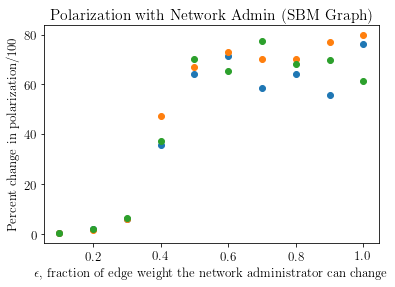

In [724]:
for t in range(num_trials):
    plt.plot(eps_list[1:], pls_ratio_list[t,1:] - 1,marker='o',linestyle="None")
    
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.xlabel('$\epsilon$, fraction of edge weight the network administrator can change')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (SBM Graph)')

plt.savefig('polarization_sbm.pdf')

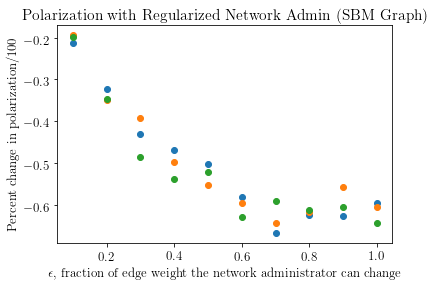

In [725]:
for t in range(num_trials):
    plt.plot(eps_list[1:], pls_ratio_fix_list[t,1:] - 1,marker='o',linestyle="None")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.xlabel('$\epsilon$, fraction of edge weight the network administrator can change')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Regularized Network Admin (SBM Graph)')

plt.savefig('polarization_sbm_fix.pdf')

Text(0, 0.5, 'Disagreement ratio')

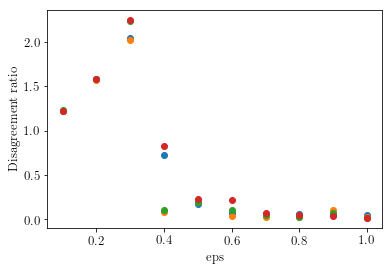

In [700]:
for t in range(num_trials):
    plt.plot(eps_list[1:], dis_ratio_list[t,1:],marker='o',linestyle="None")
plt.xlabel('eps')
plt.ylabel('Disagreement ratio')

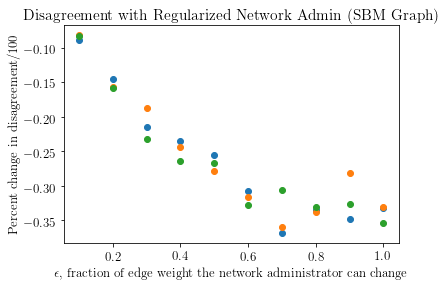

In [726]:
for t in range(num_trials):
    plt.plot(eps_list[1:], dis_ratio_fix_list[t,1:] - 1,marker='o',linestyle="None")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.xlabel('$\epsilon$, fraction of edge weight the network administrator can change')
plt.ylabel('Percent change in disagreement/100')
plt.title('Disagreement with Regularized Network Admin (SBM Graph)')

plt.savefig('disagreement_sbm_fix.pdf')

# Plot polarization vs p, and polarization vs change in opinions

## Polarization vs p, edge probability in between groups

In [9]:
# with degree constraint

lam = 0.35 # arbitrary value

q0=0.4
q1=0.4
n=40
m=40

num_p = 8
num_trials = 4 # 4 trials per prop

p_list=np.linspace(0,q0,num_p)
pls_list=np.zeros([num_trials, num_p])
pls_ratio_list=np.zeros([num_trials, num_p])
pls_before_list=np.zeros([num_trials, num_p])
for t in range(num_trials):
    for i in range(num_p):
        print("t: {}, i:{}".format(t,i))
        p = p_list[i]

        A,s=create_A_s(q0,q1,p,s0_mean=0.25, s1_mean=0.75, s_std=0.1,n=n,m=m)
        pls, objs, z, W = am(A,s,lam,constr=True,deg_constr=True)
        pls_list[t,i] = pls[-1]
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_before_list[t,i]=pls[0]

t: 0, i:0
t: 0, i:1
t: 0, i:2
t: 0, i:3
t: 0, i:4
t: 0, i:5
t: 0, i:6
t: 0, i:7
t: 1, i:0
t: 1, i:1
t: 1, i:2
t: 1, i:3
t: 1, i:4
t: 1, i:5
t: 1, i:6
t: 1, i:7
t: 2, i:0
t: 2, i:1
t: 2, i:2
t: 2, i:3
t: 2, i:4
t: 2, i:5
t: 2, i:6
t: 2, i:7
t: 3, i:0
t: 3, i:1
t: 3, i:2
t: 3, i:3
t: 3, i:4
t: 3, i:5
t: 3, i:6
t: 3, i:7


Make various plots

Text(0.5,0.98,'Degree-constrained')

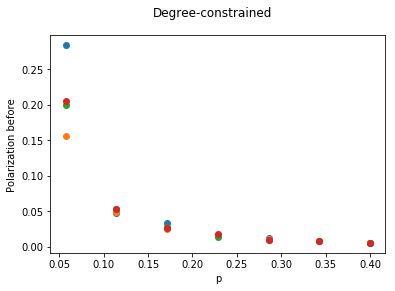

In [13]:
for t in range(num_trials):
    plt.plot(p_list[1:], pls_before_list[t,1:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization before')
plt.suptitle('Degree-constrained')

Text(0.5,0.98,'Degree-constrained')

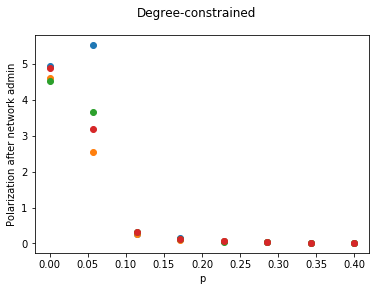

In [11]:
for t in range(num_trials):
    plt.plot(p_list, pls_list[t,:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization after network admin')
plt.suptitle('Degree-constrained')

Text(0.5,0.98,'Degree-constrained')

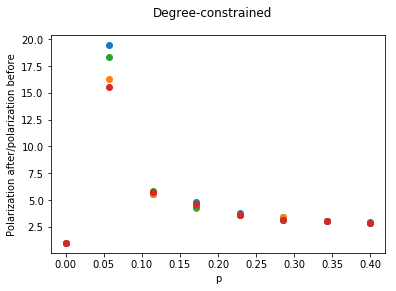

In [12]:
for t in range(num_trials):
    plt.plot(p_list, pls_ratio_list[t,:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization after/polarization before')
plt.suptitle('Degree-constrained')

### Recreate above plots, but with solution to reduce polarization

In [16]:
# let's recreate the same plots, but with our solution to reduce polarization?
# with degree constraint

lam = 0.35 # arbitrary value

q0=0.4
q1=0.4
n=40
m=40

gam=0.2 # let's try a small fixed regularization coefficient for now

num_p = 8
num_trials = 4 # 4 trials per prop

p_list=np.linspace(0,q0,num_p)
pls_list=np.zeros([num_trials, num_p])
pls_ratio_list=np.zeros([num_trials, num_p])
pls_before_list=np.zeros([num_trials, num_p])
for t in range(num_trials):
    for i in range(num_p):
        print("t: {}, i:{}".format(t,i))
        p = p_list[i]

        A,s=create_A_s(q0,q1,p,s0_mean=0.25, s1_mean=0.75, s_std=0.1,n=n,m=m)
        pls, objs, z, W = am(A,s,lam,constr=True,deg_constr=True, reduce_pls=True, gam=gam)
        pls_list[t,i] = pls[-1]
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_before_list[t,i]=pls[0]

t: 0, i:0
t: 0, i:1
t: 0, i:2
t: 0, i:3
t: 0, i:4
t: 0, i:5
t: 0, i:6
t: 0, i:7
t: 1, i:0
t: 1, i:1
t: 1, i:2
t: 1, i:3
t: 1, i:4
t: 1, i:5
t: 1, i:6
t: 1, i:7
t: 2, i:0
t: 2, i:1
t: 2, i:2
t: 2, i:3
t: 2, i:4
t: 2, i:5
t: 2, i:6
t: 2, i:7
t: 3, i:0
t: 3, i:1
t: 3, i:2
t: 3, i:3
t: 3, i:4
t: 3, i:5
t: 3, i:6
t: 3, i:7


Text(0.5,0.98,'Degree-constrained, with network admin fix')

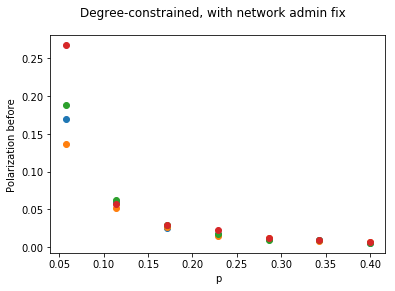

In [19]:
for t in range(num_trials):
    plt.plot(p_list[1:], pls_before_list[t,1:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization before')
plt.suptitle('Degree-constrained, with network admin fix')

Text(0.5,0.98,'Degree-constrained, with network admin fix')

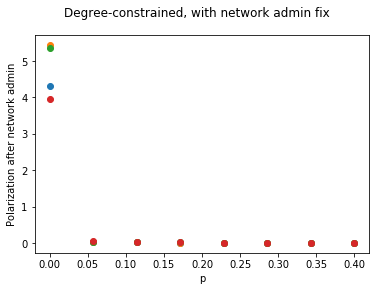

In [20]:
for t in range(num_trials):
    plt.plot(p_list, pls_list[t,:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization after network admin')
plt.suptitle('Degree-constrained, with network admin fix')

Text(0.5,0.98,'Degree-constrained')

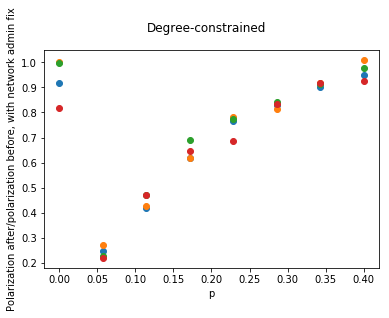

In [23]:
for t in range(num_trials):
    plt.plot(p_list, pls_ratio_list[t,:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization after/polarization before, with network admin fix')
plt.suptitle('Degree-constrained')

### Recreate above plots, but only changing existing edges

In [108]:
# let's recreate the same plots, but only changing existing edges

lam = 0.35 # arbitrary value

q0=0.4
q1=0.4
n=40
m=40

gam=0.2 # let's try a small fixed regularization coefficient for now

num_p = 8
num_trials = 4 # 4 trials per prop

p_list=np.linspace(0,q0,num_p)
pls_list=np.zeros([num_trials, num_p])
pls_ratio_list=np.zeros([num_trials, num_p])
pls_before_list=np.zeros([num_trials, num_p])
for t in range(num_trials):
    for i in range(num_p):
        print("t: {}, i:{}".format(t,i))
        p = p_list[i]

        A,s=create_A_s(q0,q1,p,s0_mean=0.25, s1_mean=0.75, s_std=0.1,n=n,m=m)
        pls, objs, z, W = am(A,s,lam,reduce_pls=False,existing=True)
        pls_list[t,i] = pls[-1]
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_before_list[t,i]=pls[0]

t: 0, i:0
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 629 columns and 1258 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-11, 7e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.01s
Presolved: 711 rows, 631 columns, 2519 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.308e+03
 Factor NZ  : 8.356e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.609e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.69978472e-02  0.00000000e+00  3.86e-01 1.00e-01  1.06e-01     0s
   1   

 AA' NZ     : 3.873e+03
 Factor NZ  : 9.458e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.124e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.47508452e+01  2.47508452e+01  9.63e-01 2.52e+00  2.52e+00     0s
   1   2.16351514e+01 -1.74109918e+02  1.86e-06 2.49e-03  1.34e-01     0s
   2   4.65018591e+00 -5.27945168e+00  2.47e-07 7.41e-05  6.74e-03     0s
   3   1.71456484e-01 -5.96336144e-01  4.92e-07 9.57e-06  5.24e-04     0s
   4   1.12753835e-01  1.99993848e-02  1.52e-06 1.16e-06  6.33e-05     0s
   5   1.10687797e-01  1.00396550e-01  1.47e-06 1.17e-07  7.02e-06     0s
   6   1.10598338e-01  1.10216989e-01  5.38e-08 2.62e-09  2.59e-07     0s
   7   1.10481456e-01  1.10463200e-01  5.43e-10 1.12e-10  1.24e-08     0s
   8   1.10479450e-01  1.10477282e-01  4.55e-13 7.71e-12  1.46e-09     0s
   9   1.10478330e-01  1.10478128e-01  1.25e-12 3.27e-13

   9   1.27051053e+00  1.26989881e+00  4.53e-09 1.50e-10  3.79e-07     0s
  10   1.27023522e+00  1.27016872e+00  5.68e-14 6.63e-12  4.12e-08     0s
  11   1.27019022e+00  1.27018742e+00  6.25e-13 7.46e-14  1.73e-09     0s
  12   1.27018957e+00  1.27018951e+00  5.29e-12 2.28e-11  3.53e-11     0s

Barrier solved model in 12 iterations and 0.08 seconds
Optimal objective 1.27018957e+00

t: 0, i:3
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 915 columns and 1830 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-10, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 997 rows, 917 columns, 3663 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier s

  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-10, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [8e+02, 8e+02]
Presolve time: 0.01s
Presolved: 1077 rows, 997 columns, 3983 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.138e+03
 Factor NZ  : 9.755e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.269e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.96520929e+00  1.96520929e+00  1.62e+00 1.08e-01  1.09e-01     0s
   1   1.84421446e+00 -9.58834307e+00  1.82e-06 1.00e-04  5.82e-03     0s
   2   8.91074495e-01 -7.85178539e-01  2.07e-06 1.14e-05  8.50e-04     0s
   3   7.24684641e-01  1.88793802e-01  8.62e-06 4.90e-07  2.69e-04     0s
   4   7.53807877e-01  4.63493250e-01  1.80

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05658898e+00  1.05658898e+00  1.58e-01 1.02e-01  1.07e-01     0s
   1   1.03293890e+00 -1.14652298e+01  1.85e-07 2.59e-04  6.01e-03     0s
   2   7.78326304e-01 -3.87712490e-01  2.87e-06 1.73e-05  5.55e-04     0s
   3   5.30878153e-01  6.17670038e-02  7.03e-06 1.49e-06  2.19e-04     0s
   4   5.04245817e-01  2.71242927e-01  3.57e-07 5.23e-07  1.09e-04     0s
   5   4.70303175e-01  3.31880433e-01  1.36e-07 3.45e-07  6.45e-05     0s
   6   4.64648354e-01  4.40905380e-01  5.41e-07 5.09e-08  1.11e-05     0s
   7   4.60552274e-01  4.57354232e-01  9.18e-08 3.73e-09  1.49e-06     0s
   8   4.59530897e-01  4.58945549e-01  5.57e-09 9.12e-10  2.72e-07     0s
   9   4.59361037e-01  4.59314276e-01  2.19e-10 3.05e-12  2.17e-08     0s
  10   4.59351745e-01  4.59348180e-01  5.12e-13 2.62e-14  1.66e-09     0s
  11   4.59349597e-01  4.59349234e-01  8.53e-13 2.18e-14  1.69e-10     0s

Barrier solved model in 11 iterations

   9   8.27324033e-02  8.26714435e-02  2.27e-13 1.62e-11  2.40e-08     0s
  10   8.26917088e-02  8.26893334e-02  2.27e-13 2.72e-13  9.33e-10     0s
  11   8.26910487e-02  8.26908437e-02  3.18e-12 2.83e-14  8.05e-11     0s

Barrier solved model in 11 iterations and 0.10 seconds
Optimal objective 8.26910487e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 1272 columns and 2544 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-11, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [1e+03, 1e+03]
Presolve time: 0.01s
Presolved: 1354 rows, 1274 columns, 5091 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.523e+03
 Factor NZ  : 1.001e+04 (rough

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [6e-11, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.01s
Presolved: 770 rows, 690 columns, 2755 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.603e+03
 Factor NZ  : 9.144e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.832e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.75736571e-01  0.00000000e+00  8.13e-01 1.01e-01  1.07e-01     0s
   1   1.74256778e-01 -7.73151699e+00  9.26e-07 1.10e-04  5.83e-03     0s
   2   1.55507311e-01 -1.18483268e+00  8.24e-07 1.81e-05  9.87e-04     0s
   3   8.72242026e-02 -9.01194777e-02  1.08e-05 1.54e-06  1.

   6   1.26096008e-01  4.77571372e-02  3.81e-07 1.95e-08  4.67e-05     0s
   7   1.16309507e-01  9.06082985e-02  1.27e-07 3.69e-09  1.53e-05     0s
   8   1.10425534e-01  1.05328231e-01  9.90e-09 8.42e-10  3.04e-06     0s
   9   1.09487490e-01  1.08285995e-01  2.84e-13 8.08e-11  7.16e-07     0s
  10   1.08790589e-01  1.08663519e-01  3.98e-13 2.22e-16  7.57e-08     0s
  11   1.08736832e-01  1.08732931e-01  8.53e-13 2.22e-16  2.32e-09     0s
  12   1.08734742e-01  1.08734294e-01  5.68e-14 4.77e-15  2.67e-10     0s

Barrier solved model in 12 iterations and 0.08 seconds
Optimal objective 1.08734742e-01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 838 columns and 1676 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-10, 4e-02]
  Bounds range     [0e+00, 0e+00]
  RHS r


Barrier solved model in 11 iterations and 0.09 seconds
Optimal objective 7.95411542e-01

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 923 columns and 1846 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-11, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1005 rows, 925 columns, 3695 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.778e+03
 Factor NZ  : 1.008e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.337e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time


Presolved: 1196 rows, 1116 columns, 4459 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.733e+03
 Factor NZ  : 1.022e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.208e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.31633276e-01  0.00000000e+00  4.41e-01 1.01e-01  1.07e-01     0s
   1   2.30442618e-01 -1.24582554e+01  4.90e-07 1.11e-04  5.78e-03     0s
   2   2.17705894e-01 -3.17790695e-01  1.50e-06 3.74e-06  2.43e-04     0s
   3   1.17555484e-01 -2.16813821e-02  1.37e-06 5.78e-07  6.29e-05     0s
   4   1.33013706e-01  1.90120538e-02  1.18e-06 3.46e-07  5.14e-05     0s
   5   1.12485240e-01  5.90009170e-02  5.51e-07 9.92e-08  2.41e-05     0s
   6   1.09986056e-01  6.90675703e-02  3.46e-07 7.24e-08  1.84e-05     0s
   7   1.04949599e-01  9.61623266e-02  6.92e-

   3   4.58098937e-01  2.72896405e-02  8.53e-06 1.03e-06  1.86e-04     0s
   4   4.50715318e-01  1.54293598e-01  9.15e-07 3.62e-07  1.28e-04     0s
   5   4.23142283e-01  2.59274443e-01  3.83e-07 2.32e-07  7.08e-05     0s
   6   4.03309495e-01  3.82236445e-01  5.47e-08 3.33e-08  9.10e-06     0s
   7   4.00570894e-01  3.98682942e-01  8.53e-13 2.24e-09  8.15e-07     0s
   8   4.00288414e-01  3.99946237e-01  1.76e-12 7.54e-11  1.47e-07     0s
   9   4.00163711e-01  4.00132549e-01  1.36e-12 1.70e-12  1.34e-08     0s
  10   4.00150315e-01  4.00147939e-01  1.14e-13 1.01e-13  1.02e-09     0s
  11   4.00149007e-01  4.00148785e-01  3.98e-13 3.53e-13  9.56e-11     0s

Barrier solved model in 11 iterations and 0.10 seconds
Optimal objective 4.00149007e-01

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 1160 columns and 2320 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1

   8   3.70401448e-01  3.41481673e-01  2.35e-08 2.75e-09  1.17e-05     0s
   9   3.67431857e-01  3.65438247e-01  3.92e-11 1.45e-10  8.03e-07     0s
  10   3.67279994e-01  3.67102279e-01  2.84e-13 4.14e-12  7.16e-08     0s
  11   3.67206697e-01  3.67177458e-01  6.82e-13 9.92e-13  1.18e-08     0s
  12   3.67199514e-01  3.67196456e-01  5.68e-13 1.12e-14  1.23e-09     0s
  13   3.67198287e-01  3.67197684e-01  3.41e-13 1.71e-13  2.43e-10     0s

Barrier solved model in 13 iterations and 0.10 seconds
Optimal objective 3.67198287e-01

t: 2, i:0
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 628 columns and 1256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-10, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+01]
  QRHS range       [5e+02, 5e+02]
Pre

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [7e-12, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 3e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.02s
Presolved: 796 rows, 716 columns, 2859 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.733e+03
 Factor NZ  : 9.807e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.305e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.00534507e+01  2.00534507e+01  7.37e-01 2.30e+00  2.29e+00     0s
   1   1.72535367e+01 -1.53897133e+02  1.49e-06 2.51e-03  1.22e-01     0s
   2   3.69426750e+00 -5.29415901e+00  3.18e-07 8.23e-05  6.35e-03     0s
   3   9.03512487e-02 -4.16

   2   2.42883275e+00 -2.92599235e+00  8.94e-08 4.56e-05  3.25e-03     0s
   3   1.40899590e+00  1.77505269e-01  3.22e-06 1.18e-06  7.40e-04     0s
   4   2.06799129e+00  6.04520958e-01  1.83e-09 5.53e-07  8.79e-04     0s
   5   1.66766963e+00  9.65177495e-01  4.55e-13 2.44e-08  4.22e-04     0s
   6   1.20857115e+00  1.09757438e+00  2.84e-13 2.60e-09  6.66e-05     0s
   7   1.16985524e+00  1.14575935e+00  1.14e-13 8.37e-10  1.45e-05     0s
   8   1.15965264e+00  1.15757318e+00  2.27e-13 6.66e-11  1.25e-06     0s
   9   1.15895595e+00  1.15874758e+00  5.68e-14 8.95e-12  1.25e-07     0s
  10   1.15890265e+00  1.15886712e+00  3.41e-13 1.02e-12  2.13e-08     0s
  11   1.15888590e+00  1.15888259e+00  2.61e-12 1.11e-10  1.99e-09     0s
  12   1.15888397e+00  1.15888351e+00  5.04e-11 2.20e-10  2.76e-10     0s

Barrier solved model in 12 iterations and 0.09 seconds
Optimal objective 1.15888397e+00

t: 2, i:3
iteration: 0
added variables
added first constraint
added second constraint
starting t

  12   1.13237986e-01  1.13237419e-01  4.55e-13 3.83e-15  2.87e-10     0s

Barrier solved model in 12 iterations and 0.09 seconds
Optimal objective 1.13237986e-01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 985 columns and 1970 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-10, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1067 rows, 987 columns, 3943 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.088e+03
 Factor NZ  : 9.969e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.260e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-10, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [9e+02, 9e+02]
Presolve time: 0.01s
Presolved: 1216 rows, 1136 columns, 4539 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.833e+03
 Factor NZ  : 1.014e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.152e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.23809175e+00  1.23809175e+00  4.49e-01 1.02e-01  1.07e-01     0s
   1   1.20474103e+00 -1.16680134e+01  4.55e-07 1.96e-04  5.83e-03     0s
   2   8.57420007e-01 -5.14843091e-01  1.31e-06 1.51e-05  6.17e-04     0s
   3   5.83152570e-01  1.02826933e-01  3.13e-06 1.49e-07  2.12e-04     0s
   4   5.68759190e-01  2.64469007e-01  2.8

   0   1.96733432e-01  0.00000000e+00  9.65e-01 1.00e-01  1.07e-01     0s
   1   1.96183199e-01 -1.47481029e+01  1.23e-06 1.10e-04  5.81e-03     0s
   2   1.90004710e-01 -3.92857722e-01  9.39e-07 3.71e-06  2.26e-04     0s
   3   1.11149419e-01 -6.24935742e-02  7.69e-06 8.35e-07  6.71e-05     0s
   4   1.27177966e-01  8.91030817e-03  6.53e-06 4.20e-07  4.56e-05     0s
   5   1.06465812e-01  5.55200647e-02  2.80e-06 1.59e-07  1.96e-05     0s
   6   1.04521234e-01  7.68062793e-02  1.28e-07 8.42e-08  1.07e-05     0s
   7   1.02674176e-01  9.14209975e-02  1.28e-09 3.50e-08  4.33e-06     0s
   8   1.02233125e-01  1.01800801e-01  6.04e-08 9.01e-10  1.66e-07     0s
   9   1.02191681e-01  1.02163955e-01  3.41e-13 9.49e-12  1.06e-08     0s
  10   1.02180608e-01  1.02179293e-01  9.09e-13 2.22e-15  5.03e-10     0s
  11   1.02180028e-01  1.02179919e-01  1.14e-13 5.94e-15  4.17e-11     0s

Barrier solved model in 11 iterations and 0.10 seconds
Optimal objective 1.02180028e-01

iteration: 1
added var

   9   1.01030289e-01  1.01024069e-01  5.12e-13 2.35e-11  4.75e-09     0s
  10   1.01027920e-01  1.01026880e-01  4.89e-12 1.18e-12  7.92e-10     0s

Barrier solved model in 10 iterations and 0.07 seconds
Optimal objective 1.01027920e-01

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 656 columns and 1312 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-10, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+01]
  QRHS range       [5e+02, 5e+02]
Presolve time: 0.01s
Presolved: 738 rows, 658 columns, 2627 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.443e+03
 Factor NZ  : 9.224e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.871e+05 (less than 1 second per iterati

 Dense cols : 1
 AA' NZ     : 4.058e+03
 Factor NZ  : 1.015e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.384e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.59386648e-01  0.00000000e+00  6.33e-01 1.07e-01  1.09e-01     0s
   1   5.39079082e-01 -8.38067654e+00  7.24e-07 1.13e-04  5.81e-03     0s
   2   3.82064007e-01 -3.27888704e-01  1.30e-07 6.38e-06  4.60e-04     0s
   3   2.14020128e-01 -2.55856064e-02  4.89e-06 1.09e-06  1.54e-04     0s
   4   1.67225177e-01  5.80717486e-02  1.64e-06 4.07e-07  7.03e-05     0s
   5   1.54013924e-01  6.61248561e-02  1.02e-06 3.50e-07  5.66e-05     0s
   6   1.48691072e-01  1.01193677e-01  5.04e-07 1.26e-07  3.05e-05     0s
   7   1.40352997e-01  1.24932120e-01  2.10e-07 1.55e-08  9.90e-06     0s
   8   1.35495043e-01  1.30561966e-01  2.83e-11 2.48e-09  3.16e-06     0s
   9   1.32498869e-01  1.32123173e-01  1

   1   2.30411442e+00 -1.52162944e+02  9.84e-07 2.22e-07  8.46e-02     0s
   2   2.07056182e+00 -2.42033554e+00  1.22e-06 5.41e-09  2.46e-03     0s
   3   1.10630213e+00 -3.23853807e-01  4.53e-07 1.01e-09  7.83e-04     0s
   4   1.03335430e+00  6.38473810e-02  3.34e-07 5.08e-10  5.31e-04     0s
   5   1.05380892e+00  2.67748303e-01  2.99e-07 3.13e-10  4.30e-04     0s
   6   9.61501968e-01  4.77065212e-01  1.83e-07 1.70e-10  2.65e-04     0s
   7   9.11506545e-01  7.16682013e-01  8.30e-08 4.37e-11  1.07e-04     0s
   8   8.94728809e-01  8.32306617e-01  1.47e-08 1.27e-11  3.42e-05     0s
   9   8.77770493e-01  8.55907876e-01  9.09e-13 3.99e-12  1.20e-05     0s
  10   8.74275038e-01  8.72676845e-01  6.40e-09 2.73e-12  8.75e-07     0s
  11   8.73433139e-01  8.73340038e-01  4.25e-11 1.78e-14  5.10e-08     0s
  12   8.73406798e-01  8.73400493e-01  4.55e-13 3.64e-14  3.45e-09     0s
  13   8.73404486e-01  8.73403346e-01  1.49e-11 1.50e-12  6.25e-10     0s

Barrier solved model in 13 iterations

   6   5.02965096e-01  4.64889843e-01  3.41e-13 3.25e-08  1.89e-05     0s
   7   5.01476288e-01  4.98445829e-01  7.39e-13 2.22e-09  1.50e-06     0s
   8   5.00872931e-01  5.00464469e-01  1.65e-12 7.60e-11  2.03e-07     0s
   9   5.00692999e-01  5.00630426e-01  9.66e-13 2.96e-12  3.10e-08     0s
  10   5.00662035e-01  5.00655253e-01  1.59e-12 2.86e-13  3.36e-09     0s
  11   5.00658104e-01  5.00657302e-01  1.48e-12 2.82e-12  3.98e-10     0s

Barrier solved model in 11 iterations and 0.12 seconds
Optimal objective 5.00658104e-01

t: 3, i:5
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 1073 columns and 2146 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-10, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [8e+02, 8e+02]
Pr


Barrier solved model in 12 iterations and 0.10 seconds
Optimal objective 1.08331522e-01

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 1189 columns and 2378 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-09, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [9e+02, 9e+02]
Presolve time: 0.01s
Presolved: 1271 rows, 1191 columns, 4759 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.108e+03
 Factor NZ  : 1.005e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.090e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Tim

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-10, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
  QRHS range       [1e+03, 1e+03]
Presolve time: 0.01s
Presolved: 1352 rows, 1272 columns, 5083 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.513e+03
 Factor NZ  : 1.007e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.180e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.67914526e-01  0.00000000e+00  4.09e-01 1.04e-01  1.63e+00     0s
   1   6.05101001e-01 -1.18426130e+02  7.55e-07 9.47e-05  4.69e-02     0s
   2   5.95303413e-01 -8.06346962e-01  1.91e-06 8.41e-07  5.52e-04     0s
   3   3.54624869e-01 -7.

Text(0.5, 0.98, 'Only changing existing edges')

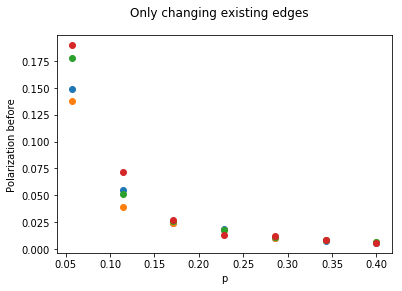

In [109]:
for t in range(num_trials):
    plt.plot(p_list[1:], pls_before_list[t,1:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization before')
plt.suptitle('Only changing existing edges')

Text(0.5, 0.98, 'Only changing existing edges')

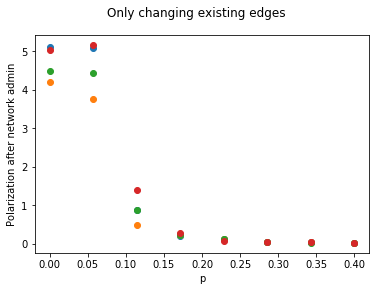

In [110]:
for t in range(num_trials):
    plt.plot(p_list, pls_list[t,:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization after network admin')
plt.suptitle('Only changing existing edges')

Text(0.5, 0.98, 'Only changing existing edges')

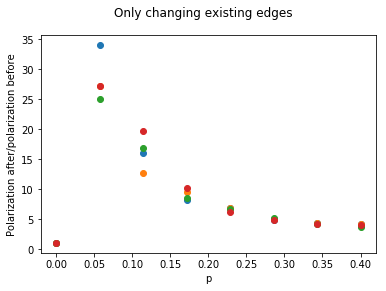

In [111]:
for t in range(num_trials):
    plt.plot(p_list, pls_ratio_list[t,:],marker='o',linestyle="None")
plt.xlabel('p')
plt.ylabel('Polarization after/polarization before')
plt.suptitle('Only changing existing edges')

# i think for small p, you aren't connected to *enough* people in the opposing cluster, so the network admin
# 

## Polarization vs difference in means

In [26]:
# with degree constrained

lam = 0.35 # arbitrary value

q0=0.4
q1=0.4
p=0.2 # arbitrary value
n=40
m=40

num_diffs = 11
num_trials = 4 # 5 trials per prop

mean_diff_list=np.linspace(0,0.9,num_diffs)

pls_list=np.zeros([num_trials, num_diffs])
pls_ratio_list=np.zeros([num_trials, num_diffs])
pls_before_list=np.zeros([num_trials, num_diffs])
for t in range(num_trials):
    for i in range(num_diffs):
        print("t: {}, i:{}".format(t,i))
        half_diff=mean_diff_list[i] / 2.0

        A,s=create_A_s(q0,q1,p,s0_mean=0.5-half_diff, s1_mean=0.5+half_diff, s_std=0.1,n=n,m=m)
        pls, objs, z, W = am(A,s,lam,constr=True,deg_constr=True)
        pls_list[t,i] = pls[-1]
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_before_list[t,i]=pls[0]

t: 0, i:0
t: 0, i:1
t: 0, i:2
t: 0, i:3
t: 0, i:4
t: 0, i:5
t: 0, i:6
t: 0, i:7
t: 0, i:8
t: 0, i:9
t: 0, i:10
t: 1, i:0
t: 1, i:1
t: 1, i:2
t: 1, i:3
t: 1, i:4
t: 1, i:5
t: 1, i:6
t: 1, i:7
t: 1, i:8
t: 1, i:9
t: 1, i:10
t: 2, i:0
t: 2, i:1
t: 2, i:2
t: 2, i:3
t: 2, i:4
t: 2, i:5
t: 2, i:6
t: 2, i:7
t: 2, i:8
t: 2, i:9
t: 2, i:10
t: 3, i:0
t: 3, i:1
t: 3, i:2
t: 3, i:3
t: 3, i:4
t: 3, i:5
t: 3, i:6
t: 3, i:7
t: 3, i:8
t: 3, i:9
t: 3, i:10


Text(0.5,0.98,'Degree-constrained')

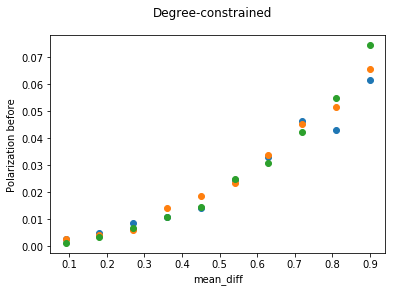

In [35]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_before_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization before')
plt.suptitle('Degree-constrained')

Text(0.5,0.98,'Degree-constrained')

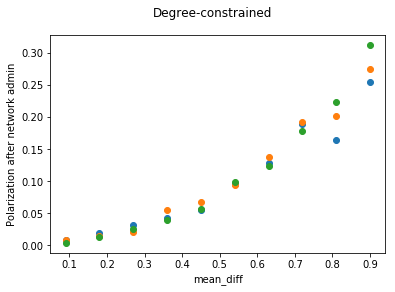

In [36]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization after network admin')
plt.suptitle('Degree-constrained')

Text(0.5,0.98,'Degree-constrained')

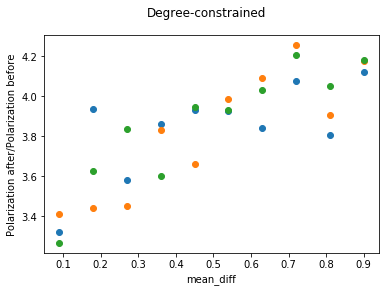

In [37]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_ratio_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization after/Polarization before')
plt.suptitle('Degree-constrained')
# no clear pattern... but it's high

### Recreate above plots, but with solution to reduce polarization

In [38]:
# with degree constrained

lam = 0.35 # arbitrary value

q0=0.4
q1=0.4
p=0.2 # arbitrary value
n=40
m=40

gam=0.2 # arbitrary value

num_diffs = 10
num_trials = 3

mean_diff_list=np.linspace(0,0.9,num_diffs)

pls_list=np.zeros([num_trials, num_diffs])
pls_ratio_list=np.zeros([num_trials, num_diffs])
pls_before_list=np.zeros([num_trials, num_diffs])
for t in range(num_trials):
    for i in range(num_diffs):
        print("t: {}, i:{}".format(t,i))
        half_diff=mean_diff_list[i] / 2.0

        A,s=create_A_s(q0,q1,p,s0_mean=0.5-half_diff, s1_mean=0.5+half_diff, s_std=0.1,n=n,m=m)
        pls, objs, z, W = am(A,s,lam,constr=True,deg_constr=True, reduce_pls=True, gam=gam)
        pls_list[t,i] = pls[-1]
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_before_list[t,i]=pls[0]

t: 0, i:0
t: 0, i:1
t: 0, i:2
t: 0, i:3
t: 0, i:4
t: 0, i:5
t: 0, i:6
t: 0, i:7
t: 0, i:8
t: 0, i:9
t: 1, i:0
t: 1, i:1
t: 1, i:2
t: 1, i:3
t: 1, i:4
t: 1, i:5
t: 1, i:6
t: 1, i:7
t: 1, i:8
t: 1, i:9
t: 2, i:0
t: 2, i:1
t: 2, i:2
t: 2, i:3
t: 2, i:4
t: 2, i:5
t: 2, i:6
t: 2, i:7
t: 2, i:8
t: 2, i:9


Text(0.5,0.98,'Degree-constrained, with network admin fix')

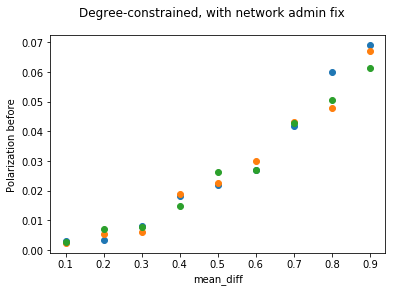

In [39]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_before_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization before')
plt.suptitle('Degree-constrained, with network admin fix')

Text(0.5,0.98,'Degree-constrained, with network admin fix')

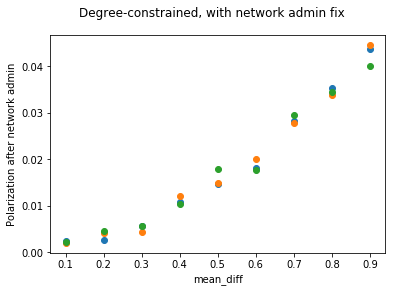

In [40]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization after network admin')
plt.suptitle('Degree-constrained, with network admin fix') # WHOOPS, this plot actually does not have NA fix

Text(0.5,0.98,'Degree-constrained, with network admin fix')

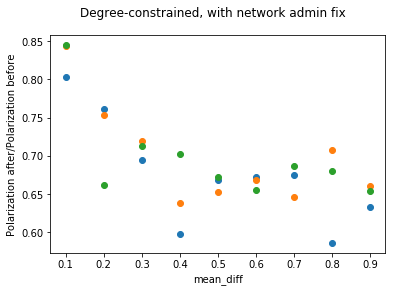

In [41]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_ratio_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization after/Polarization before')
plt.suptitle('Degree-constrained, with network admin fix') # WHOOPS, this plot actually does not have NA fix
# no clear pattern... but it's high

### Recreate above plots, but only changing edges in the network

In [112]:
# with degree constrained

lam = 0.35 # arbitrary value

q0=0.4
q1=0.4
p=0.2 # arbitrary value
n=40
m=40

gam=0.2 # arbitrary value

num_diffs = 10
num_trials = 3

mean_diff_list=np.linspace(0,0.9,num_diffs)

pls_list=np.zeros([num_trials, num_diffs])
pls_ratio_list=np.zeros([num_trials, num_diffs])
pls_before_list=np.zeros([num_trials, num_diffs])
for t in range(num_trials):
    for i in range(num_diffs):
        print("t: {}, i:{}".format(t,i))
        half_diff=mean_diff_list[i] / 2.0

        A,s=create_A_s(q0,q1,p,s0_mean=0.5-half_diff, s1_mean=0.5+half_diff, s_std=0.1,n=n,m=m)
        pls, objs, z, W = am(A,s,lam,reduce_pls=False,existing=True)
        pls_list[t,i] = pls[-1]
        pls_ratio_list[t,i] = pls[-1] * 1.0 / pls[0]
        pls_before_list[t,i]=pls[0]

t: 0, i:0
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 967 columns and 1934 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [4e-13, 5e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1049 rows, 969 columns, 3871 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.998e+03
 Factor NZ  : 9.565e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.190e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.84252620e-02  0.00000000e+00  1.23e+00 1.00e-01  1.06e-01     0s
   1  

   0   1.98026996e-01  0.00000000e+00  1.10e+00 1.01e-01  1.07e-01     0s
   1   1.96891554e-01 -1.07697529e+01  1.24e-06 1.10e-04  5.82e-03     0s
   2   1.84888791e-01 -5.01715273e-01  1.53e-06 6.17e-06  3.64e-04     0s
   3   1.01298849e-01 -4.43034303e-02  2.79e-06 8.41e-07  7.68e-05     0s
   4   1.21735097e-01  6.71287387e-03  1.85e-06 4.96e-07  6.06e-05     0s
   5   9.23743710e-02  3.06675720e-02  7.55e-07 3.04e-07  3.25e-05     0s
   6   8.82689013e-02  6.88201613e-02  7.49e-08 8.74e-08  1.02e-05     0s
   7   8.69957745e-02  7.68017766e-02  3.68e-11 4.83e-08  5.37e-06     0s
   8   8.65096178e-02  8.55369683e-02  2.27e-13 2.84e-09  5.11e-07     0s
   9   8.61507014e-02  8.61235931e-02  2.84e-13 9.25e-11  1.43e-08     0s
  10   8.61474476e-02  8.61458609e-02  7.96e-13 5.62e-12  8.34e-10     0s
  11   8.61472842e-02  8.61466040e-02  3.87e-12 2.44e-12  3.58e-10     0s

Barrier solved model in 11 iterations and 0.09 seconds
Optimal objective 8.61472842e-02

iteration: 2
added var

   5   1.16155876e-01  2.13977896e-02  2.97e-11 7.11e-08  5.04e-05     0s
   6   1.14974942e-01  8.85370588e-02  5.12e-13 1.71e-08  1.40e-05     0s
   7   1.11767154e-01  1.03306180e-01  5.68e-13 5.30e-09  4.50e-06     0s
   8   1.10593860e-01  1.08860228e-01  1.71e-13 9.76e-10  9.21e-07     0s
   9   1.10411602e-01  1.10314512e-01  3.98e-13 2.47e-11  5.16e-08     0s
  10   1.10387328e-01  1.10385130e-01  1.14e-13 5.61e-14  1.17e-09     0s
  11   1.10386404e-01  1.10386285e-01  1.59e-12 3.15e-14  6.29e-11     0s

Barrier solved model in 11 iterations and 0.10 seconds
Optimal objective 1.10386404e-01

t: 0, i:3
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 946 columns and 1892 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [4e-10, 1e-03]
  Bounds range     [0e+00, 0e+0

  11   8.36885596e-02  8.36785819e-02  5.68e-13 2.08e-13  5.24e-09     0s
  12   8.36876532e-02  8.36864787e-02  1.82e-12 1.31e-14  6.16e-10     0s
  13   8.36870375e-02  8.36868013e-02  5.68e-13 8.33e-15  1.24e-10     0s

Barrier solved model in 13 iterations and 0.10 seconds
Optimal objective 8.36870375e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 952 columns and 1904 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-11, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1034 rows, 954 columns, 3811 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.923e+03
 Factor NZ  : 9.830e+03 (roughly

added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 936 columns and 1872 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-09, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1018 rows, 938 columns, 3747 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.843e+03
 Factor NZ  : 9.726e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.214e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.82986656e+00  2.82986656e+00  5.09e-01 1.60e-01  1.59e-01     0s
   1   2.62841429e+00 -1.29234773e+01  6.01e-


Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.718e+03
 Factor NZ  : 9.535e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.245e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.10464309e-01  0.00000000e+00  6.61e-01 1.06e-01  1.08e-01     0s
   1   5.96583102e-01 -9.81210597e+00  6.24e-07 1.14e-04  5.80e-03     0s
   2   4.70851847e-01 -3.15242306e-01  7.17e-07 5.90e-06  4.36e-04     0s
   3   2.78018897e-01 -2.60288277e-02  2.97e-07 1.09e-06  1.68e-04     0s
   4   2.53414715e-01  3.86148911e-02  1.48e-07 4.49e-07  1.18e-04     0s
   5   2.42063803e-01  6.63088603e-02  5.47e-08 3.50e-07  9.66e-05     0s
   6   2.27852846e-01  1.24413922e-01  1.29e-08 1.97e-07  5.69e-05     0s
   7   2.17594199e-01  2.04219199e-01  1.78e-07 2.24e-08  7.35e-06     0s
   8   2.15473654e-01  2.13537639e-01  1.39e-08 3.44e-09  1.06e-06     0s
   9   2.15045702e-

   2   3.39579543e+00 -1.33923030e+01  4.14e-07 4.71e-13  9.07e-03     0s
   3   2.12346217e+00 -7.18938423e-01  1.66e-07 3.65e-14  1.54e-03     0s
   4   2.27808300e+00  5.46798973e-01  1.44e-07 1.51e-14  9.36e-04     0s
   5   2.07250955e+00  8.65535867e-01  8.31e-08 1.07e-14  6.52e-04     0s
   6   2.03086798e+00  1.56386647e+00  4.18e-08 1.78e-15  2.52e-04     0s
   7   1.99300711e+00  1.87206296e+00  9.66e-13 1.78e-15  6.54e-05     0s
   8   1.94717965e+00  1.93896041e+00  1.71e-13 3.55e-15  4.44e-06     0s
   9   1.94465822e+00  1.94356358e+00  9.66e-13 1.60e-14  5.92e-07     0s
  10   1.94446379e+00  1.94428765e+00  1.02e-12 8.35e-14  9.52e-08     0s
  11   1.94439614e+00  1.94437556e+00  3.98e-13 3.55e-15  1.11e-08     0s
  12   1.94438430e+00  1.94438298e+00  1.14e-13 6.04e-14  7.14e-10     0s

Barrier solved model in 12 iterations and 0.09 seconds
Optimal objective 1.94438430e+00

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize

   8   1.93248684e+00  1.92341343e+00  2.73e-12 2.43e-13  4.76e-06     0s
   9   1.93097523e+00  1.93008820e+00  3.98e-13 7.11e-15  4.65e-07     0s
  10   1.93092187e+00  1.93088017e+00  2.27e-13 1.60e-14  2.19e-08     0s
  11   1.93089930e+00  1.93089783e+00  1.19e-12 1.07e-14  7.75e-10     0s

Barrier solved model in 11 iterations and 0.09 seconds
Optimal objective 1.93089930e+00

t: 1, i:0
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 968 columns and 1936 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-11, 3e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1050 rows, 970 columns, 3875 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-10, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1049 rows, 969 columns, 3871 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.998e+03
 Factor NZ  : 9.911e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.213e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.62894436e-01  0.00000000e+00  2.52e+00 1.00e-01  1.07e-01     0s
   1   1.62256677e-01 -1.10304304e+01  2.81e-06 1.10e-04  5.87e-03     0s
   2   1.55506084e-01 -4.24727675e-01  2.12e-06 5.11e-06  3.04e-04     0s
   3   9.22888723e-02 -4.98903759e-02  2.50e-06 8.54e-07  7

 Dense cols : 1
 AA' NZ     : 4.948e+03
 Factor NZ  : 9.920e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.273e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.60120301e-01  0.00000000e+00  4.04e+00 1.02e-01  3.41e+00     0s
   1   2.89761362e-01 -9.24935212e+01  6.73e-06 8.03e-05  4.85e-02     0s
   2   2.85708451e-01 -4.83707448e-01  3.65e-06 5.77e-07  4.02e-04     0s
   3   1.64517573e-01 -4.90602438e-02  7.06e-07 1.09e-07  1.12e-04     0s
   4   1.76633828e-01  1.55267043e-02  6.62e-07 5.83e-08  8.41e-05     0s
   5   1.66386305e-01  4.03281722e-02  4.77e-07 4.09e-08  6.58e-05     0s
   6   1.53998227e-01  6.73906059e-02  2.89e-07 2.59e-08  4.52e-05     0s
   7   1.46836822e-01  1.07424714e-01  1.07e-07 1.07e-08  2.06e-05     0s
   8   1.46317001e-01  1.36862834e-01  6.25e-13 2.04e-09  4.94e-06     0s
   9   1.43209866e-01  1.41806346e-01  2

   3   1.00379766e-01 -4.45723990e-02  4.22e-08 9.42e-07  7.89e-05     0s
   4   1.14597556e-01  7.59888513e-03  3.49e-08 5.20e-07  5.81e-05     0s
   5   8.96917029e-02  4.33568310e-02  1.51e-08 1.91e-07  2.51e-05     0s
   6   8.56176926e-02  6.39897941e-02  6.22e-09 7.41e-08  1.17e-05     0s
   7   8.35651401e-02  7.92329466e-02  5.97e-10 5.65e-09  2.34e-06     0s
   8   8.28186263e-02  8.11036234e-02  9.09e-13 2.60e-09  9.27e-07     0s
   9   8.25540804e-02  8.20851686e-02  5.12e-13 1.35e-10  2.53e-07     0s
  10   8.22668405e-02  8.21991171e-02  1.14e-13 2.22e-16  3.65e-08     0s
  11   8.22272189e-02  8.22101428e-02  2.27e-13 4.44e-16  9.21e-09     0s
  12   8.22148885e-02  8.22106771e-02  5.68e-13 7.77e-16  2.27e-09     0s
  13   8.22144452e-02  8.22142075e-02  1.48e-12 5.05e-15  1.28e-10     0s

Barrier solved model in 13 iterations and 0.09 seconds
Optimal objective 8.22144452e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize

  10   6.34903185e-01  6.34876714e-01  5.24e-11 4.44e-16  1.34e-08     0s
  11   6.34900727e-01  6.34899147e-01  7.39e-13 4.17e-14  7.98e-10     0s

Barrier solved model in 11 iterations and 0.08 seconds
Optimal objective 6.34900727e-01

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 989 columns and 1978 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-11, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1071 rows, 991 columns, 3959 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.108e+03
 Factor NZ  : 9.892e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.250e+05 (less than 1 second per iterat


Barrier solved model in 14 iterations and 0.10 seconds
Optimal objective 1.16918663e+00

t: 1, i:7
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 930 columns and 1860 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-11, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.02s
Presolved: 1012 rows, 932 columns, 3723 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.813e+03
 Factor NZ  : 9.738e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.261e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl

  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-08, 3e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1024 rows, 944 columns, 3771 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.873e+03
 Factor NZ  : 9.626e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.238e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.28841176e+00  5.28841176e+00  1.46e+00 2.86e-01  2.85e-01     0s
   1   4.92355253e+00 -2.32610628e+01  1.71e-06 2.60e-04  1.51e-02     0s
   2   2.17901342e+00 -2.51811759e+00  5.80e-08 4.31e-05  2.52e-03     0s
   3   1.90892540e+00  8.33806608e-01  3.47e-05 9.63e-07  5.71e-04     0s
   4   1.80702858e+00  1.29349292e+00  3.39


Barrier statistics:
 Dense cols : 1
 AA' NZ     : 5.223e+03
 Factor NZ  : 1.011e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.288e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.57133955e+00  6.57133955e+00  1.54e-01 3.53e-01  1.45e+00     0s
   1   5.86136580e+00 -2.47697892e+02  3.65e-06 1.73e-04  1.25e-01     0s
   2   5.21143939e+00 -4.29011063e+00  3.85e-06 5.37e-06  4.69e-03     0s
   3   2.59982092e+00 -8.25021456e-02  1.32e-06 4.96e-07  1.32e-03     0s
   4   2.38205929e+00  3.60617296e-01  7.95e-07 2.15e-07  9.98e-04     0s
   5   2.48359826e+00  9.18086911e-01  1.24e-07 1.31e-07  7.73e-04     0s
   6   2.19966734e+00  1.18371440e+00  5.75e-08 9.48e-08  5.02e-04     0s
   7   2.10130745e+00  1.91553878e+00  7.81e-11 1.31e-08  9.17e-05     0s
   8   2.07585552e+00  2.05014562e+00  5.68e-14 2.08e-09  1.27e-05     0s
   9   2.07133040e+

   1   3.39813465e-02 -1.09221583e+01  5.98e-07 1.10e-04  5.80e-03     0s
   2   3.36658626e-02 -1.12722646e-01  1.66e-06 1.28e-06  7.73e-05     0s
   3   1.94692993e-02 -7.74460757e-03  1.93e-12 1.46e-07  1.43e-05     0s
   4   2.15214583e-02  2.88784833e-03  1.19e-12 7.33e-08  9.76e-06     0s
   5   1.80144751e-02  7.05197871e-03  4.55e-13 4.71e-08  5.75e-06     0s
   6   1.71240448e-02  1.44277090e-02  1.14e-13 1.22e-08  1.41e-06     0s
   7   1.67098857e-02  1.63634235e-02  8.53e-13 6.71e-10  1.81e-07     0s
   8   1.66481130e-02  1.66230840e-02  5.68e-13 5.50e-11  1.31e-08     0s
   9   1.66390030e-02  1.66371066e-02  5.12e-13 4.24e-13  9.88e-10     0s
  10   1.66381046e-02  1.66380041e-02  3.98e-13 1.03e-15  5.23e-11     0s

Barrier solved model in 10 iterations and 0.08 seconds
Optimal objective 1.66381046e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 959 columns and 1918 nonzeros
Model has 1 

  11   1.93130630e-01  1.93130350e-01  5.12e-13 1.19e-13  1.48e-10     0s

Barrier solved model in 11 iterations and 0.08 seconds
Optimal objective 1.93130630e-01

iteration: 2
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 945 columns and 1890 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-10, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.02s
Presolved: 1027 rows, 947 columns, 3783 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.888e+03
 Factor NZ  : 9.842e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.224e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual


added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 922 columns and 1844 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-11, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1004 rows, 924 columns, 3691 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.773e+03
 Factor NZ  : 1.037e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.376e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.18487616e-01  0.00000000e+00  2.54e-01 1.01e-01  1.07e-01     0s
   1   2.16907785e-01 -1.0291

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.16214043e+00  2.16214043e+00  1.82e+00 1.17e-01  1.17e-01     0s
   1   2.01248420e+00 -9.40654707e+00  2.04e-06 1.01e-04  6.21e-03     0s
   2   8.89625751e-01 -1.05297024e+00  1.46e-06 1.52e-05  1.05e-03     0s
   3   8.30830401e-01  2.93520250e-01  1.83e-05 1.58e-06  2.90e-04     0s
   4   7.56375223e-01  4.35938191e-01  2.94e-06 1.06e-06  1.73e-04     0s
   5   7.41618177e-01  5.81206771e-01  2.24e-06 5.49e-07  8.66e-05     0s
   6   7.31078773e-01  7.18859276e-01  3.82e-07 4.14e-08  6.59e-06     0s
   7   7.29471558e-01  7.28404536e-01  6.24e-08 2.82e-09  5.75e-07     0s
   8   7.29291603e-01  7.29166198e-01  9.35e-10 2.15e-10  6.75e-08     0s
   9   7.29243704e-01  7.29240990e-01  1.79e-11 1.00e-12  1.46e-09     0s
  10   7.29241964e-01  7.29241845e-01  1.76e-12 2.85e-13  6.40e-11     0s

Barrier solved model in 10 iterations and 0.09 seconds
Optimal objective 7.29241964e-01

iteration: 2
added var

   8   9.14046600e-01  9.13219796e-01  2.84e-13 1.78e-15  4.18e-07     0s
   9   9.13519504e-01  9.13477153e-01  1.14e-13 3.55e-15  2.14e-08     0s
  10   9.13501872e-01  9.13498707e-01  2.27e-13 8.88e-16  1.60e-09     0s
  11   9.13500308e-01  9.13500149e-01  9.66e-13 2.58e-12  8.05e-11     0s

Barrier solved model in 11 iterations and 0.10 seconds
Optimal objective 9.13500308e-01

t: 2, i:7
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 80 rows, 967 columns and 1934 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-10, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.01s
Presolved: 1049 rows, 969 columns, 3871 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier 

  Objective range  [5e-10, 3e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [7e+02, 7e+02]
Presolve time: 0.02s
Presolved: 1012 rows, 932 columns, 3723 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 4.813e+03
 Factor NZ  : 9.923e+03 (roughly 1 MByte of memory)
 Factor Ops : 2.286e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.52519561e+00  5.52519561e+00  4.17e-01 3.11e-01  3.10e-01     0s
   1   5.14046192e+00 -2.47569837e+01  4.65e-07 9.95e-04  1.68e-02     0s
   2   2.23996792e+00 -2.79432685e+00  6.44e-07 1.40e-04  2.81e-03     0s
   3   1.83939262e+00  6.09456832e-01  9.37e-06 3.12e-06  6.63e-04     0s
   4   1.75548658e+00  1.25882340e+00  8.02e-06 1.25e-06  2.68e-04     0s
   5   1.72752617e+00  1.62474600e+00

   3   2.19832299e+00  9.36718738e-01  5.38e-05 2.59e-06  7.01e-04     0s
   4   2.16326899e+00  1.90417514e+00  6.64e-06 4.20e-07  1.44e-04     0s
   5   2.15256266e+00  2.08975837e+00  7.28e-12 3.79e-08  3.48e-05     0s
   6   2.12848537e+00  2.12203951e+00  1.18e-07 1.58e-09  3.57e-06     0s
   7   2.12557811e+00  2.12523973e+00  6.27e-09 8.00e-11  1.87e-07     0s
   8   2.12543960e+00  2.12539173e+00  3.64e-10 1.56e-11  2.65e-08     0s
   9   2.12542335e+00  2.12540943e+00  1.96e-11 1.91e-11  7.71e-09     0s
  10   2.12542207e+00  2.12541415e+00  4.73e-11 1.17e-09  4.39e-09     0s
  11   2.12542196e+00  2.12542115e+00  3.30e-12 2.23e-10  4.52e-10     0s

Barrier solved model in 11 iterations and 0.08 seconds
Optimal objective 2.12542196e+00



Text(0.5, 0.98, 'only changing existing edges')

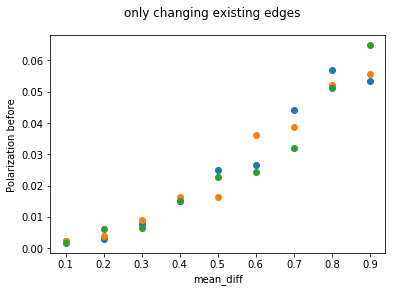

In [113]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_before_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization before')
plt.suptitle('only changing existing edges')

Text(0.5, 0.98, 'only changing existing edges')

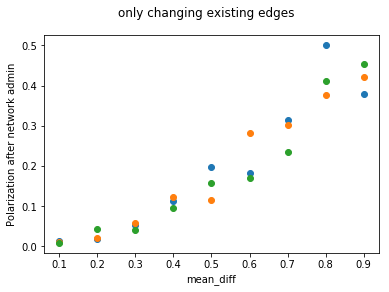

In [114]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization after network admin')
plt.suptitle('only changing existing edges')

Text(0.5, 0.98, 'only changing existing edges')

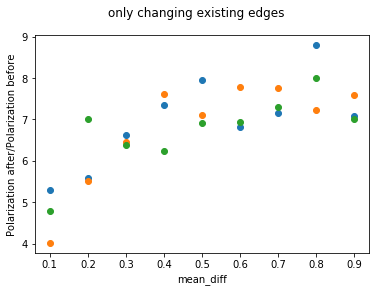

In [115]:
for t in range(num_trials):
    plt.plot(mean_diff_list[1:], pls_ratio_list[t,1:],marker='o',linestyle="None")
plt.xlabel('mean_diff')
plt.ylabel('Polarization after/Polarization before')
plt.suptitle('only changing existing edges')

# Working with real networks

## Load Reddit

In [268]:
# load adjacency matrix
n_reddit=556
A = np.zeros([n_reddit, n_reddit])
z_dict={i:[] for i in range(n_reddit)}

with open('Reddit/edges_reddit.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v in reader:
        A[int(u)-1,int(v)-1] += 1
        A[int(v)-1,int(u)-1] += 1

# load opinions
with open('Reddit/reddit_opinion.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v,w in reader:
        z_dict[int(u)-1].append(float(w))

# remove nodes not ocnnected in graph
not_connected = np.argwhere(np.sum(A,0)==0)
A=np.delete(A,not_connected,axis=0)
A=np.delete(A,not_connected,axis=1)
n_reddit = n_reddit-len(not_connected)

# create z (avg-ing posts)
z = [np.mean(z_dict[i]) for i in range(n_reddit)]
z=np.array(z)

# create initial opinions from z
L = np.diag(np.sum(A,0)) - A
s = (L+np.eye(n_reddit)).dot(z)
s=np.minimum(np.maximum(s,0),1)

In [16]:
#lam_list = [0.1,0.2,0.3,0.4,0.5]
lam_list = [0.6,0.7,0.8,0.9,1.0]
res_dict={}
res2_dict={}

max_iter=7
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    res_dict[lam] = (pls,disaggs,z,W)
    res2_dict[lam] = (pls2,disaggs2,z2,W2)

no fix
lam: 0.6
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [6e-15, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.37s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.206e+05
 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.80858912e-01  6.80858912e-01  7.16e+01 1.01e-01  

  22   5.08802400e+00  5.08761635e+00  2.05e-12 3.14e-10  1.34e-09    70s
  23   5.08794274e+00  5.08786843e+00  1.19e-12 6.24e-11  2.43e-10    73s
  24   5.08791221e+00  5.08789974e+00  3.69e-12 8.92e-11  4.08e-11    76s
  25   5.08790252e+00  5.08790072e+00  1.57e-10 9.16e-11  5.90e-12    80s

Barrier solved model in 25 iterations and 79.70 seconds
Optimal objective 5.08790252e+00

iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [1e-14, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.38s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barr

   9   6.95696851e+01 -3.08390199e+02  4.25e-06 9.56e-12  1.24e-03    34s
  10   2.64779561e+01 -2.35307192e+02  3.64e-12 7.47e-12  8.58e-04    37s
  11   2.18913149e+01 -1.96199310e+02  1.82e-12 6.26e-12  7.14e-04    41s
  12   1.54181177e+01 -1.17590162e+02  4.49e-12 3.94e-12  4.36e-04    44s
  13   1.27026090e+01 -4.71832322e+01  5.68e-13 1.73e-12  1.96e-04    47s
  14   7.98968363e+00 -2.86055486e+01  7.96e-13 1.22e-12  1.20e-04    51s
  15   6.40213478e+00 -1.41136638e+01  1.42e-12 6.90e-13  6.72e-05    54s
  16   4.35692198e+00 -4.67539262e+00  2.67e-12 7.19e-11  2.96e-05    58s
  17   3.46778788e+00 -1.16525605e+00  4.55e-13 1.52e-10  1.52e-05    61s
  18   2.90492276e+00  1.01731243e+00  8.53e-13 3.10e-11  6.18e-06    65s
  19   2.70774182e+00  1.62792588e+00  2.27e-12 1.69e-11  3.54e-06    68s
  20   2.65591123e+00  2.32677124e+00  1.82e-12 2.98e-11  1.08e-06    72s
  21   2.62005941e+00  2.56137207e+00  4.55e-13 1.88e-11  1.92e-07    76s
  22   2.61304254e+00  2.60263728e+00 

  79   1.76718172e+00  1.47157880e+00  6.32e-11 9.69e-08  9.68e-07   291s
  80   1.75488609e+00  1.49240014e+00  1.40e-10 8.60e-08  8.60e-07   295s
  81   1.74480655e+00  1.50998168e+00  2.67e-11 7.75e-08  7.69e-07   299s
  82   1.73292100e+00  1.53006757e+00  2.84e-11 6.71e-08  6.65e-07   302s
  83   1.72669220e+00  1.54056673e+00  2.38e-11 6.16e-08  6.10e-07   305s
  84   1.71996071e+00  1.55163899e+00  2.05e-11 5.54e-08  5.51e-07   309s
  85   1.71642590e+00  1.55748682e+00  1.86e-11 5.23e-08  5.21e-07   313s
  86   1.71300806e+00  1.56303296e+00  1.98e-11 4.60e-08  4.91e-07   316s
  87   1.71115377e+00  1.56605297e+00  1.77e-11 4.45e-08  4.75e-07   320s
  88   1.70970250e+00  1.56839337e+00  2.11e-11 2.62e-08  4.63e-07   324s
  89   1.70864658e+00  1.57019978e+00  4.43e-11 2.94e-08  4.54e-07   328s
  90   1.70488650e+00  1.57610717e+00  3.63e-11 2.50e-08  4.22e-07   332s
  91   1.70244294e+00  1.58005814e+00  2.84e-11 2.37e-08  4.01e-07   336s
  92   1.70048981e+00  1.58319499e+00 

   7   1.83750732e+02 -7.17948755e+02  3.00e-01 9.13e-13  1.01e-02   112s
   8   1.70241318e+02 -4.71415755e+02  1.74e-01 1.63e-13  5.34e-03   126s
   9   1.77240650e+02 -2.00156104e+02  9.83e-02 5.12e-13  2.53e-03   140s
  10   1.82092337e+02  1.42891639e+01  5.92e-02 5.85e-12  1.02e-03   154s
  11   1.87567566e+02  1.17482919e+02  2.57e-02 3.35e-11  3.29e-04   168s
  12   1.92267270e+02  1.52193526e+02  1.25e-03 1.40e-10  9.38e-05   184s
  13   1.92327077e+02  1.67954784e+02  5.73e-04 7.60e-11  5.52e-05   200s
  14   1.91669494e+02  1.72841439e+02  3.53e-04 8.88e-11  4.22e-05   215s
  15   1.91354322e+02  1.85657377e+02  2.81e-05 8.35e-10  1.24e-05   231s
  16   1.90901171e+02  1.90179797e+02  3.11e-11 7.56e-11  1.58e-06   247s
  17   1.90698151e+02  1.90635005e+02  5.68e-13 7.11e-13  1.38e-07   263s
  18   1.90689417e+02  1.90677483e+02  1.88e-12 2.33e-11  2.61e-08   279s
  19   1.90687496e+02  1.90683221e+02  1.39e-12 8.67e-12  9.34e-09   294s
  20   1.90687183e+02  1.90686942e+02 

  11   2.22768421e+01 -3.96934804e+00  1.65e-04 9.35e-06  8.63e-05    41s
  12   2.01161017e+01 -1.30735495e+00  1.40e-04 6.79e-06  7.04e-05    44s
  13   1.58959160e+01 -3.41997780e-01  1.02e-04 5.70e-06  5.34e-05    48s
  14   1.42198036e+01  1.32714160e+00  8.15e-05 4.00e-06  4.24e-05    51s
  15   9.86728390e+00  2.95361854e+00  4.40e-05 2.20e-06  2.27e-05    55s
  16   6.15852190e+00  4.10643049e+00  9.51e-06 8.81e-07  6.76e-06    58s
  17   5.18630860e+00  4.78137531e+00  1.67e-06 2.59e-07  1.34e-06    61s
  18   5.08741537e+00  5.01957930e+00  2.48e-07 4.70e-08  2.24e-07    64s
  19   5.07751727e+00  5.05774176e+00  3.36e-08 1.54e-08  6.54e-08    67s
  20   5.07655844e+00  5.07464301e+00  1.64e-08 3.12e-09  6.34e-09    71s
  21   5.07646948e+00  5.07614100e+00  6.42e-09 1.92e-10  1.08e-09    74s
  22   5.07640395e+00  5.07636269e+00  2.58e-09 8.29e-12  1.35e-10    78s
  23   5.07637553e+00  5.07636509e+00  7.06e-10 2.11e-10  3.42e-11    82s
  24   5.07636901e+00  5.07636737e+00 

   8   7.61532413e+01 -1.88105099e+02  6.32e-04 1.56e-04  8.71e-04    27s
   9   4.95555418e+01 -5.16369031e+01  5.08e-04 4.68e-05  3.33e-04    30s
  10   3.09409046e+01 -3.34411294e+01  2.66e-04 3.37e-05  2.12e-04    33s
  11   1.11184719e+01 -2.30461939e+01  7.70e-06 2.59e-05  1.13e-04    36s
  12   7.04520360e+00 -1.19534716e+01  3.17e-06 1.62e-05  6.29e-05    39s
  13   5.04468846e+00 -7.42776990e-01  1.21e-05 4.57e-06  1.91e-05    43s
  14   4.04320707e+00  1.98115866e+00  1.04e-05 1.75e-06  6.82e-06    46s
  15   3.78872502e+00  2.88639553e+00  1.12e-06 8.35e-07  2.99e-06    49s
  16   3.72642277e+00  3.47886829e+00  1.70e-07 2.41e-07  8.21e-07    52s
  17   3.70233937e+00  3.64593576e+00  2.13e-07 5.45e-08  1.87e-07    56s
  18   3.69889571e+00  3.68431391e+00  1.50e-07 1.15e-08  4.83e-08    59s
  19   3.69725107e+00  3.69480371e+00  3.96e-08 1.93e-09  8.11e-09    63s
  20   3.69695549e+00  3.69680034e+00  1.79e-09 2.09e-10  5.14e-10    66s
  21   3.69693886e+00  3.69692002e+00 

   5   6.50070405e+02 -1.01271315e+04  7.54e-02 7.26e-03  3.56e-02    16s
   6   5.06462313e+02 -1.09157486e+03  3.95e-03 8.97e-04  5.27e-03    18s
   7   2.40950608e+02 -7.03198243e+02  1.73e-04 6.00e-04  3.11e-03    21s
   8   1.07299578e+02 -2.08655500e+02  1.74e-03 1.87e-04  1.04e-03    23s
   9   5.05588849e+01 -8.36285881e+01  3.01e-04 7.81e-05  4.42e-04    26s
  10   2.23158964e+01 -6.28151511e+01  1.10e-04 6.07e-05  2.81e-04    29s
  11   1.46885814e+01 -3.44318886e+01  6.79e-05 3.55e-05  1.62e-04    31s
  12   6.72888471e+00 -2.27779815e+01  2.65e-05 2.45e-05  9.76e-05    34s
  13   4.75901023e+00 -1.41728055e+01  1.41e-05 1.62e-05  6.26e-05    36s
  14   3.68327858e+00 -1.01852855e+01  1.26e-05 1.22e-05  4.59e-05    39s
  15   1.80225804e+00 -6.38490893e+00  9.91e-07 8.23e-06  2.71e-05    41s
  16   1.54673552e+00 -3.73808561e+00  4.43e-06 5.32e-06  1.75e-05    43s
  17   1.29633312e+00 -1.78541005e+00  3.01e-06 3.19e-06  1.02e-05    46s
  18   1.08375665e+00 -2.07169463e-02 

   3   6.88519797e-01 -8.82186333e+02  7.36e-02 4.47e-03  6.42e-03    11s
   4   6.83969335e-01 -2.48411222e+02  8.23e-05 7.55e-05  8.19e-04    13s
   5   6.77296064e-01 -1.12994047e+01  9.46e-07 3.46e-06  3.94e-05    16s
   6   5.66332994e-01 -1.44563250e+00  8.62e-08 4.49e-07  6.61e-06    20s
   7   2.96070160e-01 -3.97092256e-01  3.70e-10 1.35e-07  2.28e-06    24s
   8   1.28100136e-01 -7.77532506e-02  2.91e-13 3.90e-08  6.76e-07    27s
   9   8.98862559e-02 -2.36359016e-02  1.11e-12 1.61e-08  3.72e-07    30s
  10   8.27669532e-02 -1.05981013e-02  4.16e-10 1.15e-08  3.06e-07    33s
  11   7.29234767e-02 -7.32054447e-03  3.70e-10 1.01e-08  2.63e-07    36s
  12   6.31290537e-02 -5.12483356e-03  3.00e-10 8.58e-09  2.24e-07    39s
  13   5.61962038e-02 -3.27120349e-03  2.56e-10 7.64e-09  1.95e-07    42s
  14   4.45575519e-02 -1.06240117e-03  1.94e-10 6.16e-09  1.50e-07    45s
  15   3.19053878e-02  1.22058219e-03  1.18e-10 5.09e-09  1.01e-07    48s
  16   2.07957074e-02  2.58509672e-03 

 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.43770144e+02  6.43770144e+02  8.97e+01 3.04e+01  1.15e+03     3s
   1   4.08768357e+02 -2.29012091e+05  1.26e+01 3.65e+00  1.62e+02     6s
   2   7.64561422e+02 -2.39939736e+05  2.27e+00 2.33e+00  3.00e+01     8s
   3   5.59427350e+02 -2.41109002e+05  5.30e-02 1.62e+00  1.52e+00    11s
   4   5.96821790e+02 -5.96186124e+04  1.33e-06 1.40e-02  1.98e-01    13s
   5   5.78473381e+02 -1.44358016e+04  6.13e-03 3.40e-03  4.93e-02    16s
   6   5.06658130e+02 -2.49288303e+03  2.16e-04 5.89e-04  9.85e-03    19s
   7   2.79158121e+02 -5.16977776e+02  3.33e-04 1.39e-04  2.61e-03    21s
   8   1.33438813e+02 -1.85174496e+02  5.47e-04 5.60e-05  1.05e-03    24s
   9   5.96859259e+01 -6.20205508e+01  2.69e-05 2.39e-05  4.00e-04    27s
  1

Optimal objective 1.74111134e+00

iteration: 6
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [3e-13, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.37s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.206e+05
 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.01004940e+02  9.01004938e+02  8

Model has 152628 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [3e-15, 2e-03]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.49s
Presolved: 305812 rows, 305260 columns, 772114 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.393e+06
 Factor NZ  : 1.852e+06 (roughly 260 MBytes of memory)
 Factor Ops : 6.697e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.98488569e-01  6.98488575e-01  8.97e+01 1.01e-01  2.76e+00    16s
   1   1.33004816e+00 -8.52551095e+02  2.54e+01 9.26e-03  7.82e-01    40s
   2   2.565

added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [1e-12, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [6e+03, 6e+03]
Presolve time: 0.37s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.206e+05
 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.34681568e+02  7.34681568e+02  1.22e+02 3.53e+01  1.82e+03     3s
   1   3.63296490e+02 -2.65103229e+05  1.75e+01 4.28

  22   7.48521435e-01  7.48487662e-01  7.73e-12 1.72e-12  1.11e-10    72s
  23   7.48512629e-01  7.48511501e-01  1.92e-11 5.38e-12  3.70e-12    75s

Barrier solved model in 23 iterations and 75.17 seconds
Optimal objective 7.48512629e-01

iteration: 5
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [7e-14, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [6e+03, 6e+03]
Presolve time: 0.36s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.206e+05
 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 

  15   3.96749917e-01 -8.91270658e-01  2.73e-12 2.72e-08  4.22e-06    53s
  16   2.92962981e-01 -3.41399054e-01  6.36e-07 1.40e-08  2.08e-06    57s
  17   2.75344938e-01  3.42012566e-02  1.96e-07 5.12e-09  7.90e-07    60s
  18   2.59533148e-01  1.25721598e-01  3.98e-12 2.98e-09  4.38e-07    63s
  19   2.53948389e-01  2.11225928e-01  6.48e-12 9.24e-10  1.40e-07    67s
  20   2.50544653e-01  2.35725245e-01  3.75e-12 3.31e-10  4.86e-08    70s
  21   2.49647186e-01  2.46996480e-01  6.93e-12 6.00e-11  8.69e-09    73s
  22   2.49438656e-01  2.48504564e-01  1.57e-11 2.62e-11  3.06e-09    76s
  23   2.49406786e-01  2.49304460e-01  1.00e-11 3.31e-11  3.35e-10    80s
  24   2.49398310e-01  2.49391773e-01  3.18e-11 2.17e-10  2.14e-11    83s
  25   2.49396882e-01  2.49396694e-01  5.32e-11 1.73e-10  6.16e-13    87s

Barrier solved model in 25 iterations and 87.03 seconds
Optimal objective 2.49396882e-01

with fix
lam: 0.9
iteration: 0
added variables
added first constraint
added second constraint
s

  16   4.69141156e-03  1.13330993e-03  1.44e-10 8.87e-12  1.17e-08    54s
  17   3.50652973e-03  1.82721892e-03  6.07e-11 3.94e-12  5.50e-09    58s
  18   2.63483611e-03  2.13724008e-03  1.00e-11 2.25e-12  1.63e-09    61s
  19   2.46489252e-03  2.34974696e-03  5.00e-12 7.25e-13  3.77e-10    65s
  20   2.43644752e-03  2.42411396e-03  1.59e-12 7.97e-14  4.04e-11    68s
  21   2.43339654e-03  2.43266333e-03  3.16e-10 2.43e-15  2.40e-12    72s

Barrier solved model in 21 iterations and 71.68 seconds
Optimal objective 2.43339654e-03

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [6e-11, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [1e+04, 1e+04]
Presol

  14   8.94744721e-01 -5.54338090e-01  1.11e-11 5.97e-11  4.75e-06    46s
  15   7.60695097e-01 -1.42508868e-01  2.27e-12 4.03e-11  2.96e-06    49s
  16   6.80629756e-01  3.99419753e-01  9.09e-13 1.18e-11  9.21e-07    53s
  17   6.33914079e-01  5.32665883e-01  1.11e-11 5.61e-12  3.32e-07    55s
  18   6.24919372e-01  6.09202170e-01  5.23e-12 1.17e-12  5.15e-08    59s
  19   6.22637051e-01  6.18628744e-01  1.14e-12 5.40e-13  1.31e-08    62s
  20   6.22415258e-01  6.21857556e-01  4.55e-12 2.83e-11  1.83e-09    65s
  21   6.22366713e-01  6.22292120e-01  4.77e-12 3.49e-12  2.44e-10    69s
  22   6.22358646e-01  6.22352886e-01  6.59e-12 3.99e-11  1.89e-11    72s
  23   6.22357391e-01  6.22357096e-01  1.48e-11 5.58e-11  9.67e-13    75s

Barrier solved model in 23 iterations and 74.95 seconds
Optimal objective 6.22357391e-01

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model

   8   8.01790421e+01 -6.00885266e+01  2.49e-13 2.07e-09  4.60e-04    26s
   9   2.15971747e+01 -2.79076513e+01  6.59e-12 1.10e-09  1.62e-04    29s
  10   6.45614555e+00 -1.16664589e+01  1.62e-12 5.52e-10  5.94e-05    33s
  11   1.79919786e+00 -3.73298282e+00  5.68e-12 1.92e-10  1.81e-05    36s
  12   1.25867897e+00 -1.70767633e+00  2.18e-11 9.64e-11  9.72e-06    40s
  13   6.02911853e-01 -1.11341436e+00  6.14e-12 6.93e-11  5.62e-06    43s
  14   3.61199298e-01 -7.13524229e-01  9.55e-12 5.10e-11  3.52e-06    45s
  15   3.09092519e-01 -2.46748656e-01  4.55e-12 2.59e-11  1.82e-06    48s
  16   2.60707895e-01  9.24117662e-02  1.21e-11 7.60e-12  5.51e-07    52s
  17   2.45216943e-01  1.31762697e-01  2.27e-12 5.06e-12  3.72e-07    55s
  18   2.42236453e-01  1.99231630e-01  3.87e-12 1.85e-12  1.41e-07    58s
  19   2.39875336e-01  2.18460525e-01  8.64e-12 1.16e-12  7.02e-08    61s
  20   2.38719863e-01  2.34777339e-01  3.64e-12 5.39e-12  1.29e-08    64s
  21   2.38367700e-01  2.38129705e-01 

   8   1.66229076e+02  1.22357583e+02  1.04e-04 5.97e-12  9.58e-05   133s
   9   1.65621189e+02  1.40555499e+02  5.81e-06 7.50e-12  5.47e-05   152s
  10   1.65208866e+02  1.62251981e+02  7.44e-07 9.58e-12  6.46e-06   166s
  11   1.65083588e+02  1.64320858e+02  2.59e-08 2.49e-10  1.67e-06   181s
  12   1.65055229e+02  1.64989387e+02  3.41e-09 2.16e-11  1.44e-07   203s
  13   1.65049658e+02  1.65045109e+02  3.69e-09 4.52e-12  9.93e-09   223s
  14   1.65049364e+02  1.65049195e+02  9.53e-10 1.37e-11  3.67e-10   238s
  15   1.65049364e+02  1.65049321e+02  6.13e-04 1.81e-07  9.30e-11   252s

Barrier solved model in 15 iterations and 252.44 seconds
Optimal objective 1.65049364e+02



In [17]:
with open('reddit_res_fix_disagg_large_lam.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([res_dict, res2_dict], f)

### Analyze Reddit Results

In [269]:
with open('reddit_res_fix_disagg_small_lam.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    rd,rd_fix= pickle.load(f,encoding='latin1')

with open('reddit_res_fix_disagg_large_lam.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    rd_large,rd_fix_large= pickle.load(f,encoding='latin1')

In [270]:
rd[0.5]

([0.021230221799620683,
  0.9218160707524723,
  1.0587974958198263,
  1.3225784151627842,
  2.766976339676927,
  8.533003189850561,
  12.626738022100428,
  13.845325756653146,
  14.112144088487595],
 [0.6835581574269673,
  3.803186808651516,
  3.9995021458497155,
  4.225668267319346,
  4.6677445211491655,
  3.405680904835154,
  1.4924601058179954,
  0.8903852151977584,
  0.8863154265886728],
 array([0.6525798 , 0.85467099, 0.41235061, 0.4321557 , 0.4178457 ,
        0.4153784 , 0.47198194, 0.422171  , 0.41884529, 0.40067114,
        0.86004184, 0.40756675, 0.40921599, 0.42104873, 0.41143585,
        0.84564594, 0.42120224, 0.41651924, 0.42280051, 0.42707112,
        0.3963022 , 0.41769955, 0.40185163, 0.42181979, 0.42468286,
        0.42022646, 0.41077357, 0.41947806, 0.41249143, 0.42450954,
        0.42012228, 0.41747621, 0.41168556, 0.41580624, 0.41288279,
        0.65576957, 0.41275881, 0.42241675, 0.4228593 , 0.41748191,
        0.40013252, 0.41400189, 0.83259143, 0.40707132, 0.420

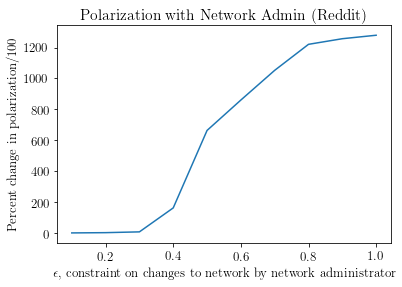

In [292]:
lam1vals=[0.1,0.2,0.3,0.4,0.5]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals+lam2vals

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        pls = rd[lam][0]
    else:
        pls = rd_large[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (Reddit)')

plt.savefig('polarization_reddit.pdf')

# HUGE increase in polarization

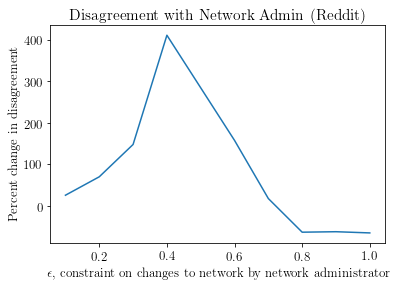

In [287]:
lam1vals=[0.1,0.2,0.3,0.4]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals+lam2vals

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam < 0.5:
        dis = rd[lam][1]
    else:
        dis = rd_large[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Network Admin (Reddit)')

plt.savefig('disagreement_reddit.pdf')

# wow, disagreement increases a lot too!

In [99]:
polar=rd[0.4][0][-1]
disagg = rd[0.4][1][-1]
z=rd[0.4][2]
W=rd[0.4][3]

s_centered = s - np.mean(s)

In [113]:
np.mean(s)-np.mean(z)

-6.106226635438361e-16

In [114]:
ic = np.linalg.norm(z-s)**2
print(ic)

18.988559421478012


In [116]:
print(polar+2*disagg+ic)

29.44621991771375


In [115]:
print(s_centered.T.dot(s_centered))

29.446219917714217


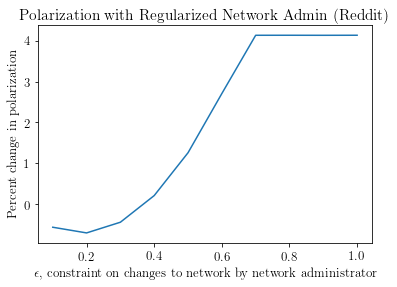

In [288]:
# same plots, but with network fix
lam1vals=[0.1,0.2,0.3,0.4,0.5]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals+lam2vals

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        pls = rd_fix[lam][0]
    else:
        pls = rd_fix_large[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization')
plt.title('Polarization with Regularized Network Admin (Reddit)')
    
plt.savefig('polarization_reddit_fix.pdf')

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)

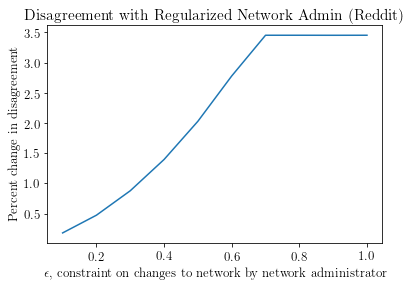

In [289]:
lam1vals=[0.1,0.2,0.3,0.4,0.5]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals+lam2vals

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        dis = rd_fix[lam][1]
    else:
        dis = rd_fix_large[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Regularized Network Admin (Reddit)')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig('disagreement_reddit_fix.pdf')

# okay, so disagreement more-or-less stays the same!

In [57]:
disagg_ratio_list

array([0.99997793, 0.99995846, 0.99994172, 0.99992676, 0.99990318,
       0.99989548, 0.99989547, 0.99989546, 0.99989547])

### Visualize some of reddit results

In [593]:
def vis_params(W,z_op,layout='spring'):
    G = nx.Graph(W)
    # filter edges?
    fedges = [edge for edge in G.edges() if W[edge] < 0.1]
    G.remove_edges_from(fedges)
    
    # filter vertices?
#     to_remove=[node for node,degree in G.degree() if degree < 2]
#     G.remove_nodes_from(to_remove)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z_op[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors, emin, emax, vmin, vmax,width=0.5,node_size=150):
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, cmap=plt.cm.coolwarm, vmin=vmin,vmax=vmax, width=width, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)

In [675]:
# rd, rd_fix, 
# rd_large, rd_large_fix

# don't plot _every_ edge... only some subset
inds = np.random.choice(range(n_reddit),size=100,replace=False)

# filter out singleton nodes
inds = [i for i in inds if np.sum(A[i,inds]) > 3]
print(len(inds))

Ga, posa, edge_colors_a, node_colors_a = vis_params(A[np.ix_(inds,inds)], z[inds])

# plot lam=0.2, 0.4, 0.6
z1=rd[0.2][2][inds]
W1=rd[0.2][3][np.ix_(inds,inds)]

z2=rd[0.4][2][inds]
W2=rd[0.4][3][np.ix_(inds,inds)]

z3=rd_large[0.6][2][inds]
W3=rd_large[0.6][3][np.ix_(inds,inds)]

G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1)
G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W3, z3)

86


In [676]:
len(np.where(z2>0.5)[0]) / len(inds)

0.23255813953488372

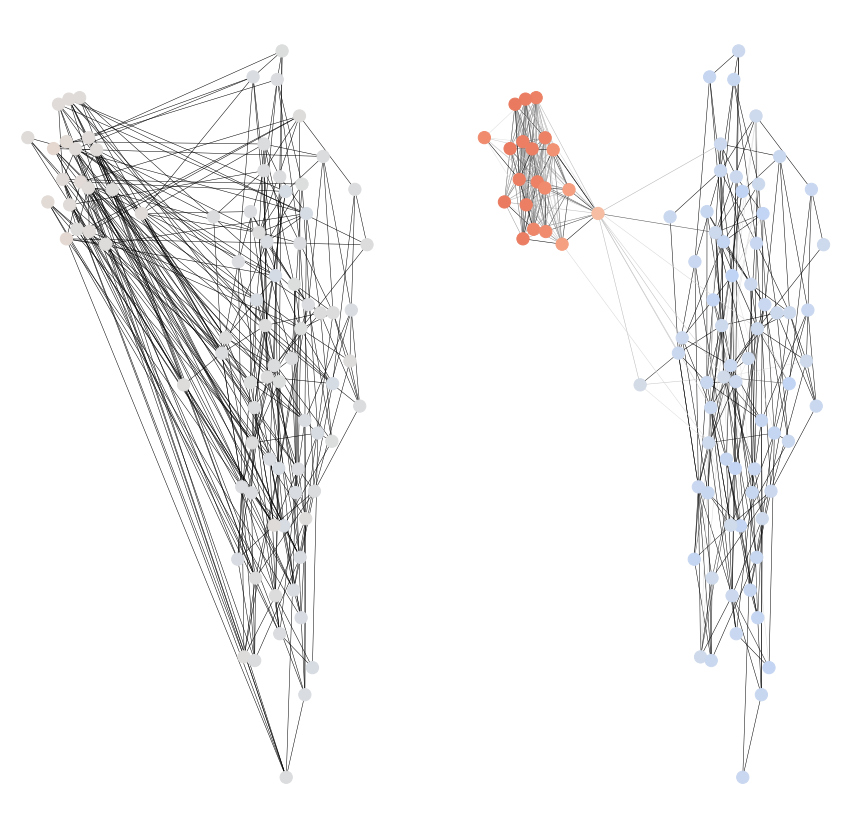

In [678]:
emin=0
emax=1.0

# otherwise all the nodes are super grey
vmin=0.2
vmax=0.8

f, axs = plt.subplots(1,2,figsize=(15,15))

pos=pos2

plt.subplot(121)
plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin, vmax)

plt.subplot(122)
plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin, vmax)

# plt.subplot(221)
# plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin, vmax)
# plt.subplot(222)
# plot_graph(G1, pos, node_colors_1, edge_colors_1, emin, emax, vmin, vmax)
# plt.subplot(223)
# plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin, vmax)
# plt.subplot(224)
# plot_graph(G3, pos, node_colors_3, edge_colors_3, emin, emax, vmin, vmax)

plt.savefig('reddit_plot_example2.pdf')

### Estimate q, p for Reddit

In [614]:
q0 = np.where(s > 0.5)[0]
q1 = np.where(s < 0.5)[0]

# how many connections between groups
between_groups = 0
in_0 = 0
in_1 = 0

for u in range(n_reddit):
    for v in range(n_reddit):
        if A[u,v] > 0:
            
            if (u in q0 and v in q1) or (u in q1 and v in q0):
                between_groups += 1
            elif (u in q0 and v in q0):
                in_0 += 1
            else:
                in_1 += 1

between_groups /= 2
in_0 /= 2
in_1 /= 2

q0_est = in_0 / (len(q0)**2 / 2)
q1_est = in_1 / (len(q1)**2 / 2)

p_est = between_groups / (len(q0) * len(q1))
print(q0_est)
print(q1_est)
print(p_est)
print('')
print(in_0)
print(in_1)
print(between_groups)
print('')
print(len(q0))
print(len(q1))
# group 0: x people vs group 1: ax people, a > 1

# in some subreddit: n ppl vs n ppl

# n^2/x^2 in group 0
# vs n^2/(a^2 x^2)  in group 1
# vs  n^2 / (ax^2) between groups

# (1/2) * (n^2 /x^2 + n^2/(a^2 x^2)) <= n^2 / (ax^2)

# (1/2) * (1 + 1/(a^2)) <= 1 / (a)
# 1 + (1/a^2) <= 2/a
# a^2 - 2a + 1 <= 0
# (a-1)^2 <= 0




# group 0: 5
# group 1: 10

# group 0: 1 more person
# edge density in group 0: + 1/5
# edge density in between groups: +10/50

0.05877739331026528
0.052767893338137924
0.06204763784708514

1911.0
2343.0
4715.0

255
298


In [59]:
# compute initial polarization
compute_pls(z)

# run AM game
# lam = 0.10
# pls, objs, z, W = am(A,s2,lam,constr=True,deg_constr=True,reduce_pls=False,gam=0)

0.027623181894585153

## load Twitter


In [727]:
# load adjacency matrix
n_twitter=548
A = np.zeros([n_twitter, n_twitter])
z_dict={i:[] for i in range(n_twitter)}

with open('Twitter/edges_twitter.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v in reader:
        A[int(u)-1,int(v)-1] = 1
        A[int(v)-1,int(u)-1] = 1

# load opinions
with open('Twitter/twitter_opinion.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v,w in reader:
        z_dict[int(u)-1].append(float(w))

# remove nodes not ocnnected in graph
not_connected = np.argwhere(np.sum(A,0)==0)
A=np.delete(A,not_connected,axis=0)
A=np.delete(A,not_connected,axis=1)
n_twitter = n_twitter-len(not_connected)

# choose z, derive s
z = [np.mean(z_dict[i]) for i in range(n_twitter)]
z=np.array(z)

L = np.diag(np.sum(A,0)) - A
s = (L+np.eye(n_twitter)).dot(z)
s=np.minimum(np.maximum(s,0),1)

In [729]:
lam_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
res_dict={}
res2_dict={}

max_iter=8
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    res_dict[lam] = (pls,disaggs,z,W)
    res2_dict[lam] = (pls2,disaggs2,z2,W2)

with open('twitter_res_all.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([res_dict, res2_dict], f)

no fix
lam: 0.1
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.41s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12769933e+00  1.12769933e+00  7.60e+01 2.56e-01  


Barrier solved model in 24 iterations and 69.93 seconds
Optimal objective 1.33169719e+00

iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-15, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.35s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

  15   1.49662103e+00  1.16757490e+00  4.77e-12 1.06e-10  1.10e-06    43s
  16   1.43530428e+00  1.22375721e+00  4.77e-12 5.41e-11  7.06e-07    46s
  17   1.39236701e+00  1.26422180e+00  1.82e-12 2.18e-11  4.27e-07    49s
  18   1.34281287e+00  1.27640613e+00  3.41e-12 6.24e-12  2.22e-07    51s
  19   1.31679313e+00  1.28689111e+00  2.96e-12 1.09e-11  9.98e-08    54s
  20   1.29997234e+00  1.29037507e+00  5.00e-12 1.68e-11  3.20e-08    57s
  21   1.29621449e+00  1.29299759e+00  2.96e-12 9.22e-11  1.07e-08    60s
  22   1.29539541e+00  1.29454275e+00  1.82e-12 3.14e-11  2.84e-09    64s
  23   1.29527975e+00  1.29512364e+00  1.82e-12 1.35e-10  5.21e-10    67s
  24   1.29524500e+00  1.29522758e+00  3.66e-11 5.84e-10  5.81e-11    69s
  25   1.29524020e+00  1.29523660e+00  6.23e-10 3.11e-10  1.20e-11    72s
  26   1.29523824e+00  1.29523723e+00  2.16e-10 3.69e-10  3.37e-12    75s

Barrier solved model in 26 iterations and 74.67 seconds
Optimal objective 1.29523824e+00

iteration: 6
added va

Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.68842107e+00  3.68842108e+00  7.60e+01 1.17e+00  3.72e+01     3s
   1  -3.68907968e+00 -3.43264055e+03  1.13e+01 1.29e-01  5.57e+00     5s
   2   6.84475954e+00 -3.77463984e+03  3.88e+00 1.41e-07  1.94e+00     8s
   3  -4.63910187e-01 -3.48981478e+03  7.66e-01 1.43e-13  3.90e-01    10s
   4   4.14283150e+00 -2.23235988e+03  1.59e-01 8.81e-13  8.45e-02    12s
   5   3.56578707e+00 -9.27386079e+02  2.65e-02 1.55e-11  1.45e-02    15s
   6   3.74365935e+00 -4.48679755e+02  1.72e-03 8.19e-10  2.18e-03    18s
   7   3.73258824e+00 -5.12322212e+01  2.29e-05 2.81e-10  1.83e-04    20s
   8   3.66905808e

  11   1.98308750e+02 -6.07485131e+00  5.22e-01 3.02e-11  2.66e-02   136s
  12   2.23201102e+02  4.40580418e+01  4.31e-01 1.99e-11  2.19e-02   148s
  13   2.39775450e+02  9.27503630e+01  3.50e-01 7.68e-11  1.77e-02   160s
  14   3.18803767e+02  1.38737342e+02  2.14e-01 2.76e-11  1.10e-02   171s
  15   3.29290766e+02  1.85298573e+02  1.64e-01 6.25e-12  8.38e-03   182s
  16   3.97517330e+02  3.01178979e+02  9.39e-02 1.78e-10  4.83e-03   194s
  17   4.18662952e+02  3.59908062e+02  6.62e-02 1.17e-10  3.34e-03   205s
  18   4.60210280e+02  3.84737277e+02  3.83e-02 2.41e-09  1.94e-03   217s
  19   4.98618758e+02  4.73096497e+02  2.17e-02 2.26e-09  1.08e-03   228s
  20   5.21163071e+02  4.95100861e+02  8.66e-03 1.13e-09  4.41e-04   240s
  21   5.34896653e+02  5.09559753e+02  6.08e-03 1.24e-08  2.34e-04   251s
  22   5.44324383e+02  5.21513013e+02  2.61e-02 3.45e-09  9.20e-05   262s
  23   5.46206019e+02  5.36738209e+02  3.34e-02 7.99e-08  3.57e-05   274s
  24   5.46565982e+02  5.40794250e+02 

 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.85954804e+00  4.85954803e+00  7.22e+01 1.28e+00  3.85e+01     3s
   1  -2.72583965e+00 -3.74103943e+03  1.07e+01 1.40e-01  5.72e+00     5s
   2   3.42580929e+00 -4.11975319e+03  3.64e+00 1.54e-07  1.98e+00     8s
   3  -3.26550999e+00 -3.81687445e+03  6.95e-01 1.75e-13  3.86e-01    10s
   4   4.92417449e+00 -2.51486320e+03  9.39e-02 6.54e-13  5.78e-02    12s
   5   4.84619723e+00 -1.04921646e+03  9.71e-04 3.71e-11  3.90e-03    15s
   6   4.83523666e+00 -3.37165800e+01  1.81e-05 2.84e-12  1.29e-04    17s
   7   4.64760897e+00 -2.44381326e+01  3.00e-08 2.22e-12  9.70e-05    20s
   8   4.55874796e+00 -1.34467017e+01  2.26e-08 1.29e-12  6.01e-05    23s
   9   4.19145296e+00 -9.00534476e+00  1.79e-08 9.17e-13  4.40e-05    26s
  1

  22   1.53625162e+00  1.41705535e+00  1.27e-08 6.19e-12  3.98e-07    64s
  23   1.46402018e+00  1.42973828e+00  2.61e-09 2.14e-12  1.14e-07    67s
  24   1.44749910e+00  1.43781082e+00  4.55e-10 1.63e-12  3.23e-08    70s
  25   1.44357385e+00  1.44150083e+00  3.96e-09 3.48e-11  6.92e-09    73s
  26   1.44309343e+00  1.44279028e+00  8.87e-11 6.60e-11  1.01e-09    76s
  27   1.44303254e+00  1.44300260e+00  7.05e-12 9.50e-11  9.99e-11    79s
  28   1.44302737e+00  1.44302335e+00  1.61e-11 1.16e-10  1.34e-11    82s
  29   1.44302540e+00  1.44302423e+00  3.73e-11 1.53e-09  3.91e-12    85s

Barrier solved model in 29 iterations and 84.78 seconds
Optimal objective 1.44302540e+00

iteration: 5
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2

Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.26817970e+01  1.26817966e+01  7.22e+01 3.36e+00  1.01e+02     3s
   1  -7.31431352e+00 -9.84042736e+03  1.07e+01 3.68e-01  1.51e+01     6s
   2   2.15945968e+01 -1.08372243e+04  3.61e+00 4.05e-07  5.17e+00     8s
   3   7.71024563e-01 -1.00493740e+04  5.81e-01 4.55e-13  8.54e-01    10s
   4   1.51012047e+01 -7.09649718e+03  1.23e-01 6.25e-12  1.90e-01    13s
   5   1.27703801e+01 -3.01705203e+03  6.38e-03 9.09e-12  1.71e-02    15s
   6   1.26995822e+01 -6.26394796e+02  1.18e-05 1.50e-10  2.13e-03    18s
   7   1.26044427e+01 -1.63288660e+02  1.86e-07 2.46e-11  5.87e-04    20s
   8   1.17188234e

   3   3.26552907e+01 -6.43234865e+02  4.88e+00 2.50e-03  2.94e-01    48s
   4   4.85154850e+01 -6.07923768e+02  3.95e+00 1.36e-03  2.37e-01    61s
   5   5.59188581e+01 -5.83223348e+02  2.80e+00 8.37e-04  1.69e-01    73s
   6   8.21665400e+01 -4.49258145e+02  1.75e+00 9.21e-10  9.59e-02    86s
   7   2.50191522e+02 -3.24147691e+02  2.82e-01 6.17e-10  1.65e-02    99s
   8   2.68966209e+02  3.40989962e+01  1.72e-01 1.76e-11  9.04e-03   111s
   9   3.08558312e+02  1.39454781e+02  1.14e-01 4.35e-11  5.99e-03   122s
  10   3.44014872e+02  1.93655497e+02  5.28e-02 2.16e-10  2.89e-03   134s
  11   3.61049876e+02  2.61429870e+02  3.36e-02 3.93e-10  1.79e-03   145s
  12   3.85975555e+02  3.01032301e+02  9.60e-03 5.12e-11  6.04e-04   157s
  13   3.91292706e+02  3.33209955e+02  3.59e-03 3.32e-09  2.60e-04   168s
  14   3.96350054e+02  3.64802262e+02  6.26e-05 2.00e-09  7.02e-05   179s
  15   3.95630312e+02  3.75025238e+02  3.69e-05 1.38e-09  4.58e-05   191s
  16   3.94307962e+02  3.82189803e+02 

  QRHS range       [3e+03, 3e+03]
Presolve time: 0.35s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.79311315e+00  7.79311316e+00  6.59e+01 1.70e+00  4.69e+01     3s
   1  -1.48919959e+00 -4.98603218e+03  9.67e+00 1.87e-01  6.90e+00     5s
   2   6.13075212e+00 -5.50689146e+03  3.20e+00 2.06e-07  2.33e+00     8s
   3  -2.06045420e+00 -5.12422010e+03  4.62e-01 2.40e-13  3.48e-01    10s
   4   8.11073798e+00 -3.04301027e+03  7.61e-03 5.12e-13  1.51e-02    13s
   5   7.86797931e+00 -7.82808176e+02  3.50e-06 7.62e-12  2.64e-03    15s
   6   7.77680188e+00 -4.20330792e+01  3.71e-07 7.03e-1

  25   1.89342113e+00  1.89338252e+00  4.05e-11 5.08e-10  1.29e-10    70s
  26   1.89341639e+00  1.89340791e+00  3.68e-11 3.78e-10  2.83e-11    73s
  27   1.89341421e+00  1.89341110e+00  2.64e-11 1.81e-10  1.04e-11    76s
  28   1.89341275e+00  1.89341151e+00  3.87e-12 1.14e-10  4.15e-12    79s

Barrier solved model in 28 iterations and 78.79 seconds
Optimal objective 1.89341275e+00

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-13, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.34s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barr

   3   1.64497366e+01 -2.37576915e+04  3.54e-01 1.06e-12  1.25e+00    11s
   4   4.74430382e+01 -1.60074964e+04  4.21e-02 1.69e-11  1.75e-01    13s
   5   4.31986944e+01 -5.74669980e+03  1.11e-03 3.64e-11  2.14e-02    16s
   6   4.19849326e+01 -9.25113658e+02  8.13e-03 5.16e-11  3.23e-03    18s
   7   4.10404880e+01 -4.31129469e+02  5.46e-03 2.54e-11  1.58e-03    21s
   8   3.51299049e+01 -2.95914601e+02  2.63e-04 1.68e-11  1.10e-03    24s
   9   3.19203353e+01 -1.59935632e+02  1.77e-04 1.35e-11  6.40e-04    27s
  10   2.60920627e+01 -1.04509056e+02  1.07e-04 1.87e-11  4.36e-04    30s
  11   1.77787445e+01 -6.74889275e+01  6.27e-05 1.17e-11  2.84e-04    33s
  12   1.31234597e+01 -3.65658881e+01  4.25e-05 9.08e-12  1.66e-04    35s
  13   9.87815982e+00 -2.19327081e+01  2.99e-05 4.13e-11  1.06e-04    38s
  14   7.20536092e+00 -1.24379305e+01  2.02e-05 3.25e-12  6.55e-05    42s
  15   5.63050239e+00 -5.83978210e+00  1.47e-05 2.87e-11  3.83e-05    45s
  16   4.52572868e+00 -3.35045528e+00 

  16   3.73566044e+00 -3.60109083e+00  1.82e-12 6.93e-11  2.45e-05    47s
  17   3.27204109e+00 -2.65786912e+00  1.82e-12 5.50e-11  1.98e-05    50s
  18   2.98795295e+00 -9.61875977e-01  1.82e-12 3.01e-11  1.32e-05    53s
  19   2.75507347e+00 -5.16222634e-01  5.23e-12 2.44e-11  1.09e-05    56s
  20   2.58050642e+00  1.09543295e-01  1.82e-12 1.41e-11  8.24e-06    59s
  21   2.18362111e+00  2.58832873e-01  2.05e-12 1.15e-11  6.42e-06    62s
  22   2.00727319e+00  5.27240474e-01  4.55e-13 6.88e-12  4.94e-06    65s
  23   1.66563128e+00  7.77293599e-01  1.36e-12 4.67e-12  2.96e-06    68s
  24   1.45415838e+00  8.84557141e-01  4.32e-12 5.46e-12  1.90e-06    70s
  25   1.30953651e+00  9.55718918e-01  6.82e-13 1.94e-12  1.18e-06    74s
  26   1.13374538e+00  1.00137692e+00  2.27e-13 3.44e-12  4.42e-07    77s
  27   1.05422070e+00  1.02057854e+00  2.27e-12 5.39e-13  1.12e-07    80s
  28   1.03796815e+00  1.02474112e+00  2.96e-12 2.49e-13  4.41e-08    83s
  29   1.03199286e+00  1.02747767e+00 

   0   1.13576550e+00  1.13576550e+00  5.78e+01 2.56e-01  6.21e+00     3s
   1  -1.00447353e-01 -7.51447276e+02  8.33e+00 2.83e-02  8.97e-01     5s
   2   1.75286592e+00 -8.33162486e+02  2.57e+00 3.11e-08  2.82e-01     8s
   3   4.74855832e-01 -7.79115326e+02  3.52e-01 3.46e-14  4.05e-02    10s
   4   1.08097060e+00 -5.69601984e+02  5.20e-02 3.02e-14  7.21e-03    12s
   5   1.09978632e+00 -3.32796763e+02  9.66e-03 3.34e-12  1.95e-03    15s
   6   1.10571304e+00 -7.04057055e+01  1.38e-03 5.74e-12  2.77e-04    17s
   7   1.09020464e+00 -5.34957772e+00  4.05e-05 2.88e-12  2.15e-05    20s
   8   9.72598712e-01 -2.29768692e+00  9.84e-08 1.39e-12  1.09e-05    23s
   9   9.03168195e-01 -1.59065533e+00  6.84e-08 1.04e-12  8.32e-06    25s
  10   8.45883982e-01 -9.50062564e-01  5.46e-08 1.80e-12  5.99e-06    29s
  11   7.62122455e-01 -5.20627335e-01  4.03e-08 1.10e-12  4.28e-06    31s
  12   5.86869704e-01 -1.63609632e-01  1.44e-08 4.30e-13  2.50e-06    34s
  13   5.07429444e-01  1.52720273e-03 

 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.32282237e+01  3.32282242e+01  5.78e+01 6.29e+00  1.53e+02     3s
   1   2.84265351e+00 -1.84473102e+04  8.33e+00 6.95e-01  2.20e+01     5s
   2   4.72878835e+01 -2.04535736e+04  2.55e+00 7.64e-07  6.87e+00     8s
   3   1.44084446e+01 -1.91216973e+04  1.52e-01 8.03e-13  4.65e-01    10s
   4   3.28593044e+01 -1.33778307e+04  1.56e-02 1.25e-12  7.82e-02    12s
   5   3.27498167e+01 -3.66658590e+03  4.35e-05 7.96e-12  1.23e-02    15s
   6   3.21470263e+01 -4.38824806e+02  1.85e-08 9.66e-13  1.57e-03    18s
   7   2.82178122e+01 -2.02690146e+02  7.28e-12 5.68e-14  7.70e-04    21s
   8   2.23031487e+01 -8.61615772e+01  4.55e-13 2.24e-12  3.62e-04    24s
   9   1.69347804e+01 -3.71955581e+01  2.50e-12 1.05e-12  1.81e-04    27s
  10   1.26456994e+01 -1.58228741e+01  4.09e-12 7.68e-12  9.50e-05    29s
  11   9.83229651e+00 -6.38923233e+00  2.50

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presolve time: 0.33s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.26957497e+01  6.26957495e+01  5.78e+01 1.08e+01  2.62e+02     3s
   1   1.05059659e+01 -3.16852027e+04  8.33e+00 1.19e+00  3.79e+01     5s
   2   8.63501160e+01 -3.51313553e+04  2.54e+00 1.31e-06  1.18e+01     8s
   3   2.9645497

  13   8.15923729e+00 -7.80933764e+00  5.23e-12 5.46e-11  5.33e-05    38s
  14   6.11372328e+00 -4.17390255e+00  4.77e-12 4.79e-11  3.43e-05    41s
  15   3.68867685e+00 -1.58440450e+00  4.55e-13 6.98e-11  1.76e-05    44s
  16   2.91526854e+00 -3.01466757e-01  9.09e-13 1.91e-11  1.07e-05    47s
  17   2.42365523e+00  3.18828822e-01  4.09e-12 1.26e-11  7.02e-06    50s
  18   2.01563157e+00  6.02849304e-01  2.27e-13 1.19e-11  4.71e-06    53s
  19   1.69434603e+00  8.36723652e-01  1.82e-12 7.69e-12  2.86e-06    56s
  20   1.42969543e+00  8.95661403e-01  4.55e-13 3.39e-12  1.78e-06    59s
  21   1.25337580e+00  9.32888613e-01  2.27e-12 2.38e-12  1.07e-06    62s
  22   1.10695442e+00  9.51368899e-01  2.27e-12 8.64e-13  5.19e-07    65s
  23   1.02257473e+00  9.59279567e-01  2.27e-12 4.28e-13  2.11e-07    68s
  24   9.73186845e-01  9.64509808e-01  1.14e-12 3.93e-13  2.89e-08    71s
  25   9.70760636e-01  9.68846194e-01  5.01e-09 7.41e-13  6.39e-09    74s
  26   9.70135232e-01  9.69888112e-01 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.14060520e+00  1.14060520e+00  4.91e+01 2.56e-01  5.28e+00     3s
   1   7.90018993e-02 -7.51333684e+02  6.86e+00 2.86e-02  7.41e-01     5s
   2   1.65437728e+00 -8.36936758e+02  1.83e+00 3.14e-08  2.02e-01     8s
   3   6.62427373e-01 -7.84431840e+02  2.61e-01 3.45e-14  3.07e-02    10s
   4   1.12960119e+00 -5.40063285e+02  4.28e-03 5.86e-14  2.23e-03    13s
   5   1.12486286e+00 -6.11439097e+01  3.42e-05 9.41e-14  2.08e-04    15s
   6   1.08396771e+00 -8.33522678e+00  8.20e-05 9.10e-15  3.14e-05    18s
   7   8.96961413e-01 -6.90521475e+00  3.69e-06 5.11e-15  2.60e-05    20s
   8   7.84889359e-01 -2.89858931e+00  3.63e-07 1.05e-14  1.23e-05    23s
   9   6.81842057e-01 -1.32750813e+00  1.30e-07 4.13e-14  6.70e-06    25s
  10   5.52414310e-01 -6.57753191e-01  5.08e-08 1.51e-13  4.04e-06    28s
  11   4.56444662e-01 -2.29782889e-01  3.05e-08 9.83e-15  2.29e-06    31s
  12   3.32722182e-01 -1.33518098e-02 

   5   5.28124150e+01 -9.39299612e+02  4.42e-06 2.23e-12  3.31e-03    15s
   6   4.65678664e+01 -4.45113864e+02  5.46e-12 1.26e-12  1.64e-03    18s
   7   3.83527563e+01 -1.45633292e+02  5.68e-13 1.31e-13  6.14e-04    21s
   8   2.94417628e+01 -6.21490426e+01  1.02e-12 5.86e-14  3.06e-04    24s
   9   2.29071578e+01 -2.48535365e+01  4.55e-13 1.08e-12  1.59e-04    27s
  10   1.33613107e+01 -8.32464693e+00  6.82e-13 4.37e-13  7.23e-05    30s
  11   6.47140439e+00 -1.11192455e+00  1.71e-13 2.15e-12  2.53e-05    33s
  12   4.25911792e+00  8.20042550e-01  7.96e-13 9.83e-13  1.15e-05    36s
  13   3.05577038e+00  1.65923912e+00  3.41e-13 4.64e-13  4.66e-06    39s
  14   2.47170353e+00  2.10284386e+00  2.27e-13 1.75e-12  1.23e-06    42s
  15   2.37653250e+00  2.23511073e+00  1.02e-12 4.82e-13  4.72e-07    45s
  16   2.35431564e+00  2.31754947e+00  2.39e-12 5.60e-12  1.23e-07    48s
  17   2.34631339e+00  2.33965624e+00  2.96e-12 2.22e-11  2.22e-08    51s
  18   2.34467745e+00  2.34382732e+00 

   4   8.52317143e+01 -2.19502441e+04  3.56e-03 2.27e-13  8.27e-02    13s
   5   8.49003040e+01 -1.27569817e+03  1.93e-06 1.27e-11  4.54e-03    15s
   6   7.35645527e+01 -5.10809339e+02  1.25e-12 1.93e-12  1.95e-03    18s
   7   6.14191505e+01 -2.02537032e+02  1.59e-12 8.24e-13  8.81e-04    21s
   8   5.05359172e+01 -8.60328850e+01  9.09e-13 1.20e-11  4.56e-04    23s
   9   3.58420292e+01 -3.57812830e+01  3.87e-12 5.65e-12  2.39e-04    26s
  10   1.72241224e+01 -1.40420390e+01  3.18e-12 3.31e-11  1.04e-04    29s
  11   9.95005838e+00 -9.74435924e+00  1.36e-12 1.20e-11  6.57e-05    32s
  12   6.33872267e+00 -3.80611878e+00  6.82e-13 5.30e-12  3.38e-05    35s
  13   4.90909036e+00 -1.56659390e+00  2.27e-13 2.75e-12  2.16e-05    38s
  14   3.59842614e+00 -4.10138644e-01  2.27e-13 1.62e-12  1.34e-05    41s
  15   2.80785892e+00  3.14255012e-01  1.71e-12 1.57e-11  8.32e-06    44s
  16   2.15728159e+00  7.32531112e-01  2.27e-13 8.13e-12  4.75e-06    48s
  17   1.78774765e+00  1.12682266e+00 

  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presolve time: 0.44s
Presolved: 300307 rows, 299760 columns, 753033 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.357e+06
 Factor NZ  : 1.808e+06 (roughly 260 MBytes of memory)
 Factor Ops : 6.514e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.14060575e+00  1.14060576e+00  4.91e+01 2.13e-01  2.94e+00    12s
   1   1.34947598e+00 -6.31576108e+02  1.35e+01 2.20e-02  8.10e-01    24s
   2   1.44803631e+01 -6.69462003e+02  4.91e+00 6.84e-03  2.97e-01    35s
   3   2.04807369e+01 -6.62635270e+02  3.45e+00 9.89e-04  2.09e-01    47

  18   7.13680821e-02  6.42881401e-02  4.55e-13 7.17e-13  2.36e-08    53s
  19   7.04716984e-02  6.75396712e-02  3.69e-12 2.85e-13  9.78e-09    55s
  20   7.01118538e-02  6.95445555e-02  1.76e-12 5.44e-14  1.89e-09    58s
  21   7.00195660e-02  6.99707445e-02  3.87e-12 4.51e-15  1.63e-10    61s
  22   7.00101660e-02  7.00074289e-02  2.73e-12 1.49e-13  9.13e-12    64s
  23   7.00093811e-02  7.00092498e-02  2.50e-12 1.20e-12  4.38e-13    68s

Barrier solved model in 23 iterations and 67.67 seconds
Optimal objective 7.00093811e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-15, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e+03, 1e+03]
Presol

  15   2.91873645e+00  1.95338689e+00  2.27e-12 3.33e-12  3.22e-06    45s
  16   2.70184487e+00  2.39380242e+00  1.42e-12 1.15e-12  1.03e-06    48s
  17   2.65763391e+00  2.52441606e+00  6.25e-13 5.76e-13  4.44e-07    51s
  18   2.65304884e+00  2.62177247e+00  2.56e-12 4.02e-11  1.04e-07    54s
  19   2.64979946e+00  2.64152054e+00  1.82e-12 7.23e-13  2.76e-08    56s
  20   2.64868341e+00  2.64709791e+00  1.87e-09 1.06e-12  5.29e-09    59s
  21   2.64798246e+00  2.64765533e+00  5.51e-10 1.54e-11  1.09e-09    62s
  22   2.64777190e+00  2.64769615e+00  1.40e-10 4.21e-13  2.53e-10    65s
  23   2.64770833e+00  2.64769923e+00  1.28e-11 4.79e-12  3.03e-11    68s
  24   2.64770182e+00  2.64770035e+00  1.82e-12 1.06e-12  4.90e-12    71s

Barrier solved model in 24 iterations and 71.38 seconds
Optimal objective 2.64770182e+00

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model

   8   6.51920745e+01 -2.14560205e+02  7.96e-13 6.22e-10  9.33e-04    23s
   9   5.08943019e+01 -8.34803062e+01  1.19e-12 2.62e-10  4.48e-04    26s
  10   2.09608592e+01 -5.45437684e+01  1.25e-12 1.88e-10  2.52e-04    29s
  11   8.73702036e+00 -1.51345991e+01  9.66e-13 6.96e-11  7.96e-05    32s
  12   5.30591744e+00 -5.85466676e+00  1.48e-12 2.90e-11  3.72e-05    35s
  13   4.58736791e+00 -2.25852061e+00  1.42e-12 1.48e-11  2.28e-05    38s
  14   3.37065513e+00 -9.28489460e-01  3.41e-13 1.00e-11  1.43e-05    41s
  15   2.64643799e+00  1.18372991e-01  1.31e-12 6.50e-12  8.43e-06    44s
  16   1.42856035e+00  6.24827034e-01  2.05e-12 1.20e-12  2.68e-06    47s
  17   1.13811031e+00  8.85221772e-01  8.53e-13 4.93e-13  8.44e-07    49s
  18   1.11007351e+00  1.03515555e+00  1.31e-12 8.28e-12  2.50e-07    53s
  19   1.09908716e+00  1.07941096e+00  3.98e-12 1.41e-11  6.56e-08    55s
  20   1.09262203e+00  1.08815926e+00  1.53e-12 1.95e-12  1.49e-08    58s
  21   1.09063989e+00  1.08966227e+00 

   0   1.14652059e+00  1.14652059e+00  4.23e+01 2.13e-01  2.54e+00    12s
   1   1.31681830e+00 -6.29729283e+02  1.15e+01 2.27e-02  6.92e-01    24s
   2   1.24654386e+01 -6.73055824e+02  4.10e+00 6.84e-03  2.49e-01    35s
   3   1.80652908e+01 -6.70530753e+02  2.71e+00 8.98e-04  1.65e-01    47s
   4   3.62019564e+01 -6.01667649e+02  9.49e-01 9.88e-10  5.58e-02    59s
   5   4.97938792e+01 -5.34021544e+02  3.50e-01 6.04e-14  2.09e-02    70s
   6   6.58885053e+01 -4.55378942e+02  5.15e-02 4.62e-13  3.96e-03    82s
   7   6.91217168e+01 -2.62548395e+02  2.87e-02 1.71e-13  2.08e-03    93s
   8   7.41924963e+01 -1.66974050e+02  1.22e-02 9.73e-13  1.03e-03   104s
   9   7.60591607e+01 -9.33426184e+01  6.78e-03 1.26e-12  6.02e-04   115s
  10   7.58499018e+01  1.89098676e+01  2.43e-03 1.08e-12  1.72e-04   127s
  11   7.42456061e+01  3.66470293e+01  1.21e-03 9.38e-13  1.01e-04   138s
  12   7.26828835e+01  5.66753897e+01  4.31e-06 8.34e-12  3.56e-05   149s
  13   7.09045480e+01  6.64514671e+01 

   1   4.37349048e+01 -4.37857992e+04  5.52e+00 1.78e+00  3.53e+01     6s
   2   1.29112863e+02 -4.63129912e+04  6.60e-01 9.57e-01  4.38e+00     9s
   3   9.80961746e+01 -4.34449018e+04  1.36e-02 5.77e-02  2.29e-01    11s
   4   9.81922148e+01 -8.90255706e+03  2.68e-06 4.59e-03  3.01e-02    14s
   5   9.50196087e+01 -1.60998986e+03  9.71e-04 8.62e-04  5.70e-03    16s
   6   7.94869342e+01 -4.73935817e+02  4.84e-03 2.62e-04  1.85e-03    18s
   7   5.91848502e+01 -1.52876260e+02  4.60e-03 9.70e-05  7.09e-04    21s
   8   4.31357418e+01 -7.84390787e+01  2.04e-03 5.69e-05  4.06e-04    24s
   9   2.85699388e+01 -4.53859769e+01  8.43e-04 3.71e-05  2.47e-04    26s
  10   2.17722426e+01 -2.27024758e+01  4.65e-04 2.25e-05  1.49e-04    29s
  11   1.12533460e+01 -1.12702178e+01  1.20e-04 1.45e-05  7.53e-05    31s
  12   8.56507502e+00 -9.30770725e+00  6.30e-05 1.29e-05  5.98e-05    34s
  13   4.09299440e+00 -1.54684484e+00  1.21e-05 4.53e-06  1.89e-05    36s
  14   2.45839900e+00  9.42983418e-02 

 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.70608357e+02  1.70608357e+02  4.24e+01 2.18e+01  3.90e+02     3s
   1   8.97174515e+01 -6.33221215e+04  5.52e+00 2.57e+00  5.11e+01     5s
   2   2.09292321e+02 -6.69410246e+04  6.45e-01 1.40e+00  6.20e+00     8s
   3   1.68846944e+02 -6.26362136e+04  1.35e-02 8.91e-02  3.30e-01    10s
   4   1.68889383e+02 -1.28759342e+04  8.46e-07 7.20e-03  4.36e-02    12s
   5   1.60754016e+02 -3.44433288e+03  1.69e-03 1.97e-03  1.21e-02    15s
   6   1.31239188e+02 -8.20264130e+02  2.55e-03 4.86e-04  3.18e-03    17s
   7   9.60592592e+01 -3.47789295e+02  1.77e-03 2.22e-04  1.48e-03    19s
   8   6.71016692e+01 -1.19085926e+02  1.37e-03 8.36e-05  6.22e-04    22s
   9   2.59156736e+01 -7.82439023e+01  2.79e-04 5.98e-05  3.48e-04    24s
  10   1.66303603e+01 -4.15232325e+01  2.16e-04 3.62e-05  1.94e-04    27s
  11   1.18367088e+01 -1.71394781e+01  1.44

 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.20496618e+02  2.20496619e+02  4.24e+01 2.54e+01  4.56e+02     3s
   1   1.25945940e+02 -7.39720259e+04  5.52e+00 3.00e+00  5.97e+01     5s
   2   2.62347858e+02 -7.81699374e+04  6.34e-01 1.64e+00  7.12e+00     8s
   3   2.23361197e+02 -7.56591031e+04  1.44e-02 8.40e-01  4.16e-01    10s
   4   2.20927782e+02 -1.68379140e+04  1.70e-06 8.58e-02  5.80e-02    12s
   5   2.12149631e+02 -2.62427070e+03  7.80e-03 1.42e-02  9.64e-03    15s
   6   1.60716419e+02 -7.25353078e+02  2.43e-01 3.99e-03  3.01e-03    17s
   7   1.07764864e+02 -3.36640948e+02  4.38e-02 2.00e-03  1.51e-03    19s
   8   7.65253369e+01 -7.35511652e+01  1.42e-02 5.13e-04  5.07e-04    22s
   9   3.22435878e+01 -4.00678310e+01  3.44e-03 3.30e-04  2.46e-04    24s
  10   9.42909124e+00 -1.97949694e+01  1.41e-05 1.71e-04  9.99e-05    27s
  11   4.02557894e+00 -5.26516280e+00  1.64

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [7e+01, 7e+01]
Presolve time: 0.45s
Presolved: 300307 rows, 299760 columns, 753033 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.357e+06
 Factor NZ  : 1.808e+06 (roughly 260 MBytes of memory)
 Factor Ops : 6.514e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.20138030e+00  1.20138030e+00  4.23e+01 2.27e-01  2.72e+00    12s
   1   1.37425923e+00 -6.66289078e+02  1.14e+01 2.54e-02  7.31e-01    24s
   2   1.20877011e+01 -7.13864571e+02  3.94e+00 7.55e-03  2.56e-01    35s
   3   2.85954979e+01 -7.27135277e+02  1.26e+00 8.30e-09  8.32e-02    46s
   4   4.90833887e+01 -6.63610510e+02  2.72e-01 2.32e-09  1.90e-02    58s
   5   5.27793844e+01 -4.84353700e+02  1.29e-01 7.70e-10  8.


Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.60762194e+02  1.60762194e+02  5.28e+01 2.17e+01  4.86e+02     3s
   1   5.95449836e+01 -6.28672297e+04  6.95e+00 2.64e+00  6.41e+01     5s
   2   2.22258383e+02 -6.55883731e+04  6.71e-01 1.70e+00  6.42e+00     8s
   3   1.48614953e+02 -6.48523823e+04  3.35e-02 1.45e+00  5.42e-01    10s
   4   1.57033158e+02 -1.94482448e+04  1.84e-06 1.67e-01  6.77e-02    12s
   5   1.50964206e+02 -1.08068062e+03  3.37e-02 9.75e-03  4.24e-03    15s
   6   1.12010170e+02 -4.11890726e+02  2.13e-01 3.89e-03  1.80e-03    17s
   7   7.41025935e+01 -1.45167187e+02  2.55e-02 1.59e-03  7.53e-04    20s
   8   4.05595450e+01 -5.59690394e+01  4.35e-03 7.40e-04  3.32e-04    22s
   9   2.8898643

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e+03, 1e+03]
Presolve time: 0.34s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.18955545e+02  2.18955544e+02  5.28e+01 2.63e+01  5.90e+02     3s
   1   9.61142372e+01 -7.62781648e+04  6.95e+00 3.21e+00  7.78e+01     5s
   2   2.88626595e+02 -7.95806999e+04  6.57e-01 2.06e+00  7.64e+00     8s
   3   2.05642458e+02 -7.86687693e+04  3.08e-02 1.77e+00  6.27e-01    10s
   4   2.14634941e+02 -2.26943651e+04  2.91e-06 1.93e-01  7.91e-02    13s
   5   2.03522745e+02 -2.06374386e+03  1.85e-02 1.82e-02  7.8

Optimal objective 5.90961902e-01

iteration: 8
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-13, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e+03, 1e+03]
Presolve time: 0.33s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.59433821e+02  2.59433819e+02  5

  16   6.12957437e+01  6.12951407e+01  6.21e-06 2.61e-12  1.34e-09   206s
  17   6.12957437e+01  6.12951407e+01  6.21e-06 2.59e-12  1.34e-09   218s
  18   6.12957426e+01  6.12951404e+01  9.69e-04 1.61e-08  1.34e-09   231s
  19   6.12957426e+01  6.12955161e+01  1.62e-03 1.53e-08  5.06e-10   246s
  20   6.12957426e+01  6.12955550e+01  1.17e-04 4.94e-11  4.20e-10   261s
  21   6.12955927e+01  6.12955902e+01  2.04e-04 4.59e-11  4.61e-12   276s

Barrier solved model in 21 iterations and 276.46 seconds
Optimal objective 6.12955927e+01

no fix
lam: 0.9
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+

  17   4.91200839e-01  4.18762792e-01  7.44e-05 2.34e-06  2.82e-07    46s
  18   4.85399385e-01  4.77196773e-01  6.92e-05 1.44e-07  2.99e-08    49s
  19   4.83049022e-01  4.82079562e-01  1.65e-06 1.57e-08  3.51e-09    52s
  20   4.82790680e-01  4.82750491e-01  3.48e-07 7.30e-10  1.47e-10    54s
  21   4.82781976e-01  4.82779040e-01  9.41e-10 6.00e-11  1.01e-11    57s
  22   4.82780842e-01  4.82780156e-01  1.16e-11 1.69e-11  2.29e-12    61s

Barrier solved model in 22 iterations and 60.82 seconds
Optimal objective 4.82780842e-01

iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-12, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presol

  19   4.29893000e-01  4.29788247e-01  7.70e-08 1.84e-09  3.82e-10    50s
  20   4.29867446e-01  4.29853240e-01  1.66e-08 1.57e-10  5.02e-11    53s
  21   4.29859702e-01  4.29859061e-01  6.61e-10 2.16e-12  2.17e-12    56s

Barrier solved model in 21 iterations and 55.61 seconds
Optimal objective 4.29859702e-01

iteration: 6
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-14, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presolve time: 0.35s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.54

  19   2.48041176e-01  2.45830822e-01  8.84e-06 6.84e-08  8.58e-09    49s
  20   2.47809505e-01  2.47250132e-01  1.47e-06 1.87e-08  2.20e-09    52s
  21   2.47742195e-01  2.47701916e-01  1.34e-07 8.46e-10  1.50e-10    55s
  22   2.47731177e-01  2.47727076e-01  1.20e-08 8.69e-11  1.51e-11    58s
  23   2.47729850e-01  2.47729547e-01  9.73e-10 2.34e-10  1.01e-12    61s

Barrier solved model in 23 iterations and 60.77 seconds
Optimal objective 2.47729850e-01

with fix
lam: 0.9
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 149878 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [7e-13, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.34s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.62741348e+02  1.62741349e+02  9.75e+01 2.22e+01  9.15e+02     3s
   1  -2.70140041e+01 -6.37743779e+04  1.34e+01 2.77e+00  1.26e+02     5s
   2   3.09649452e+02 -6.59041424e+04  1.53e+00 1.83e+00  1.46e+01     8s
   3   7.5639965

  26   2.69804314e-01  2.69804254e-01  9.55e-11 1.92e-14  2.00e-13    74s

Barrier solved model in 26 iterations and 73.69 seconds
Optimal objective 2.69804314e-01

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-13, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.33s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective        

   7   1.02646790e+02 -2.48437992e+02  3.52e-03 1.77e-03  1.21e-03    20s
   8   6.54555532e+01 -6.30609921e+01  5.22e-04 5.95e-04  4.40e-04    23s
   9   2.80509471e+01 -1.75580001e+01  1.37e-03 2.27e-04  1.57e-04    25s
  10   9.75351024e+00 -7.37275966e+00  6.77e-04 1.09e-04  5.92e-05    28s
  11   2.93375092e+00 -4.96779517e+00  1.06e-03 8.29e-05  2.80e-05    31s
  12   1.31261399e+00 -1.37067930e+00  3.40e-03 2.74e-05  9.48e-06    34s
  13   5.05988766e-01 -2.92208562e-01  1.02e-04 8.71e-06  2.83e-06    38s
  14   3.49346968e-01 -9.15886259e-02  1.81e-04 5.66e-06  1.58e-06    40s
  15   2.49397608e-01  2.35626378e-02  1.83e-04 3.60e-06  8.23e-07    43s
  16   2.13260595e-01  1.20240588e-01  5.78e-06 1.74e-06  3.44e-07    45s
  17   1.98565959e-01  1.62257751e-01  3.88e-07 7.43e-07  1.36e-07    48s
  18   1.93431639e-01  1.81104162e-01  3.24e-07 2.86e-07  4.67e-08    50s
  19   1.92381858e-01  1.89643945e-01  5.66e-08 5.95e-08  1.03e-08    53s
  20   1.91952031e-01  1.90706643e-01 

   6   3.90622528e+01 -6.07939051e+02  5.85e-01 2.35e-05  3.62e-02    81s
   7   5.08103583e+01 -5.33352026e+02  1.99e-01 2.09e-06  1.28e-02    92s
   8   6.45483586e+01 -3.84647102e+02  3.43e-02 2.56e-07  2.82e-03   103s
   9   6.39960616e+01 -1.46869996e+02  1.97e-02 6.63e-08  1.22e-03   115s
  10   7.13266926e+01 -2.02446037e+01  1.73e-02 5.97e-09  2.46e-04   126s
  11   6.58782947e+01  3.99708262e+01  4.16e-02 1.55e-09  5.76e-05   138s
  12   6.32100930e+01  5.82205099e+01  4.57e-05 1.40e-10  1.11e-05   150s
  13   6.15128413e+01  6.03839160e+01  5.46e-06 4.24e-11  2.51e-06   162s
  14   6.13035804e+01  6.10907388e+01  1.87e-07 7.47e-12  4.73e-07   175s
  15   6.12342533e+01  6.12196194e+01  9.49e-09 7.15e-13  3.25e-08   188s
  16   6.12294498e+01  6.12286388e+01  1.02e-08 5.83e-12  1.80e-09   207s
  17   6.12294498e+01  6.12286388e+01  1.02e-08 7.20e-12  1.80e-09   219s
  18   6.12294498e+01  6.08805977e+01  6.88e-04 3.24e-09  7.76e-07   232s
  19   6.12572129e+01  6.09923172e+01 

In [732]:
res_dict.keys()

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [731]:
with open('twitter_res_all.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([res_dict, res2_dict], f)

In [116]:
with open('twitter_res.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    r,r2=pickle.load(f)

### Analyze Twitter Results

In [293]:
with open('twitter_res_all.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    rd,rd_fix= pickle.load(f)

In [744]:
rd[0.1][0]

[0.15069272832808356,
 0.2666267172345382,
 0.31017352401493714,
 0.34019292277470076,
 0.35349599663007547,
 0.3770939349816719,
 0.43517857557624645,
 0.5507574167590691,
 0.6932173925962234,
 0.7963165494589209]

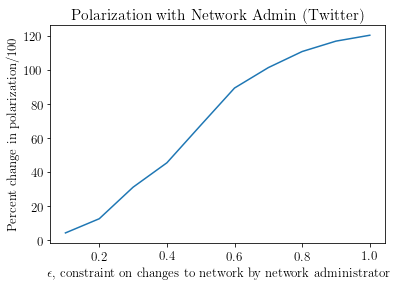

In [294]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = rd[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (Twitter)')

plt.savefig('polarization_twitter.pdf')

# large increase in polarization - though not nearly as large as in Reddit :) 

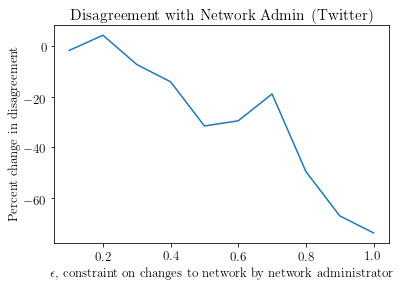

In [295]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = rd[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Network Admin (Twitter)')

plt.savefig('disagreement_twitter.pdf')

# wow, disagreement increases a lot too!

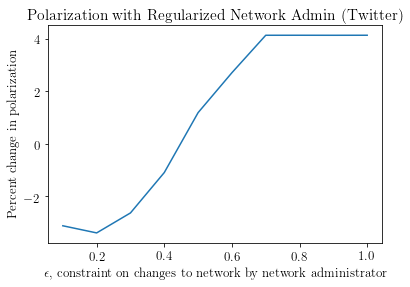

In [296]:
# same plots, but with network fix
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        pls = rd_fix[lam][0]
    else:
        pls = rd_fix_large[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization')
plt.title('Polarization with Regularized Network Admin (Twitter)')
    
plt.savefig('polarization_twitter_fix.pdf')

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)

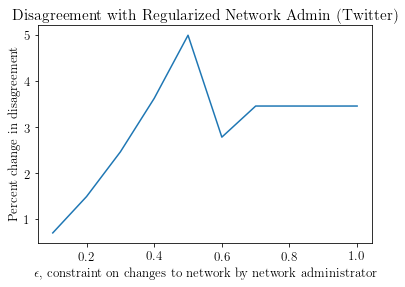

In [297]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        dis = rd_fix[lam][1]
    else:
        dis = rd_fix_large[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Regularized Network Admin (Twitter)')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig('disagreement_twitter_fix.pdf')

# okay, so disagreement more-or-less stays the same!

### Visualize some twitter

In [791]:
def vis_params(W,z_op,layout='spring'):
    G = nx.Graph(W)
    # filter edges?
#     fedges = [edge for edge in G.edges() if W[edge] < 0.1]
#     G.remove_edges_from(fedges)
    
    # filter vertices?
#     to_remove=[node for node,degree in G.degree() if degree < 2]
#     G.remove_nodes_from(to_remove)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z_op[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors, emin, emax, vmin, vmax,width=0.5,node_size=150):
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, cmap=plt.cm.coolwarm, vmin=vmin,vmax=vmax, width=width, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)

In [799]:
# rd, rd_fix, 
# rd_large, rd_large_fix

# don't plot _every_ edge... only some subset
inds = np.random.choice(range(n_twitter),size=300,replace=False)
#inds=list(range(n_twitter))

# filter out singleton nodes
inds = [i for i in inds if np.sum(A[i,inds]) > 4]
print(len(inds))

Ga, posa, edge_colors_a, node_colors_a = vis_params(A[np.ix_(inds,inds)], z[inds])

# plot lam=0.2, 0.4, 0.6
z1=rd[0.2][2][inds]
W1=rd[0.2][3][np.ix_(inds,inds)]

z2=rd[0.4][2][inds]
W2=rd[0.4][3][np.ix_(inds,inds)]

z3=rd[0.6][2][inds]
W3=rd[0.6][3][np.ix_(inds,inds)]

G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1)
G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W3, z3)

167


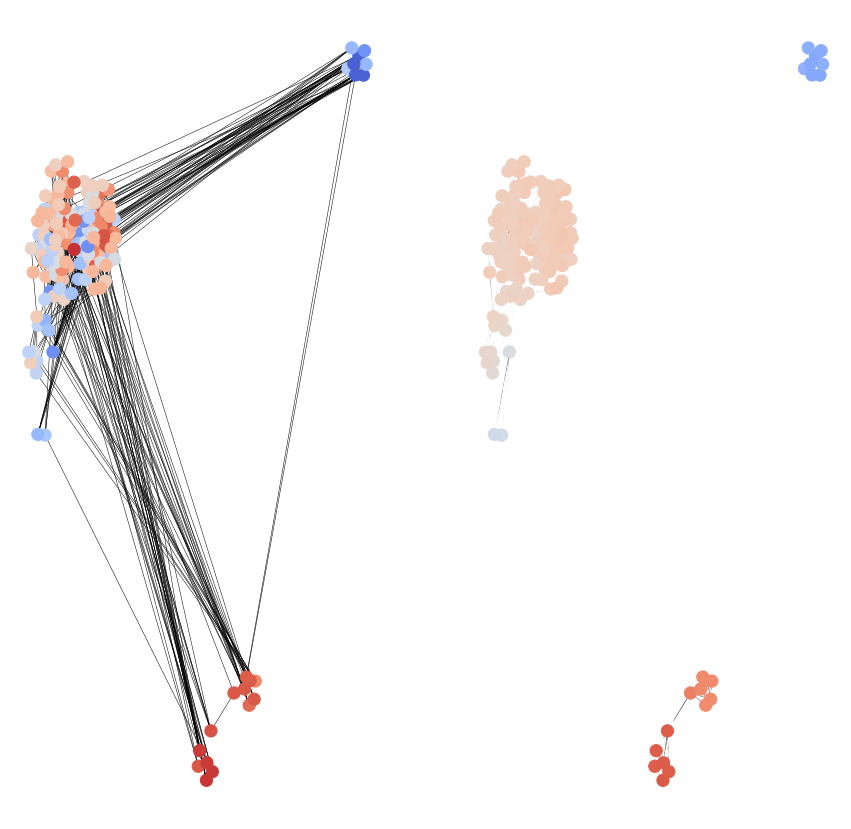

In [801]:
emin=0
emax=1.0

# otherwise all the nodes are super grey
vmin=0.0
vmax=1.0

f, axs = plt.subplots(1,2,figsize=(15,15))

pos=pos2

plt.subplot(121)
plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin, vmax)

plt.subplot(122)
plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin, vmax)

# plt.subplot(221)
# plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin, vmax)
# plt.subplot(222)
# plot_graph(G1, pos, node_colors_1, edge_colors_1, emin, emax, vmin, vmax)
# plt.subplot(223)
# plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin, vmax)
# plt.subplot(224)
# plot_graph(G3, pos, node_colors_3, edge_colors_3, emin, emax, vmin, vmax)

plt.savefig('twitter_plot_example.pdf')

### Estimate q,p for Twitter

In [163]:
q0 = np.where(s > 0.5)[0]
q1 = np.where(s < 0.5)[0]

# how many connections between groups
between_groups = 0
in_0 = 0
in_1 = 0

for u in range(n_twitter):
    for v in range(n_twitter):
        if A[u,v] > 0:
            
            if (u in q0 and v in q1) or (u in q1 and v in q0):
                between_groups += 1
            elif (u in q0 and v in q0):
                in_0 += 1
            else:
                in_1 += 1
between_groups /= 2
in_0 /= 2
in_1 /= 2

q0_est = in_0 / (len(q0)**2 / 2)
q1_est = in_1 / (len(q1)**2 / 2)

p_est = between_groups / (len(q0) * len(q1))
print('q0: {}'.format(q0_est))
print('q1: {}'.format(q1_est))
print(p_est)

q0: 0.01873077662437524
q1: 0.04030612244897959
0.029481792717086834


In [148]:
print(between_groups)
print(in_0)
print(in_1)

1684.0
1559.0
395.0


In [162]:
print(len(q0))
print(len(q1))

408
140


In [18]:
print(compute_pls(z)) #fairly high

0.17736501413968897


### Try to plot

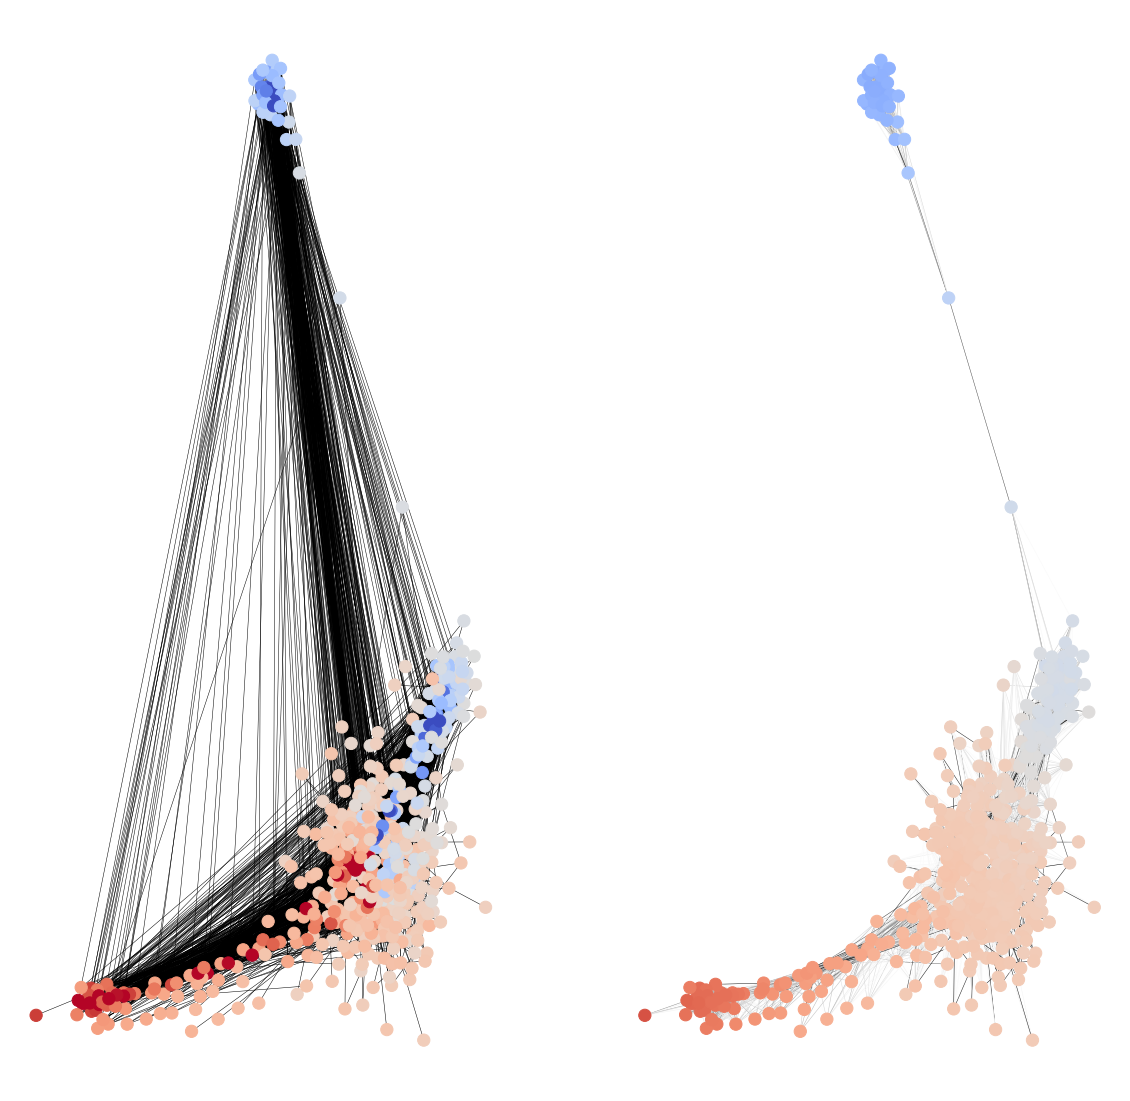

In [150]:
Ga, posa, edge_colors_a, node_colors_a = vis_params(A, s)

W=np.round(W,decimals=3)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W, z)


emin=0
emax=1
vmin=0
vmax=1

f, axs = plt.subplots(2,2,figsize=(20,20))

pos=pos3

plt.subplot(121)
plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin, vmax)
plt.subplot(122)
plot_graph(G3, pos, node_colors_3, edge_colors_3, emin, emax, vmin, vmax)

0.0

In [142]:
np.sum(A,0)

array([ 16.,   8.,   4.,   5.,  20.,   7.,  27.,   8.,   2.,   2.,  37.,
         4.,   4.,   8.,  16.,   5.,   4.,  53.,   2.,   3.,   9.,   4.,
         2., 125.,   7.,   7.,  17.,   2.,  16.,   8.,  31.,   2.,  12.,
         2.,  31.,  19.,  15.,   3.,  12.,   2.,   1.,   9.,  10.,   6.,
         3.,   1.,   3.,  27.,   4.,  27.,   3.,   6.,   8.,  38.,   8.,
         6.,  14.,  24.,   5.,   6.,   5.,   4.,   8.,   3.,   3.,  54.,
         4.,   2.,   8.,  10.,   5.,   2.,   6.,  12.,  11.,   8.,   9.,
        30.,  15.,  18.,   2.,  10.,   3.,   3.,  10.,  31.,  22.,   4.,
        11.,   1.,   4.,  18.,   4.,   3.,   2.,   5.,   4.,  16.,  12.,
        15.,   3.,   8.,   4.,   8.,  22.,   9.,   4.,  10.,  12.,  14.,
        10.,  22.,   5.,  38.,  10.,   5.,  19.,  21.,  17.,  34.,  23.,
         1.,   5.,  14.,   2.,  23.,   2.,   2.,   7.,  15.,   3.,  42.,
         6.,   4.,  23.,   9.,   9.,   9.,   5.,  29.,  24.,   3.,  20.,
        11.,  39.,   5.,   4.,  39.,   7.,   5.,  1

# SBM plots for presentation

In [46]:
q=0.3
p = 1/30

A, s = create_A_s(q, q, p, s0_mean=0.15, s1_mean=0.85, s_std=0.1,n=32,m=32,lb=0,ub=1)

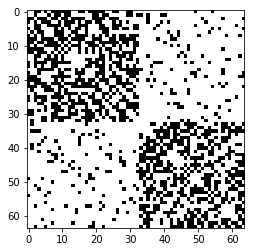

In [28]:
plt.imshow(1-A, cmap=cm.Greys_r)

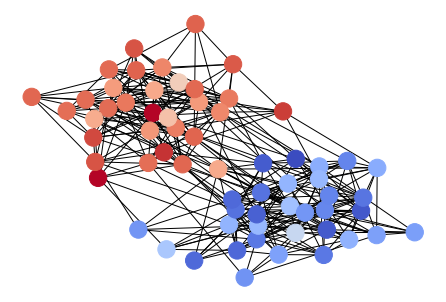

In [58]:
q=0.3
p = 1/30

A, s = create_A_s(q, q, p, s0_mean=0.15, s1_mean=0.85, s_std=0.1,n=32,m=32,lb=0,ub=1)

def vis_params(W,z,layout='spring'):
    G = nx.Graph(W)
    # filter edges?
    fedges = [edge for edge in G.edges() if W[edge] < 0.2]
    G.remove_edges_from(fedges)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
#         if W[u,v] < 0.2:
#             edge_colors[i] = 0
#         else:
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors, emin, emax, vmin, vmax,width=0.5,node_size=150):
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, cmap=plt.cm.coolwarm, vmin=vmin,vmax=vmax, width=width, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)

G, pos, edge_colors, node_colors = vis_params(A, s)

# # set scale for edges
# # we want weight emax to be the darkest edge, and 0.0 to be the lightest edge
emin=0.2
emax=1.0

# # set scale for vertices
# # we want 1.0 to be reddest vertex, 0.0 to be bluest vertex

# vmin1=-1.0
# vmax1=1.0

# vmin2=np.min(z2)
# vmax2=np.max(z2)

G = nx.Graph(A)
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)